In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch

from scipy.interpolate import interp2d
from scipy.stats import beta, multivariate_normal, nct, t

**Inputs**:
- A small number of calibration data for each class $k$
- A prior distribution on the Beta distribution parameters. Eventually, we will want to estimate these using maximum likelihood (a la empirical Bayes), but until I figure out how to do that, we will use the KDE distribution fit to the "ground truth" parameters (estimated using all of ImageNet train)

# 1. Setup

## 1a. Prepare inputs

In [5]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [6]:
# Select subset of data
np.random.seed(0)

n = 20 # Number of calibration points per class k
num_classes = 1000

softmax_scores_subset = np.zeros((num_classes * n, num_classes))
labels_subset = np.zeros((num_classes * n, ), dtype=np.int8)

for k in range(num_classes):
    
    # Randomly select n instances of class k
    idx = np.argwhere(labels==k).flatten()
    selected_idx = np.random.choice(idx, replace=False, size=(n,))
    
    softmax_scores_subset[n*k:n*(k+1), :] = softmax_scores[selected_idx, :]
    labels_subset[n*k:(n+1)*k] = k

In [7]:
# Only select data for which k is true class
scores_subset = [softmax_scores_subset[row,labels_subset[row]] for row in range(len(labels_subset))]

In [8]:
# Load KDE estimate of prior
with open('.cache/kde.pkl', 'rb') as f:
    kde = pickle.load(f)

## 1b. Hyperparameters and helper functions

In [66]:
# ===== Hyperparameters =====

num_classes = 1000

# Grid
xmin, xmax = 0, 4 # Grid bounds
ymin, ymax = 0, 4 # Grid bounds
nbins = 200 # Use 100 x 100 grid for now
X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j] # Use 100 x 100 grid for now
positions = np.vstack([X.ravel(), Y.ravel()])

# Threshold for truncating probability distribution
threshold = .001 # this is over a small area 

# Number of rejection sampling samplies
num_samples = 1000

# Grid for discretizing Beta mixture
mixture_grid = np.linspace(1e-5,1-(1e-5),2000) # Exclude 0 and 1 since Beta density blows up at those points

# Specify quantile
alpha = 0.1

In [69]:
D = kde(positions) # Evaluate D on grid

In [76]:
def compute_classk_prod_f(k, a, b, scores_subset,logscale=False):
    '''
    Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    
    Inputs:
        k: class
        a, b: parameters of Beta(a,b)
    '''
    f_ski = beta.pdf(scores_subset[k*n:(k+1)*n], a, b)
    
    if logscale:
        log_prod = np.sum(np.log(f_ski))
        return log_prod
    else:     
        prod = np.prod(f_ski)
        return prod

def compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset):
    '''
    Applies compute_classk_prod_f to all grid points in positions. Replaces nan entries
    with 0 and normalizes the distribution 
    
    Outputs:
        prob: vector of probabilities
        density: prob reshaped into a matrix
    '''

    prod_f = np.array([compute_classk_prod_f(k, positions[0,i], positions[1,i], scores_subset) 
                       for i in range(len(positions[0]))])
    prob = prod_f * D

    # Replace nan entries with 0
    prob[np.isnan(prob)] = 0

    # We can normalize this discretized distribution
    grid_area = ((xmax - xmin) / nbins) * ((ymax - ymin) / nbins)
    prob = prob / (np.sum(prob * grid_area))
    
    # Reshape probs from vector into square matrix
    density = np.reshape(prob, X.shape) 

    return prob, density


def truncate_density(X,Y,density, threshold=.001):
    '''
    Truncate density to rectangle such that all points outside of the rectangle
    have density lower than the threshold
    
    Inputs:
        X, Y: 2D arrays of coordinates
        density: 2D array of probability densities
        threshold: float between 0 and 1
    Output:
        min_alpha, max_alpha, min_beta, max_beta specifying the rectangle
    '''

    above_thresh_alpha = X[density >= threshold]
    above_thresh_beta = Y[density >= threshold]

    min_alpha, max_alpha = above_thresh_alpha.min(), above_thresh_alpha.max()
    min_beta, max_beta = above_thresh_beta.min(), above_thresh_beta.max()
    print("min_alpha, max_alpha:", min_alpha, max_alpha)
    print("min_beta, max_beta:", min_beta, max_beta)
    
    return min_alpha, max_alpha, min_beta, max_beta

def scaled_uniform_density(x, y, min_alpha, max_alpha, min_beta, max_beta, scaling_factor=1):
    # If x,y are just single numbers
    if np.isscalar(x): 
        if x >= min_alpha and x <= max_alpha and y >= min_beta and y <= max_beta:
            density = (max_alpha - min_alpha) * (max_beta - min_beta)
        else:
            density = 0
            
        return scaling_factor * density
    
    # If x,y are 2D matrices
    else:
        rescaled_sampling_density = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                rescaled_sampling_density[i,j] = scaled_uniform_density(X[i,j], Y[i,j], 
                                                                  min_alpha, max_alpha, min_beta, max_beta, 
                                                                  scaling_factor=scaling_factor)

        return rescaled_sampling_density



def highest_prob_alpha_beta(prob, positions):
    """
    Get alpha, beta pair with highest probability
    """
    max_prob = np.max(prob)
    max_prob
    
    max_idx = np.argwhere(prob == max_prob)[0,0]
    highest_prob_alpha = positions[0, max_idx]
    highest_prob_beta = positions[1, max_idx]
    
    print('highest_prob_alpha, highest_prob_beta:', highest_prob_alpha, highest_prob_beta)
    return highest_prob_alpha, highest_prob_beta, max_prob

def compute_scaling_factor(prob, positions, min_alpha, max_alpha, min_beta, max_beta):
    '''
    Compute scaling_factor that is necessary to cover target distribution peak
    '''
    highest_prob_alpha, highest_prob_beta, max_prob = highest_prob_alpha_beta(prob, positions)
    
    unscaled_density = scaled_uniform_density(highest_prob_alpha, highest_prob_beta, 
                                                min_alpha, max_alpha, min_beta, max_beta, 
                                                scaling_factor=1)
    scaling_factor = max_prob / unscaled_density
    
    return scaling_factor


def get_discretized_density(xnew, ynew, X, Y, disc_density):
    xmin, xmax = np.min(X), np.max(X)
    ymin, ymax = np.min(Y), np.max(Y)
    
    # For values within the bounds, return value at nearest (x,y)
    if xnew >= xmin and xnew <= xmax and ynew >= ymin and ynew <= ymax:
        sq_l2_dist = (X - xnew) ** 2 + (Y - ynew) ** 2
        closest_idx = np.argmin(sq_l2_dist)
        return disc_density[closest_idx]
    
    # For values outside bounds, return 0
    else:
        return 0
    
def generate_n_samples(n, min_alpha, max_alpha, min_beta, max_beta, scaling_factor, target_pdf):
    samples = []
    total_sampled = 0
    while len(samples) < n:
        
        # Sample uniformly from rectangle specified by min_alpha, max_alpha
        # min_beta, max_beta
        sample = np.zeros((2,))
        sample[0] = np.random.uniform(low=min_alpha, high=max_alpha)
        sample[1] = np.random.uniform(low=min_beta, high=max_beta)

        target_density = target_pdf(sample[0], sample[1])
        sampling_density = scaled_uniform_density(sample[0], sample[1], 
                                                    min_alpha, max_alpha, min_beta, max_beta,
                                                    scaling_factor)
        accept_prob =  target_density / sampling_density
       
        unif_rv = np.random.rand()
#         print()
#         print('Accept prob', accept_prob)
        if unif_rv < accept_prob:
#             print('ACCEPTED sample')
            samples.append(sample)
        else:
            pass
#             print('Rejected sample')
        total_sampled += 1
    
    print(f"*** Accept rate ***: {n/total_sampled * 100:.2f}%")
    return np.array(samples)

def get_quantile(density, grid, alpha):
    grid_width = grid[1] - grid[0]
    sums = np.cumsum(density) * grid_width
    min_idx = np.argwhere(sums >= 1 - alpha)[0,0]
    
    return grid[min_idx]

Class 0
min_alpha, max_alpha: 0.12060301507537688 1.7085427135678393
min_beta, max_beta: 0.06030150753768844 0.4221105527638191
highest_prob_alpha, highest_prob_beta: 1.4472361809045227 0.22110552763819097
Expected acceptance probability: 0.034754309213102
*** Accept rate ***: 3.70%
[1.50319586e+01 1.62514231e+00 1.14854192e+00 ... 4.88544265e+01
 8.38983010e+01 1.90931957e+03]


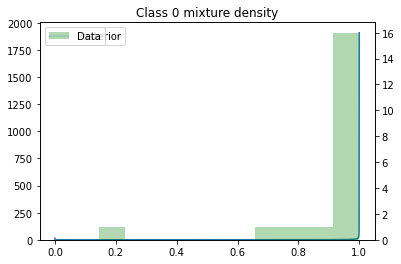

Quantile: 1.0000
Class 1
min_alpha, max_alpha: 0.04020100502512563 0.2814070351758794
min_beta, max_beta: 0.12060301507537688 1.6683417085427137
highest_prob_alpha, highest_prob_beta: 0.12060301507537688 0.5226130653266332
Expected acceptance probability: 0.08115451912781292
*** Accept rate ***: 9.20%
[2.63613510e+03 8.40550764e+01 4.62451250e+01 ... 2.40655016e+00
 3.46911654e+00 3.28897944e+01]


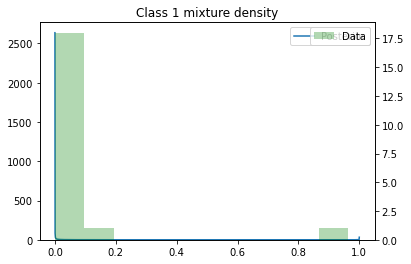

Quantile: 0.0000
Class 2
min_alpha, max_alpha: 0.04020100502512563 0.24120603015075376
min_beta, max_beta: 0.10050251256281408 1.5678391959798996
highest_prob_alpha, highest_prob_beta: 0.10050251256281408 0.4221105527638191
Expected acceptance probability: 0.05234943702725976
*** Accept rate ***: 5.58%
[2644.67281734   77.9251295    42.28385959 ...    4.3917888     6.69340351
   82.7155993 ]


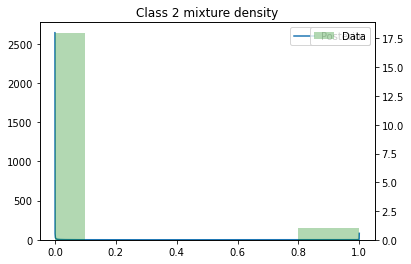

Quantile: 0.0000
Class 3
min_alpha, max_alpha: 0.04020100502512563 0.20100502512562815
min_beta, max_beta: 0.10050251256281408 1.5879396984924623
highest_prob_alpha, highest_prob_beta: 0.08040201005025126 0.4221105527638191
Expected acceptance probability: 0.06243299243222531
*** Accept rate ***: 7.23%
[2758.32444386   77.72774362   41.84122475 ...    3.43833836    5.17986489
   60.33355252]


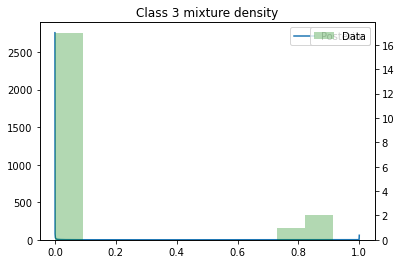

Quantile: 0.0000
Class 4
min_alpha, max_alpha: 0.04020100502512563 0.22110552763819097
min_beta, max_beta: 0.08040201005025126 0.9447236180904522
highest_prob_alpha, highest_prob_beta: 0.10050251256281408 0.32160804020100503
Expected acceptance probability: 0.06248058592522059
*** Accept rate ***: 7.08%
[2488.44501456   71.16908655   38.4143828  ...    8.36494107   13.51014425
  223.43299241]


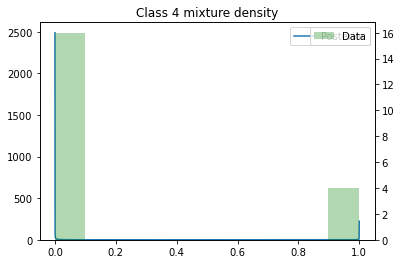

Quantile: 0.0000
Class 5
min_alpha, max_alpha: 0.04020100502512563 0.24120603015075376
min_beta, max_beta: 0.12060301507537688 1.6482412060301508
highest_prob_alpha, highest_prob_beta: 0.10050251256281408 0.4824120603015075
Expected acceptance probability: 0.0752547245491257
*** Accept rate ***: 8.50%
[2701.71203793   82.00972176   44.73475559 ...    2.72149352    3.97061073
   39.17864936]


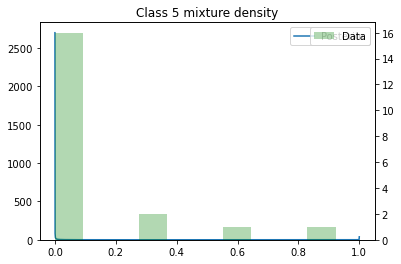

Quantile: 0.0000
Class 6
min_alpha, max_alpha: 0.04020100502512563 0.2814070351758794
min_beta, max_beta: 0.08040201005025126 1.0050251256281406
highest_prob_alpha, highest_prob_beta: 0.12060301507537688 0.3417085427135678
Expected acceptance probability: 0.05653073406238382
*** Accept rate ***: 6.44%
[2340.97411954   72.83842192   39.90691403 ...    8.44062421   13.39983248
  201.46959225]


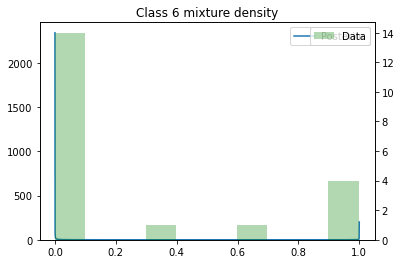

Quantile: 0.0000
Class 7
min_alpha, max_alpha: 0.04020100502512563 0.24120603015075376
min_beta, max_beta: 0.08040201005025126 0.8844221105527639
highest_prob_alpha, highest_prob_beta: 0.10050251256281408 0.30150753768844224
Expected acceptance probability: 0.05696771894209935
*** Accept rate ***: 6.60%
[2404.34365824   70.71681283   38.36104308 ...    9.43755821   15.30429069
  257.37174833]


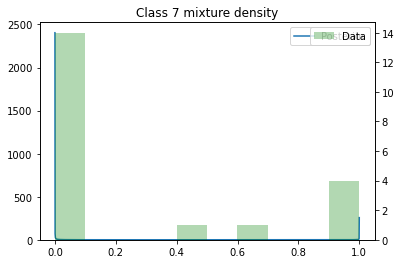

Quantile: 0.0000
Class 8
min_alpha, max_alpha: 0.04020100502512563 0.2613065326633166
min_beta, max_beta: 0.08040201005025126 0.9447236180904522
highest_prob_alpha, highest_prob_beta: 0.10050251256281408 0.32160804020100503
Expected acceptance probability: 0.06130834386074715
*** Accept rate ***: 6.85%
[2353.06397584   71.86930591   39.24867987 ...    8.96767822   14.36974409
  227.08249971]


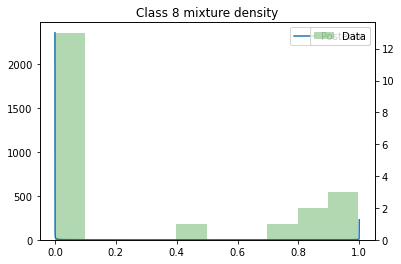

Quantile: 0.0000
Class 9
min_alpha, max_alpha: 0.04020100502512563 0.22110552763819097
min_beta, max_beta: 0.04020100502512563 0.542713567839196
highest_prob_alpha, highest_prob_beta: 0.08040201005025126 0.20100502512562815
Expected acceptance probability: 0.06643792787521535
*** Accept rate ***: 7.67%
[2215.22618612   61.94280713   33.30283115 ...   15.11314561   26.14885817
  628.94644255]


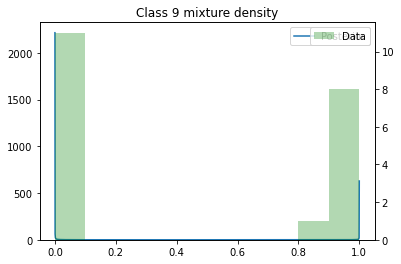

Quantile: 0.0000
Class 10
min_alpha, max_alpha: 0.04020100502512563 0.24120603015075376
min_beta, max_beta: 0.06030150753768844 0.5829145728643216
highest_prob_alpha, highest_prob_beta: 0.10050251256281408 0.22110552763819097
Expected acceptance probability: 0.06452138573048626
*** Accept rate ***: 7.65%
[2193.97981213   63.80739585   34.55003487 ...   14.64162578   24.98016002
  554.94034745]


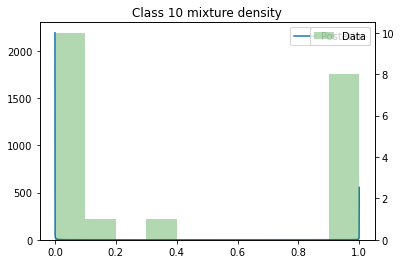

Quantile: 0.0000
Class 11
min_alpha, max_alpha: 0.04020100502512563 0.30150753768844224
min_beta, max_beta: 0.06030150753768844 0.5829145728643216
highest_prob_alpha, highest_prob_beta: 0.12060301507537688 0.22110552763819097
Expected acceptance probability: 0.05995295127609445
*** Accept rate ***: 6.53%
[1965.27235323   62.14435278   34.15371576 ...   16.84983827   28.72543669
  634.14824739]


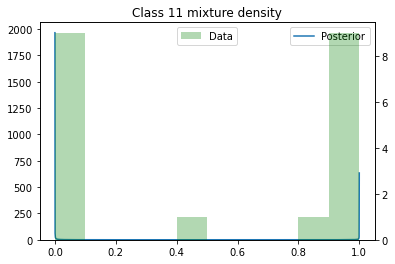

Quantile: 0.0000
Class 12
min_alpha, max_alpha: 0.04020100502512563 0.2814070351758794
min_beta, max_beta: 0.06030150753768844 0.6231155778894473
highest_prob_alpha, highest_prob_beta: 0.12060301507537688 0.24120603015075376
Expected acceptance probability: 0.06352114105132017
*** Accept rate ***: 7.38%
[2085.84430809   64.19051312   35.10512521 ...   15.25845604   25.83185832
  548.4298438 ]


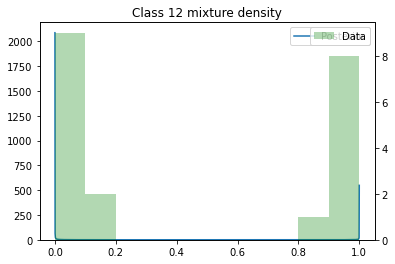

Quantile: 0.0000
Class 13
min_alpha, max_alpha: 0.04020100502512563 0.30150753768844224
min_beta, max_beta: 0.06030150753768844 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 0.12060301507537688 0.20100502512562815
Expected acceptance probability: 0.06511710800276188
*** Accept rate ***: 7.12%
[1915.01074998   60.62783042   33.33140219 ...   17.94840103   30.81631039
  706.83358279]


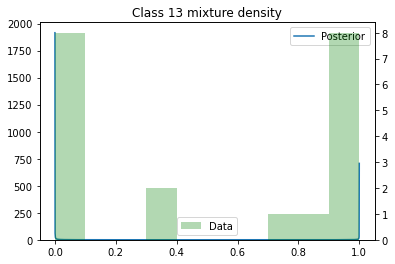

Quantile: 0.0000
Class 14
min_alpha, max_alpha: 0.04020100502512563 0.3417085427135678
min_beta, max_beta: 0.04020100502512563 0.4221105527638191
highest_prob_alpha, highest_prob_beta: 0.12060301507537688 0.16080402010050251
Expected acceptance probability: 0.06054562255679495
*** Accept rate ***: 6.74%
[1663.72341824   54.25130558   29.98371553 ...   22.48416642   39.60106856
 1045.74617832]


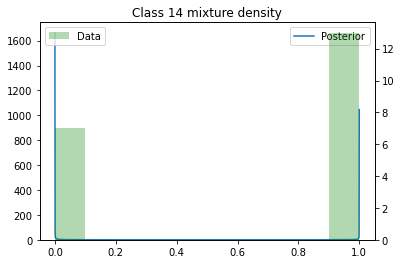

Quantile: 0.0025
Class 15
min_alpha, max_alpha: 0.04020100502512563 0.44221105527638194
min_beta, max_beta: 0.06030150753768844 0.5025125628140703
highest_prob_alpha, highest_prob_beta: 0.16080402010050251 0.20100502512562815
Expected acceptance probability: 0.05780053015498124
*** Accept rate ***: 6.42%
[1401.97466934   52.02756088   29.43361933 ...   22.44773092   38.69658335
  907.95151296]


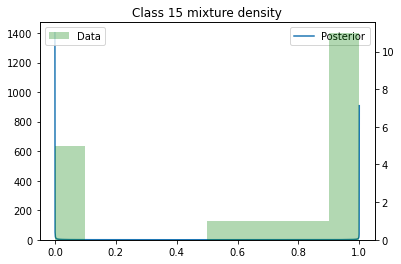

Quantile: 0.0490
Class 16
min_alpha, max_alpha: 0.06030150753768844 0.5628140703517588
min_beta, max_beta: 0.08040201005025126 0.6030150753768845
highest_prob_alpha, highest_prob_beta: 0.20100502512562815 0.24120603015075376
Expected acceptance probability: 0.05736743014961625
*** Accept rate ***: 6.28%
[1136.32250342   48.30562312   28.01338857 ...   20.986298     35.2096868
  710.87880084]


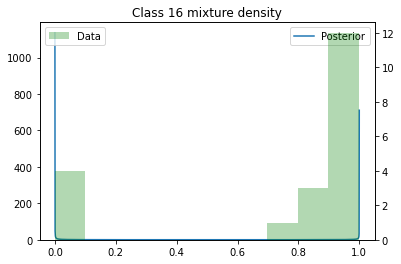

Quantile: 0.2336
Class 17
min_alpha, max_alpha: 0.06030150753768844 0.7236180904522613
min_beta, max_beta: 0.06030150753768844 0.4020100502512563
highest_prob_alpha, highest_prob_beta: 0.22110552763819097 0.16080402010050251
Expected acceptance probability: 0.05884932807874564
*** Accept rate ***: 6.23%
[ 695.47813648   32.73915952   19.36732113 ...   31.19668462   54.91576016
 1444.59408838]


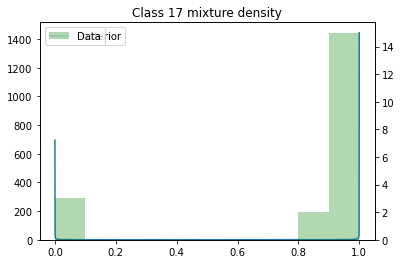

Quantile: 0.9435
Class 18
min_alpha, max_alpha: 0.06030150753768844 0.7236180904522613
min_beta, max_beta: 0.06030150753768844 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 0.24120603015075376 0.22110552763819097
Expected acceptance probability: 0.057288036673269135
*** Accept rate ***: 6.19%
[755.5650264   36.66284215  21.8088847  ...  26.19353432  44.61120277
 977.73208405]


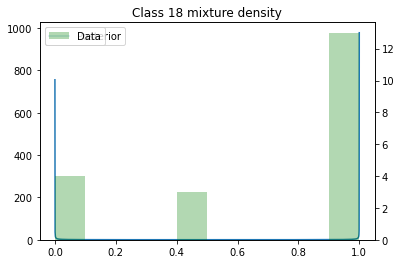

Quantile: 0.8059
Class 19
min_alpha, max_alpha: 0.08040201005025126 1.0251256281407035
min_beta, max_beta: 0.08040201005025126 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 0.3417085427135678 0.22110552763819097
Expected acceptance probability: 0.07513243935407898
*** Accept rate ***: 7.77%
[ 313.88168425   20.7093274    13.07784291 ...   29.92532968   50.49158777
 1050.73773628]


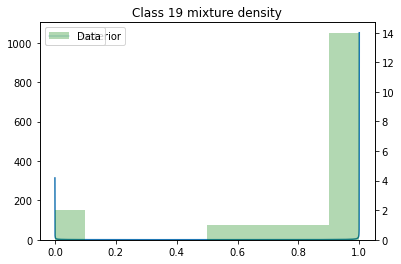

Quantile: 0.9900
Class 20
min_alpha, max_alpha: 0.10050251256281408 1.6281407035175879
min_beta, max_beta: 0.06030150753768844 0.4020100502512563
highest_prob_alpha, highest_prob_beta: 0.4221105527638191 0.16080402010050251
Expected acceptance probability: 0.053259741297988446
*** Accept rate ***: 6.06%
[ 110.206949      9.07829685    5.99916386 ...   40.55869098   70.94232518
 1800.0408761 ]


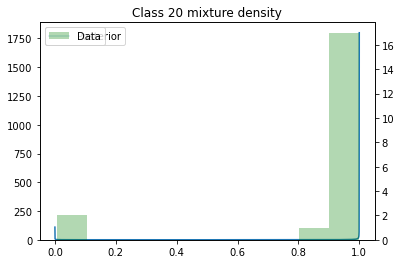

Quantile: 1.0000
Class 21
min_alpha, max_alpha: 0.20100502512562815 1.6482412060301508
min_beta, max_beta: 0.16080402010050251 0.9045226130653267
highest_prob_alpha, highest_prob_beta: 0.8844221105527639 0.44221105527638194
Expected acceptance probability: 0.058117065975484994
*** Accept rate ***: 6.04%
[  8.43095995   2.01908063   1.63806293 ...  20.69892908  31.09455629
 341.35032286]


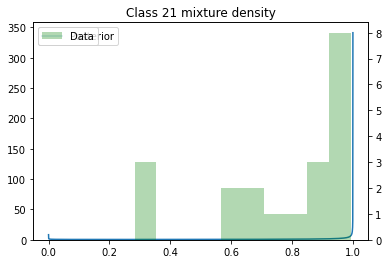

Quantile: 0.9945
Class 22
min_alpha, max_alpha: 0.1407035175879397 1.7085427135678393
min_beta, max_beta: 0.08040201005025126 0.4824120603015075
highest_prob_alpha, highest_prob_beta: 1.4472361809045227 0.24120603015075376
Expected acceptance probability: 0.03415614033654267
*** Accept rate ***: 3.42%
[7.74569103e+00 1.16977500e+00 8.73999131e-01 ... 4.62347830e+01
 7.79284439e+01 1.59535615e+03]


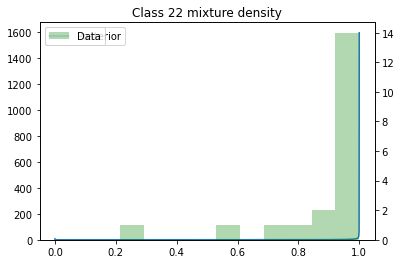

Quantile: 1.0000
Class 23
min_alpha, max_alpha: 0.18090452261306533 1.6482412060301508
min_beta, max_beta: 0.1407035175879397 0.8442211055276382
highest_prob_alpha, highest_prob_beta: 0.8442211055276382 0.4020100502512563
Expected acceptance probability: 0.06459476488745049
*** Accept rate ***: 6.64%
[ 12.46467629   2.46326197   1.93943146 ...  23.91586915  36.77788534
 457.81762313]


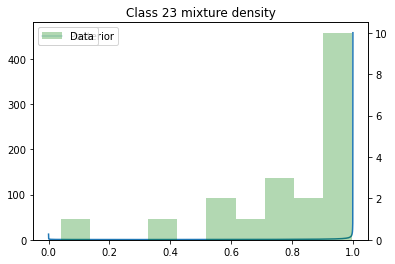

Quantile: 0.9965
Class 24
min_alpha, max_alpha: 0.1407035175879397 1.728643216080402
min_beta, max_beta: 0.06030150753768844 0.38190954773869346
highest_prob_alpha, highest_prob_beta: 1.4673366834170853 0.20100502512562815
Expected acceptance probability: 0.02534692230415321
*** Accept rate ***: 2.74%
[1.88777896e+00 2.48800819e-01 1.84544657e-01 ... 5.35257624e+01
 9.26144884e+01 2.19471144e+03]


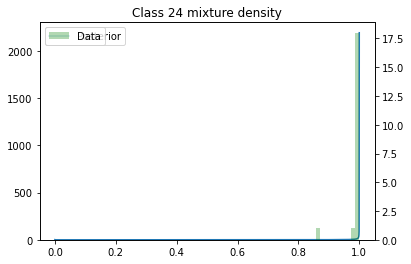

Quantile: 1.0000
Class 25
min_alpha, max_alpha: 0.08040201005025126 1.065326633165829
min_beta, max_beta: 0.08040201005025126 0.542713567839196
highest_prob_alpha, highest_prob_beta: 0.38190954773869346 0.24120603015075376
Expected acceptance probability: 0.07767246677096021
*** Accept rate ***: 8.20%
[267.42798724  18.6155394   11.89116664 ...  29.63316103  49.65692998
 995.0499722 ]


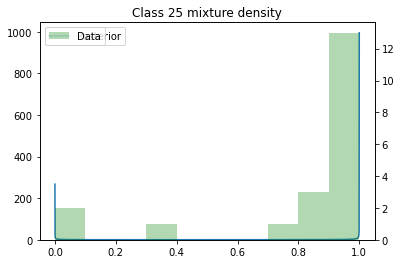

Quantile: 0.9920
Class 26
min_alpha, max_alpha: 0.12060301507537688 1.4673366834170853
min_beta, max_beta: 0.12060301507537688 0.864321608040201
highest_prob_alpha, highest_prob_beta: 0.4824120603015075 0.36180904522613067
Expected acceptance probability: 0.06651378103501053
*** Accept rate ***: 7.18%
[ 84.9872664    9.31005463   6.50342497 ...  19.88934642  30.58839188
 383.17549408]


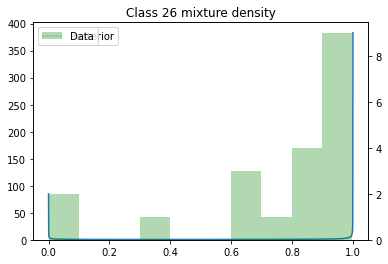

Quantile: 0.9890
Class 27
min_alpha, max_alpha: 0.1407035175879397 1.5879396984924623
min_beta, max_beta: 0.12060301507537688 0.8241206030150754
highest_prob_alpha, highest_prob_beta: 0.7638190954773869 0.38190954773869346
Expected acceptance probability: 0.0839693309334984
*** Accept rate ***: 8.72%
[ 44.45659216   5.69329414   4.11932856 ...  22.47010434  34.74974968
 448.17269108]


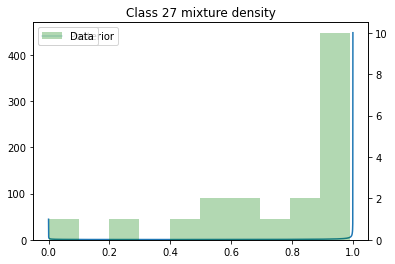

Quantile: 0.9945
Class 28
min_alpha, max_alpha: 0.12060301507537688 1.6884422110552764
min_beta, max_beta: 0.08040201005025126 0.4824120603015075
highest_prob_alpha, highest_prob_beta: 0.7839195979899498 0.24120603015075376
Expected acceptance probability: 0.09297262415736512
*** Accept rate ***: 9.61%
[  38.41723417    4.3160394     3.03300599 ...   41.62638943   70.94440068
 1552.40806279]


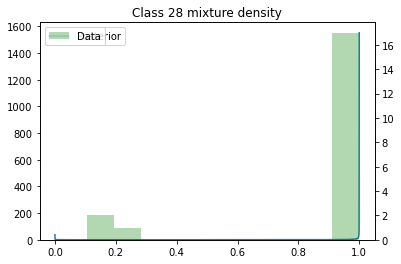

Quantile: 1.0000
Class 29
min_alpha, max_alpha: 0.12060301507537688 1.6884422110552764
min_beta, max_beta: 0.06030150753768844 0.44221105527638194
highest_prob_alpha, highest_prob_beta: 1.4472361809045227 0.22110552763819097
Expected acceptance probability: 0.0848926158643755
*** Accept rate ***: 9.22%
[  33.16910375    3.64952658    2.56666055 ...   43.42820638   74.29821581
 1660.22330007]


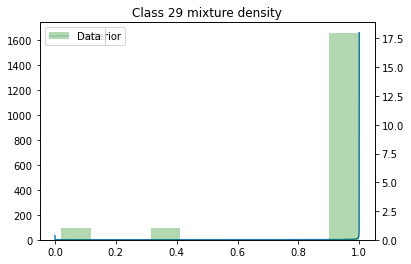

Quantile: 1.0000
Class 30
min_alpha, max_alpha: 0.12060301507537688 1.6482412060301508
min_beta, max_beta: 0.08040201005025126 0.542713567839196
highest_prob_alpha, highest_prob_beta: 0.5829145728643216 0.24120603015075376
Expected acceptance probability: 0.08169069295127993
*** Accept rate ***: 8.78%
[  66.36871853    6.50362664    4.48217459 ...   35.7448079    59.77441316
 1179.52070574]


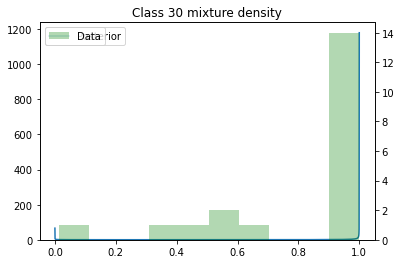

Quantile: 0.9995
Class 31
min_alpha, max_alpha: 0.12060301507537688 1.185929648241206
min_beta, max_beta: 0.12060301507537688 0.8442211055276382
highest_prob_alpha, highest_prob_beta: 0.4623115577889447 0.36180904522613067
Expected acceptance probability: 0.06842971419149482
*** Accept rate ***: 6.77%
[140.05623243  13.19140932   8.92384655 ...  19.72931388  30.59976707
 400.57236568]


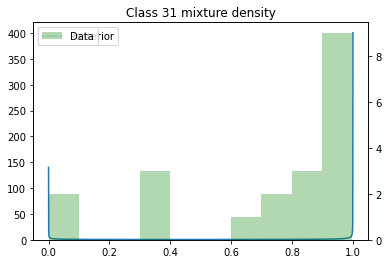

Quantile: 0.9830
Class 32
min_alpha, max_alpha: 0.16080402010050251 1.6281407035175879
min_beta, max_beta: 0.1407035175879397 0.864321608040201
highest_prob_alpha, highest_prob_beta: 0.8241206030150754 0.4221105527638191
Expected acceptance probability: 0.0653697125355728
*** Accept rate ***: 6.34%
[ 20.48972353   3.34093155   2.54635895 ...  21.57217778  32.8127114
 385.46608228]


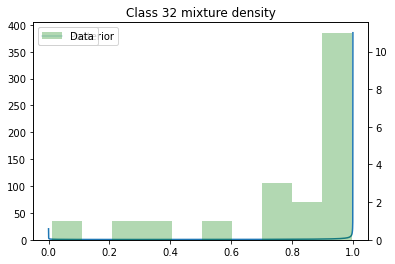

Quantile: 0.9950
Class 33
min_alpha, max_alpha: 0.12060301507537688 1.5075376884422111
min_beta, max_beta: 0.12060301507537688 0.8442211055276382
highest_prob_alpha, highest_prob_beta: 0.5025125628140703 0.36180904522613067
Expected acceptance probability: 0.07019409192512478
*** Accept rate ***: 7.69%
[ 74.28758039   8.56037209   6.02490346 ...  20.5450367   31.68249743
 403.29109791]


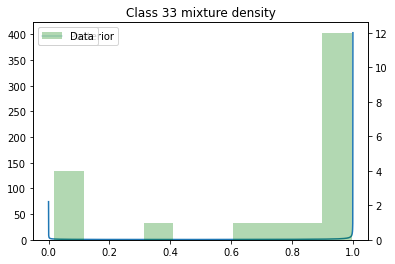

Quantile: 0.9910
Class 34
min_alpha, max_alpha: 0.08040201005025126 0.864321608040201
min_beta, max_beta: 0.08040201005025126 0.5628140703517588
highest_prob_alpha, highest_prob_beta: 0.2613065326633166 0.24120603015075376
Expected acceptance probability: 0.0641089391247112
*** Accept rate ***: 6.92%
[550.09398244  30.52126663  18.62903105 ...  25.95301601  43.55294672
 880.70266582]


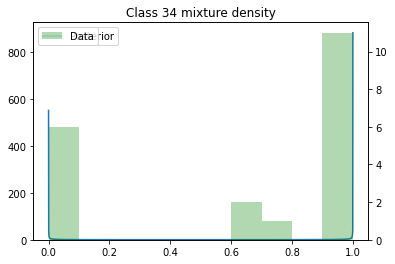

Quantile: 0.9210
Class 35
min_alpha, max_alpha: 0.12060301507537688 1.1658291457286432
min_beta, max_beta: 0.1407035175879397 0.9246231155778895
highest_prob_alpha, highest_prob_beta: 0.4623115577889447 0.38190954773869346
Expected acceptance probability: 0.06745424059201853
*** Accept rate ***: 7.59%
[140.38605816  13.62169172   9.2678544  ...  16.69257057  25.32897672
 294.3139721 ]


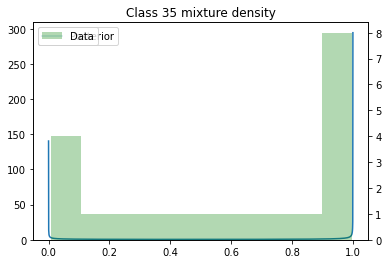

Quantile: 0.9745
Class 36
min_alpha, max_alpha: 0.10050251256281408 0.9246231155778895
min_beta, max_beta: 0.1407035175879397 1.0050251256281406
highest_prob_alpha, highest_prob_beta: 0.36180904522613067 0.44221105527638194
Expected acceptance probability: 0.07534659093605064
*** Accept rate ***: 7.71%
[480.58571285  32.22167271  20.35915303 ...  10.93049044  16.29910598
 173.44473425]


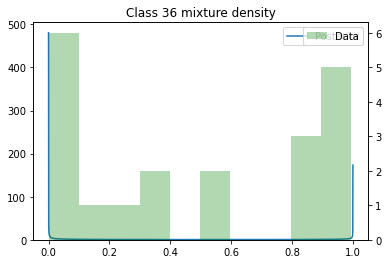

Quantile: 0.7519
Class 37
min_alpha, max_alpha: 0.18090452261306533 1.6683417085427137
min_beta, max_beta: 0.12060301507537688 0.8040201005025126
highest_prob_alpha, highest_prob_beta: 0.8241206030150754 0.38190954773869346
Expected acceptance probability: 0.06591279106932268
*** Accept rate ***: 6.64%
[ 11.79666518   2.28940401   1.79742375 ...  25.85752178  40.20168503
 534.0686895 ]


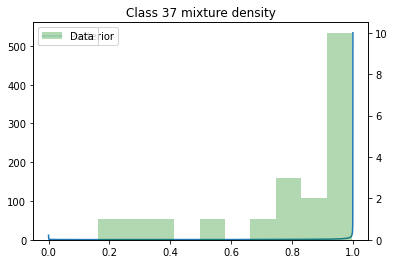

Quantile: 0.9975
Class 38
min_alpha, max_alpha: 0.08040201005025126 1.085427135678392
min_beta, max_beta: 0.08040201005025126 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 0.38190954773869346 0.22110552763819097
Expected acceptance probability: 0.077418491163288
*** Accept rate ***: 8.05%
[ 213.99705191   15.95633649   10.31761447 ...   31.69098459   53.4788323
 1114.50777949]


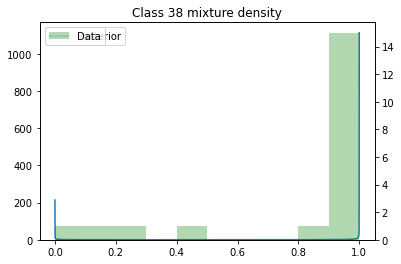

Quantile: 0.9970
Class 39
min_alpha, max_alpha: 0.16080402010050251 1.6281407035175879
min_beta, max_beta: 0.12060301507537688 0.7839195979899498
highest_prob_alpha, highest_prob_beta: 0.7839195979899498 0.36180904522613067
Expected acceptance probability: 0.07250095646361747
*** Accept rate ***: 7.48%
[ 27.94365099   3.98146739   2.95560245 ...  25.08589752  39.13434002
 528.24255679]


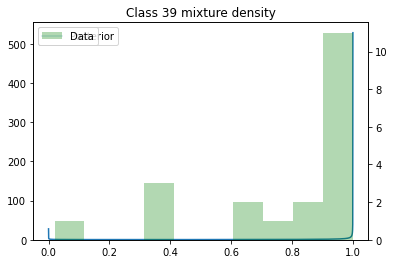

Quantile: 0.9970
Class 40
min_alpha, max_alpha: 0.20100502512562815 1.4673366834170853
min_beta, max_beta: 0.20100502512562815 1.065326633165829
highest_prob_alpha, highest_prob_beta: 0.8241206030150754 0.5226130653266332
Expected acceptance probability: 0.0855786284682708
*** Accept rate ***: 9.05%
[ 20.21382824   3.92825068   3.0660534  ...  10.16148959  14.16823945
 104.274338  ]


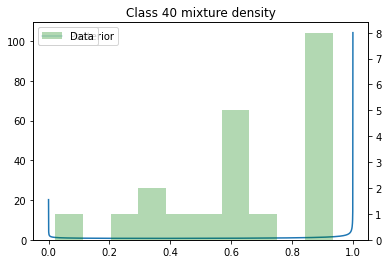

Quantile: 0.9750
Class 41
min_alpha, max_alpha: 0.1407035175879397 1.6884422110552764
min_beta, max_beta: 0.10050251256281408 0.5829145728643216
highest_prob_alpha, highest_prob_beta: 0.8040201005025126 0.2814070351758794
Expected acceptance probability: 0.07540298548323959
*** Accept rate ***: 7.98%
[ 24.24902301   3.33552009   2.4475377  ...  34.94195403  57.18316378
 999.60098292]


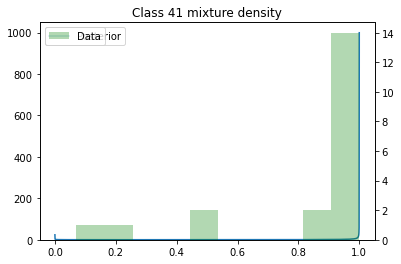

Quantile: 0.9995
Class 42
min_alpha, max_alpha: 0.12060301507537688 1.6683417085427137
min_beta, max_beta: 0.08040201005025126 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 0.7839195979899498 0.2613065326633166
Expected acceptance probability: 0.08524169246597973
*** Accept rate ***: 9.18%
[  46.32192743    5.00625319    3.51339271 ...   37.40451318   62.68435744
 1253.18566417]


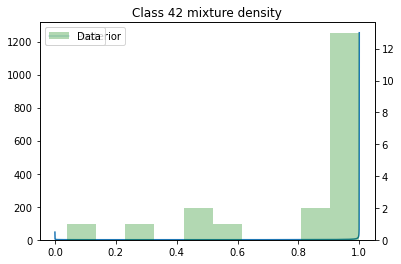

Quantile: 1.0000
Class 43
min_alpha, max_alpha: 0.08040201005025126 1.0251256281407035
min_beta, max_beta: 0.06030150753768844 0.4824120603015075
highest_prob_alpha, highest_prob_beta: 0.3417085427135678 0.20100502512562815
Expected acceptance probability: 0.07159404639456247
*** Accept rate ***: 7.93%
[ 296.66261785   19.2936798    12.16193412 ...   32.7541049    56.15852144
 1278.18180274]


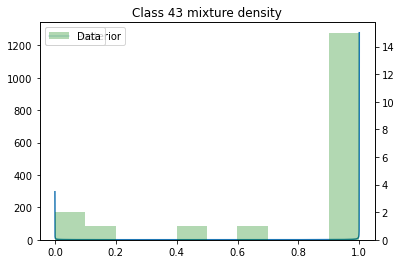

Quantile: 0.9960
Class 44
min_alpha, max_alpha: 0.08040201005025126 1.0251256281407035
min_beta, max_beta: 0.08040201005025126 0.5628140703517588
highest_prob_alpha, highest_prob_beta: 0.3417085427135678 0.24120603015075376
Expected acceptance probability: 0.07450468173333172
*** Accept rate ***: 7.85%
[323.12282082  21.56918791  13.64655995 ...  27.85318239  46.44166287
 904.53753641]


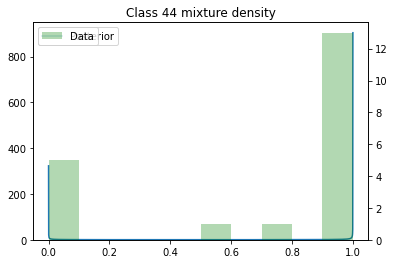

Quantile: 0.9835
Class 45
min_alpha, max_alpha: 0.12060301507537688 1.6884422110552764
min_beta, max_beta: 0.06030150753768844 0.44221105527638194
highest_prob_alpha, highest_prob_beta: 1.4472361809045227 0.22110552763819097
Expected acceptance probability: 0.06869546924498064
*** Accept rate ***: 7.41%
[  32.46327521    3.40824177    2.37774159 ...   44.5243991    76.21984072
 1709.11699113]


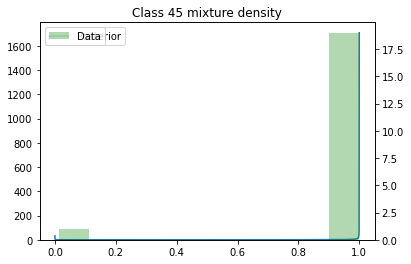

Quantile: 1.0000
Class 46
min_alpha, max_alpha: 0.1407035175879397 1.185929648241206
min_beta, max_beta: 0.18090452261306533 1.065326633165829
highest_prob_alpha, highest_prob_beta: 0.5829145728643216 0.5025125628140703
Expected acceptance probability: 0.09308119694283248
*** Accept rate ***: 10.21%
[103.39272499  11.71896768   8.21610634 ...  10.46137155  14.95666412
 126.31114113]


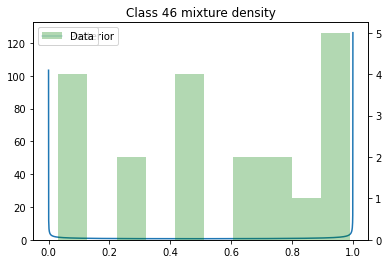

Quantile: 0.9555
Class 47
min_alpha, max_alpha: 0.12060301507537688 1.6884422110552764
min_beta, max_beta: 0.06030150753768844 0.44221105527638194
highest_prob_alpha, highest_prob_beta: 0.7839195979899498 0.22110552763819097
Expected acceptance probability: 0.09892041206766167
*** Accept rate ***: 10.34%
[  39.91612822    4.2755016     2.97868959 ...   42.74157278   73.15739552
 1640.16622731]


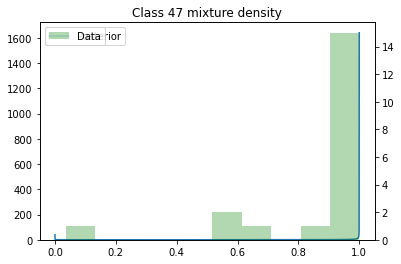

Quantile: 1.0000
Class 48
min_alpha, max_alpha: 0.12060301507537688 1.6884422110552764
min_beta, max_beta: 0.08040201005025126 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 1.4472361809045227 0.24120603015075376
Expected acceptance probability: 0.0729285243050784
*** Accept rate ***: 7.84%
[  21.85659292    2.80957075    2.04039267 ...   40.7384143    68.21601514
 1351.98373542]


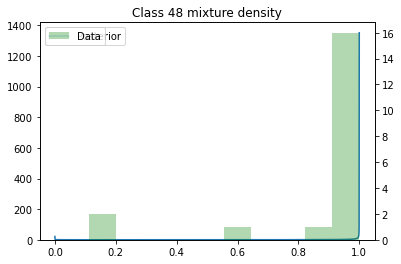

Quantile: 1.0000
Class 49
min_alpha, max_alpha: 0.12060301507537688 1.185929648241206
min_beta, max_beta: 0.12060301507537688 0.8442211055276382
highest_prob_alpha, highest_prob_beta: 0.4623115577889447 0.36180904522613067
Expected acceptance probability: 0.06967282654832832
*** Accept rate ***: 6.99%
[131.92920755  12.83516469   8.73447502 ...  19.25867505  29.75297573
 381.59970082]


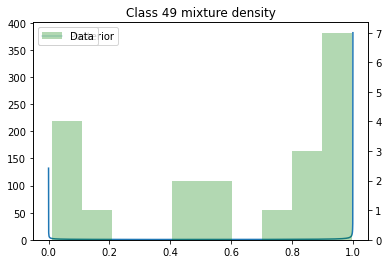

Quantile: 0.9830
Class 50
min_alpha, max_alpha: 0.1407035175879397 1.6281407035175879
min_beta, max_beta: 0.10050251256281408 0.6834170854271356
highest_prob_alpha, highest_prob_beta: 0.7638190954773869 0.3417085427135678
Expected acceptance probability: 0.08537399729088414
*** Accept rate ***: 8.87%
[ 41.71506768   5.38561988   3.89434544 ...  26.6902756   42.3160673
 623.92029147]


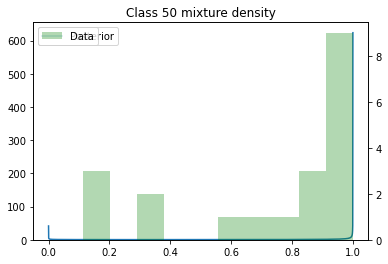

Quantile: 0.9975
Class 51
min_alpha, max_alpha: 0.18090452261306533 1.728643216080402
min_beta, max_beta: 0.08040201005025126 0.44221105527638194
highest_prob_alpha, highest_prob_beta: 1.4673366834170853 0.22110552763819097
Expected acceptance probability: 0.024931266749503685
*** Accept rate ***: 2.79%
[2.16377529e+00 2.73350154e-01 2.04320647e-01 ... 5.06759281e+01
 8.59152941e+01 1.81398389e+03]


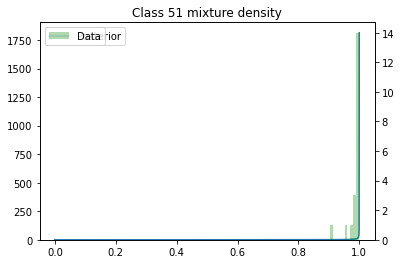

Quantile: 1.0000
Class 52
min_alpha, max_alpha: 0.10050251256281408 1.1457286432160805
min_beta, max_beta: 0.10050251256281408 0.6633165829145728
highest_prob_alpha, highest_prob_beta: 0.44221105527638194 0.30150753768844224
Expected acceptance probability: 0.07894830015682316
*** Accept rate ***: 8.07%
[166.41719777  14.25415599   9.47519412 ...  24.84929026  40.02907788
 647.25709513]


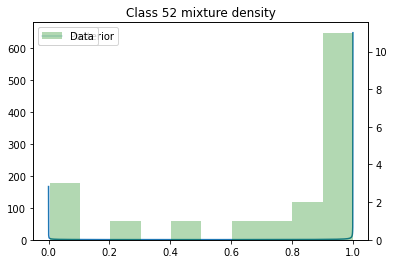

Quantile: 0.9905
Class 53
min_alpha, max_alpha: 0.12060301507537688 1.5477386934673367
min_beta, max_beta: 0.10050251256281408 0.6834170854271356
highest_prob_alpha, highest_prob_beta: 0.5025125628140703 0.32160804020100503
Expected acceptance probability: 0.07359871423914473
*** Accept rate ***: 7.68%
[ 80.40469821   8.78239198   6.10942323 ...  25.84778399  41.28313536
 635.8038066 ]


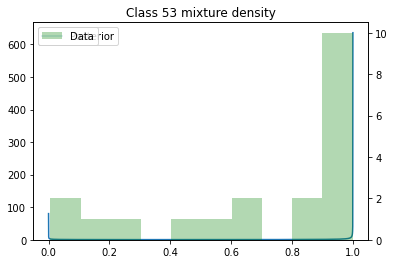

Quantile: 0.9960
Class 54
min_alpha, max_alpha: 0.12060301507537688 1.085427135678392
min_beta, max_beta: 0.16080402010050251 1.065326633165829
highest_prob_alpha, highest_prob_beta: 0.4221105527638191 0.44221105527638194
Expected acceptance probability: 0.07570181477114367
*** Accept rate ***: 7.61%
[248.57203068  21.42781484  14.20525555 ...  10.39999862  15.17485855
 143.93261846]


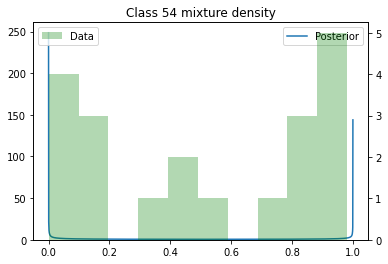

Quantile: 0.8969
Class 55
min_alpha, max_alpha: 0.08040201005025126 0.9447236180904522
min_beta, max_beta: 0.10050251256281408 0.7638190954773869
highest_prob_alpha, highest_prob_beta: 0.32160804020100503 0.32160804020100503
Expected acceptance probability: 0.07071042283296165
*** Accept rate ***: 7.63%
[438.42219477  28.47074131  17.89386959 ...  18.50424983  29.31550186
 431.58378784]


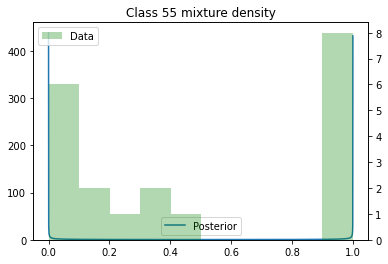

Quantile: 0.8894
Class 56
min_alpha, max_alpha: 0.1407035175879397 1.6281407035175879
min_beta, max_beta: 0.12060301507537688 0.7638190954773869
highest_prob_alpha, highest_prob_beta: 0.7839195979899498 0.36180904522613067
Expected acceptance probability: 0.07356884495757257
*** Accept rate ***: 7.46%
[ 31.08833779   4.30943947   3.17971818 ...  25.25481094  39.52980931
 543.86825815]


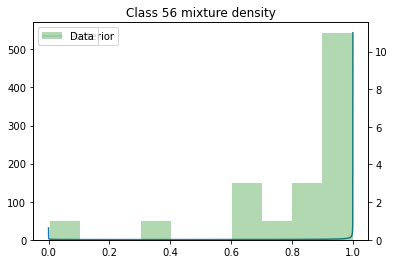

Quantile: 0.9970
Class 57
min_alpha, max_alpha: 0.1407035175879397 1.5678391959798996
min_beta, max_beta: 0.12060301507537688 0.8442211055276382
highest_prob_alpha, highest_prob_beta: 0.7638190954773869 0.4020100502512563
Expected acceptance probability: 0.08570814017244156
*** Accept rate ***: 8.37%
[ 55.98023865   6.69674636   4.78522332 ...  21.42429369  33.00303787
 416.07512691]


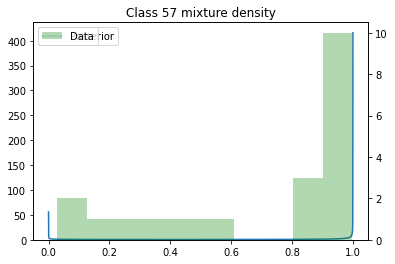

Quantile: 0.9930
Class 58
min_alpha, max_alpha: 0.12060301507537688 1.4673366834170853
min_beta, max_beta: 0.12060301507537688 0.8040201005025126
highest_prob_alpha, highest_prob_beta: 0.4824120603015075 0.3417085427135678
Expected acceptance probability: 0.06318865395368492
*** Accept rate ***: 6.84%
[ 97.5056655   10.23504292   7.06522919 ...  22.13353225  34.66580706
 479.7510772 ]


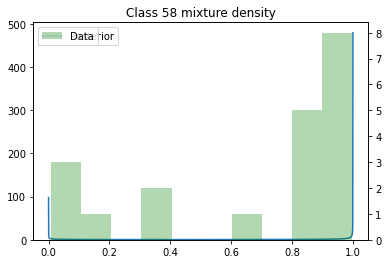

Quantile: 0.9915
Class 59
min_alpha, max_alpha: 0.12060301507537688 1.185929648241206
min_beta, max_beta: 0.1407035175879397 0.9447236180904522
highest_prob_alpha, highest_prob_beta: 0.4824120603015075 0.4020100502512563
Expected acceptance probability: 0.07048652982055065
*** Accept rate ***: 7.51%
[124.72176141  12.78920014   8.78046163 ...  15.9562544   24.02791192
 267.79573932]


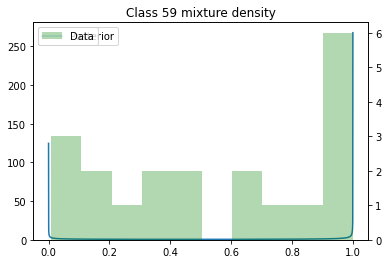

Quantile: 0.9745
Class 60
min_alpha, max_alpha: 0.12060301507537688 1.1256281407035176
min_beta, max_beta: 0.1407035175879397 1.0050251256281406
highest_prob_alpha, highest_prob_beta: 0.44221105527638194 0.4221105527638191
Expected acceptance probability: 0.06511239799203393
*** Accept rate ***: 6.63%
[215.67970429  18.77443088  12.49650652 ...  13.36403092  19.96796296
 215.05448422]


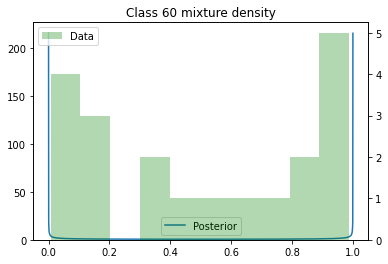

Quantile: 0.9380
Class 61
min_alpha, max_alpha: 0.16080402010050251 1.5477386934673367
min_beta, max_beta: 0.16080402010050251 0.9447236180904522
highest_prob_alpha, highest_prob_beta: 0.8040201005025126 0.4623115577889447
Expected acceptance probability: 0.07094072628728666
*** Accept rate ***: 7.59%
[ 32.88371109   4.87352321   3.62781264 ...  16.88745235  25.00211026
 253.83603995]


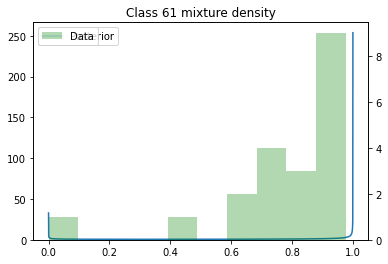

Quantile: 0.9890
Class 62
min_alpha, max_alpha: 0.08040201005025126 0.7638190954773869
min_beta, max_beta: 0.12060301507537688 0.9045226130653267
highest_prob_alpha, highest_prob_beta: 0.2613065326633166 0.36180904522613067
Expected acceptance probability: 0.06574055091828948
*** Accept rate ***: 6.80%
[736.98649292  40.89201987  24.92974835 ...  13.06363268  20.20456466
 263.37086608]


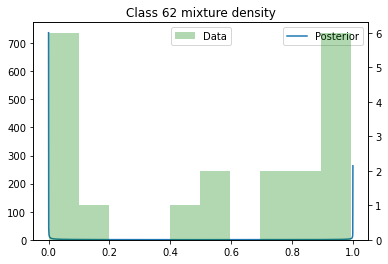

Quantile: 0.5463
Class 63
min_alpha, max_alpha: 0.1407035175879397 1.6884422110552764
min_beta, max_beta: 0.10050251256281408 0.6030150753768845
highest_prob_alpha, highest_prob_beta: 0.8040201005025126 0.30150753768844224
Expected acceptance probability: 0.07480054709591133
*** Accept rate ***: 7.64%
[ 21.2151378    2.91094596   2.15642039 ...  34.36062822  55.87657133
 941.87616469]


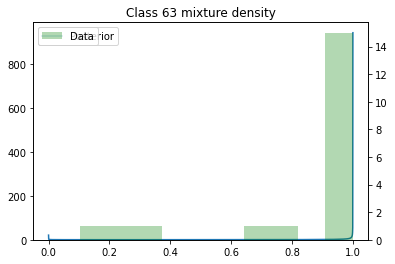

Quantile: 0.9995
Class 64
min_alpha, max_alpha: 0.12060301507537688 1.5678391959798996
min_beta, max_beta: 0.12060301507537688 0.7437185929648241
highest_prob_alpha, highest_prob_beta: 0.5025125628140703 0.32160804020100503
Expected acceptance probability: 0.0770413177320635
*** Accept rate ***: 7.98%
[ 68.92122253   7.76000732   5.44798813 ...  24.42808909  38.56832076
 559.41664157]


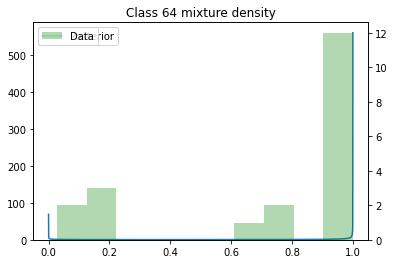

Quantile: 0.9955
Class 65
min_alpha, max_alpha: 0.10050251256281408 1.5678391959798996
min_beta, max_beta: 0.08040201005025126 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 0.4221105527638191 0.22110552763819097
Expected acceptance probability: 0.0620898317569834
*** Accept rate ***: 6.48%
[ 137.69564641   11.39620432    7.53862743 ...   34.28597362   57.97416047
 1219.84951105]


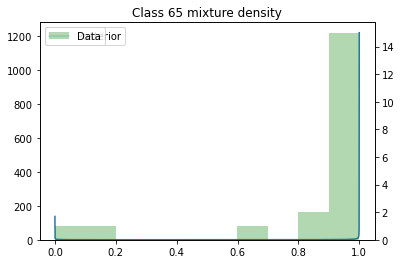

Quantile: 0.9990
Class 66
min_alpha, max_alpha: 0.08040201005025126 0.6030150753768845
min_beta, max_beta: 0.18090452261306533 1.6683417085427137
highest_prob_alpha, highest_prob_beta: 0.24120603015075376 0.6432160804020101
Expected acceptance probability: 0.07868648663537317
*** Accept rate ***: 7.87%
[1200.00610303   61.57792526   36.97506455 ...    2.37647383    3.18309755
   19.97694978]


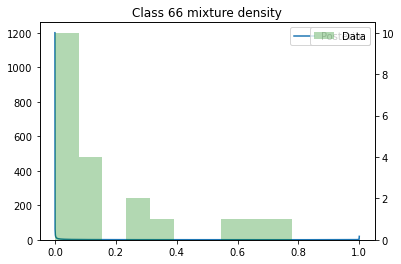

Quantile: 0.0525
Class 67
min_alpha, max_alpha: 0.10050251256281408 1.1658291457286432
min_beta, max_beta: 0.10050251256281408 0.7236180904522613
highest_prob_alpha, highest_prob_beta: 0.4623115577889447 0.3417085427135678
Expected acceptance probability: 0.07195751440366711
*** Accept rate ***: 7.63%
[159.6795308   14.27951331   9.56168851 ...  21.83472     34.45762616
 495.70221808]


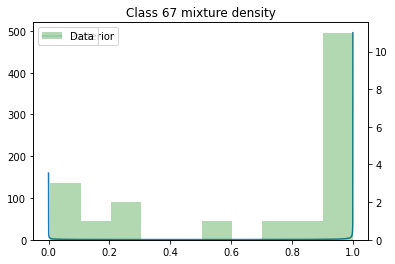

Quantile: 0.9855
Class 68
min_alpha, max_alpha: 0.12060301507537688 1.105527638190955
min_beta, max_beta: 0.18090452261306533 1.105527638190955
highest_prob_alpha, highest_prob_beta: 0.4623115577889447 0.6231155778894473
Expected acceptance probability: 0.08463003838989952
*** Accept rate ***: 8.86%
[239.61597083  21.61491914  14.44399853 ...   7.53478649  10.61580913
  84.53098568]


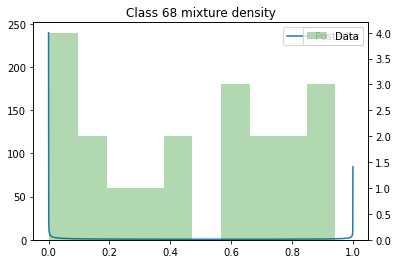

Quantile: 0.8649
Class 69
min_alpha, max_alpha: 0.08040201005025126 1.5678391959798996
min_beta, max_beta: 0.06030150753768844 0.36180904522613067
highest_prob_alpha, highest_prob_beta: 0.4020100502512563 0.1407035175879397
Expected acceptance probability: 0.0475028241249102
*** Accept rate ***: 5.03%
[ 189.24948862   13.01934968    8.31136141 ...   39.68152404   70.41909758
 1933.59954782]


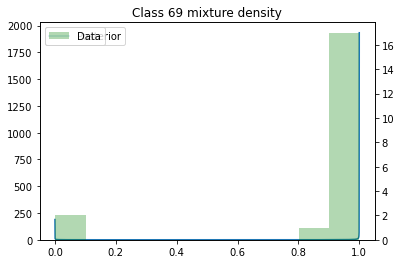

Quantile: 1.0000
Class 70
min_alpha, max_alpha: 0.08040201005025126 1.6884422110552764
min_beta, max_beta: 0.06030150753768844 0.3417085427135678
highest_prob_alpha, highest_prob_beta: 0.44221105527638194 0.1407035175879397
Expected acceptance probability: 0.05810649739795665
*** Accept rate ***: 6.35%
[  60.46066499    5.50747458    3.70195695 ...   45.66038912   81.15010257
 2246.97844864]


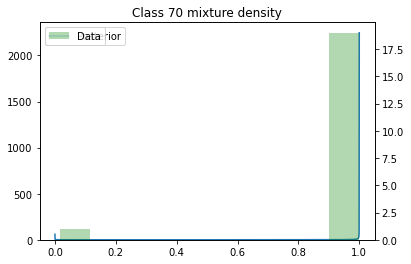

Quantile: 1.0000
Class 71
min_alpha, max_alpha: 0.10050251256281408 1.6683417085427137
min_beta, max_beta: 0.06030150753768844 0.4221105527638191
highest_prob_alpha, highest_prob_beta: 0.44221105527638194 0.16080402010050251
Expected acceptance probability: 0.06945086991937628
*** Accept rate ***: 7.63%
[  73.69188894    6.54567369    4.41026315 ...   41.72693598   72.3116062
 1742.5581706 ]


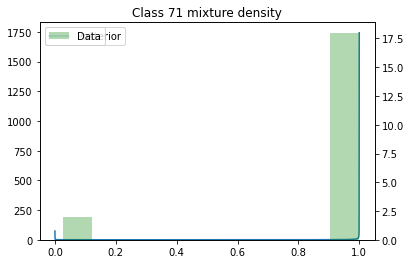

Quantile: 1.0000
Class 72
min_alpha, max_alpha: 0.18090452261306533 1.5879396984924623
min_beta, max_beta: 0.16080402010050251 0.9246231155778895
highest_prob_alpha, highest_prob_beta: 0.8442211055276382 0.4623115577889447
Expected acceptance probability: 0.0652806638832624
*** Accept rate ***: 6.47%
[ 21.75592823   3.7627163    2.87809863 ...  17.60845741  26.08495049
 264.37741675]


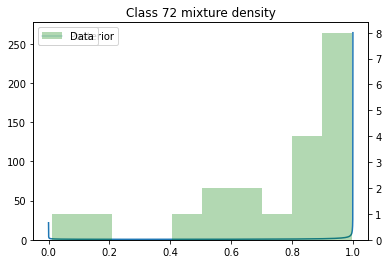

Quantile: 0.9910
Class 73
min_alpha, max_alpha: 0.06030150753768844 0.5025125628140703
min_beta, max_beta: 0.10050251256281408 0.8040201005025126
highest_prob_alpha, highest_prob_beta: 0.18090452261306533 0.30150753768844224
Expected acceptance probability: 0.05768270549023477
*** Accept rate ***: 6.29%
[1384.66424922   57.1506237    32.96049078 ...   13.84744411   22.19169388
  349.12287394]


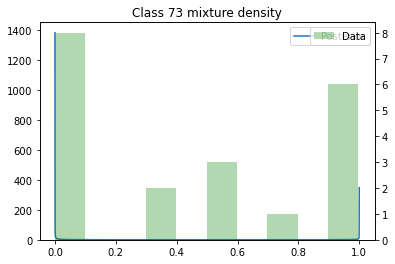

Quantile: 0.0340
Class 74
min_alpha, max_alpha: 0.10050251256281408 0.8442211055276382
min_beta, max_beta: 0.16080402010050251 1.4673366834170853
highest_prob_alpha, highest_prob_beta: 0.32160804020100503 0.542713567839196
Expected acceptance probability: 0.06658780094504614
*** Accept rate ***: 6.89%
[591.96615806  38.53765943  24.21268724 ...   6.11876889   8.68217369
  72.9625485 ]


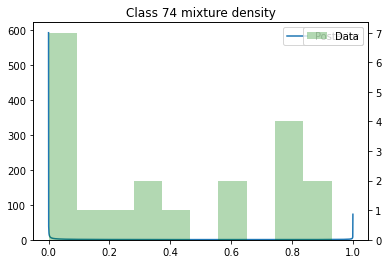

Quantile: 0.5403
Class 75
min_alpha, max_alpha: 0.1407035175879397 1.6884422110552764
min_beta, max_beta: 0.10050251256281408 0.5628140703517588
highest_prob_alpha, highest_prob_beta: 1.4472361809045227 0.2613065326633166
Expected acceptance probability: 0.07296488714833288
*** Accept rate ***: 8.08%
[  20.68935082    2.76360738    2.02599741 ...   37.88998138   62.44629301
 1129.21978111]


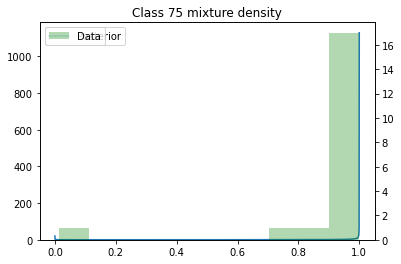

Quantile: 0.9995
Class 76
min_alpha, max_alpha: 0.1407035175879397 1.7085427135678393
min_beta, max_beta: 0.08040201005025126 0.5025125628140703
highest_prob_alpha, highest_prob_beta: 1.4472361809045227 0.24120603015075376
Expected acceptance probability: 0.03910505409798856
*** Accept rate ***: 3.97%
[1.14495871e+01 1.53934723e+00 1.13366455e+00 ... 4.50156772e+01
 7.57665876e+01 1.53973148e+03]


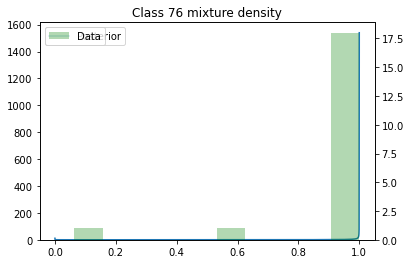

Quantile: 1.0000
Class 77
min_alpha, max_alpha: 0.18090452261306533 1.6482412060301508
min_beta, max_beta: 0.1407035175879397 0.8844221105527639
highest_prob_alpha, highest_prob_beta: 0.8442211055276382 0.4221105527638191
Expected acceptance probability: 0.05970670398569313
*** Accept rate ***: 6.05%
[ 10.0921821    2.29306691   1.8367728  ...  21.26237171  32.09557413
 360.08975245]


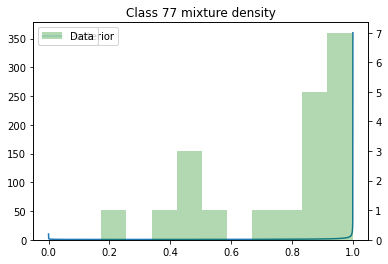

Quantile: 0.9950
Class 78
min_alpha, max_alpha: 0.10050251256281408 1.6080402010050252
min_beta, max_beta: 0.08040201005025126 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 0.4623115577889447 0.22110552763819097
Expected acceptance probability: 0.06927733670974767
*** Accept rate ***: 7.40%
[ 103.26078447    9.11324662    6.12445707 ...   35.74722518   60.54477211
 1286.11365523]


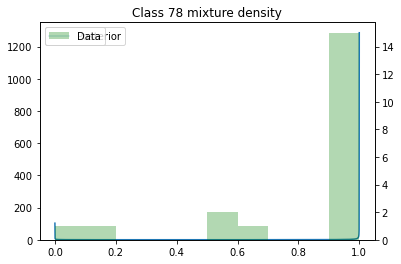

Quantile: 0.9995
Class 79
min_alpha, max_alpha: 0.10050251256281408 1.6884422110552764
min_beta, max_beta: 0.06030150753768844 0.4020100502512563
highest_prob_alpha, highest_prob_beta: 0.44221105527638194 0.16080402010050251
Expected acceptance probability: 0.06732942312582493
*** Accept rate ***: 7.00%
[  66.78906496    6.10376519    4.11843509 ...   43.3390018    75.67564147
 1900.69364895]


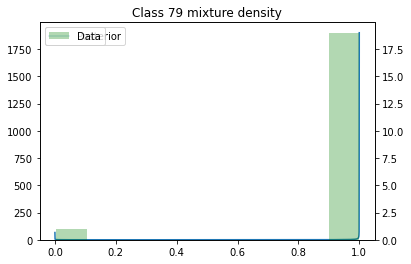

Quantile: 1.0000
Class 80
min_alpha, max_alpha: 0.06030150753768844 0.7839195979899498
min_beta, max_beta: 0.08040201005025126 0.5628140703517588
highest_prob_alpha, highest_prob_beta: 0.24120603015075376 0.22110552763819097
Expected acceptance probability: 0.05884722203509825
*** Accept rate ***: 6.52%
[688.12174802  35.18020713  21.12835956 ...  25.29270512  42.62176032
 879.62072787]


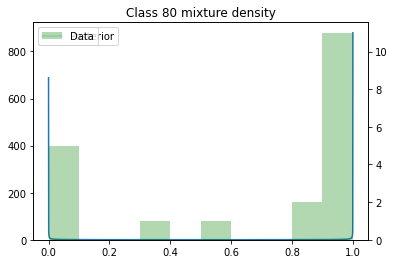

Quantile: 0.8359
Class 81
min_alpha, max_alpha: 0.18090452261306533 1.7085427135678393
min_beta, max_beta: 0.10050251256281408 0.5226130653266332
highest_prob_alpha, highest_prob_beta: 1.4673366834170853 0.2613065326633166
Expected acceptance probability: 0.02793957983806211


KeyboardInterrupt: 

In [83]:
quantiles = np.zeros((num_classes,))

for k in range(num_classes):
    print(f"Class {k}")

    # Target density (computed on grid)
    prob, density = compute_prob_on_grid(k, positions, D, xmin, xmax, ymin, ymax, scores_subset)
    
    # Determine appropriate sampling distribution
    min_alpha, max_alpha, min_beta, max_beta = truncate_density(X,Y,density, threshold=threshold)
    scaling_factor = compute_scaling_factor(prob, positions, min_alpha, max_alpha, min_beta, max_beta)
    sampling_density = scaled_uniform_density(X,Y, 
                                              min_alpha, max_alpha, min_beta, max_beta, 
                                              scaling_factor=scaling_factor)
    expected_accept_prob = np.sum(density) / np.sum(sampling_density)
    print("Expected acceptance probability:", expected_accept_prob)
    
    
    # Target density (as a function)
    disc_target_density = lambda xnew, ynew : get_discretized_density(xnew, ynew, X, Y, prob)
    
    # Generate samples
    samples = generate_n_samples(num_samples, 
                                 min_alpha, max_alpha, min_beta, max_beta, 
                                 scaling_factor, 
                                 disc_target_density)
    
    # Estimate integral using samples
    #    Note: This integral is actually a function that is a mixture of Betas,
    #    so we will return a discretized version of it
    mixture_density = np.zeros(mixture_grid.shape)
    for i in range(len(samples)):
#         print(samples[i,0], samples[i,1])
        mixture_density += beta.pdf(mixture_grid, samples[i,0], samples[i,1])
        
    mixture_density /= num_samples # Renormalize 
    
    # Plot
    print(mixture_density)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(mixture_grid, mixture_density, label='Posterior')
    ax2.hist(scores_subset[k*n:(k+1)*n], label='Data', alpha=0.3, color='green')
    ax1.set_ylim(bottom=0)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_title(f'Class {k} mixture density')
    plt.show()
    
    # Compute quantile
    quantile = get_quantile(mixture_density, mixture_grid, alpha)
    print(f"Quantile: {quantile:.4f}")
    quantiles[k] = quantile
    
    

Hmmm... It keeps estimating quantiles of 0.0000 or 1.0000. I tried increasing the number of rejection sampling samples to 10000 (from 1000) but that didn't help.

Is the prior too strong? Let's try to understand $D$ better by sampling $(\alpha, \beta)$ pairs and plotting the corresponding Beta distribution

[[0.32201032]
 [0.41549571]]
[[0.31338835]
 [0.28310305]]
[[0.72807759]
 [0.51185161]]
[[0.20683415]
 [0.4140133 ]]
[[-0.06225046]
 [ 0.48593316]]
[[0.17465508]
 [0.58763027]]
[[0.37860661]
 [0.87820711]]
[[0.17036478]
 [0.43753747]]
[[0.22999301]
 [0.68040594]]
[[0.114001 ]
 [0.3850248]]
[[0.0965352]
 [0.6306758]]
[[0.47369635]
 [0.32336101]]
[[0.28153949]
 [0.64228768]]
[[0.36558981]
 [0.38815088]]
[[0.29093393]
 [0.25952193]]
[[0.08457   ]
 [0.40066484]]
[[-0.02206162]
 [ 0.27573819]]
[[0.06383928]
 [0.39575533]]
[[0.11816677]
 [0.40571556]]
[[0.20437358]
 [0.54053358]]
[[0.20230743]
 [0.24130793]]
[[0.57306349]
 [0.58646378]]
[[0.12094976]
 [0.38901972]]
[[0.17236635]
 [0.70965671]]
[[-0.00623636]
 [ 0.91861388]]
[[0.21835221]
 [0.55681841]]
[[0.05419616]
 [0.43478617]]
[[0.19050977]
 [1.43370246]]
[[0.05044701]
 [0.81240598]]
[[0.22280783]
 [0.41316951]]
[[0.26005751]
 [0.34712429]]
[[0.366591  ]
 [0.44770399]]
[[-0.07370687]
 [ 0.31851376]]
[[0.36336809]
 [0.45379533]]
[[0.089666

[[0.31099967]
 [0.46901452]]
[[0.44232303]
 [0.27605721]]
[[0.38095839]
 [0.50015962]]
[[0.71129903]
 [0.54961781]]
[[0.07387375]
 [0.5959178 ]]
[[0.17303379]
 [0.72784747]]
[[0.06139289]
 [0.27330292]]
[[0.18578305]
 [0.46894536]]
[[0.2864361 ]
 [0.34892945]]
[[0.19443991]
 [0.75954926]]
[[0.27998979]
 [0.36750187]]
[[0.725927]
 [0.510566]]
[[0.4249737 ]
 [0.62023565]]
[[0.19409999]
 [0.41657921]]
[[0.05765555]
 [0.28226635]]
[[0.07726975]
 [0.19862716]]
[[0.07296908]
 [0.40990942]]
[[0.72374104]
 [0.44647962]]
[[0.09895338]
 [0.23627578]]
[[0.15203581]
 [0.53320003]]
[[0.11319735]
 [0.62129485]]
[[0.14882798]
 [0.45256193]]
[[0.19171348]
 [0.35458491]]
[[0.24599887]
 [0.61807474]]
[[0.07689891]
 [0.44270793]]
[[0.1875874 ]
 [0.51456152]]
[[0.27193128]
 [0.29221087]]
[[0.18322431]
 [0.31078108]]
[[0.01716631]
 [0.42538682]]
[[-0.03066416]
 [ 0.26255431]]
[[0.27558468]
 [0.26827317]]
[[0.20057275]
 [0.41352532]]
[[0.10083131]
 [0.69246557]]
[[0.54605971]
 [0.49653913]]
[[0.00144818]
 [

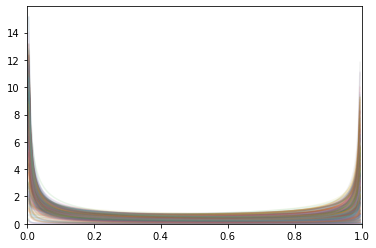

In [94]:
N = 500
plt.figure(figsize=(6,4))
xs = np.linspace(0,1,200)
for i in range(N):
    sample = kde.resample(size=(1,))
    print(sample)
    beta_density = beta.pdf(xs, sample[0], sample[1])
    plt.plot(xs, beta_density, alpha=0.1)

plt.xlim(0,1)
plt.ylim(bottom=0)
plt.show()

In [91]:
kde.resample(size=(1,))

array([[0.24105882],
       [0.4388471 ]])

In [ ]:
density

In [ ]:
plt.plot(mixture_grid, mixture_density)

In [ ]:
grid = mixture_grid
grid_width = grid[1] - grid[0]
sums = np.cumsum(density) * grid_width
# min_idx = np.argwhere(sums >= 1 - alpha)[0,0]

sums

## 2. Estimate quantiles

Let $f(x; \alpha, \beta) := \frac{1}{B(\alpha,\beta)}x^{\alpha-1}(1-x)^{\beta-1}$ denote the probability density function of $Beta(\alpha, \beta)$. Let $D(\alpha, \beta)$ denote the prior distribution of the Beta distribution parameters $\alpha$ and $\beta$. 

The distribution of an arbitrary score $s_{k,new}$ for class $k$ is a mixture of Betas:
$$p(s_{k,new}) = \int_0^{\infty} \int_0^{\infty} f(s_{k,new}; \alpha_k, \beta_k) p(\alpha_k, \beta_k | s_k, D) d\alpha_k d\beta_k$$


First, let's figure out how to sample from $p(\alpha_k, \beta_k | s_k, D)$

**Step 1**: Plot $p(\alpha_k, \beta_k | s_k, D)\propto \prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k) D(\alpha, \beta)$

Let's first check if this works for a single class 

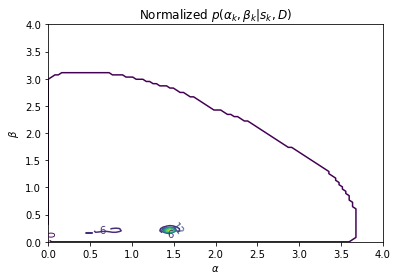

In [147]:
CS = plt.contour(X,Y,density)
plt.clabel(CS, fontsize=10)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('Normalized $p(\\alpha_k, \\beta_k | s_k, D)$')
# plt.ylim(0, 0.6)
# plt.xlim(0, 0.6)
plt.show()

Find smallest and largest alpha and beta values for which the density is above some chosen threshold

min_alpha, max_alpha: 0.12121212121212122 1.696969696969697
min_beta, max_beta: 0.08080808080808081 0.4040404040404041


highest_prob_alpha, highest_prob_beta: 1.4545454545454546 0.20202020202020204


Scaling factor: 91.44067354132706


In [171]:
# # Check if there are any grid points where rescaled sampling density does not cover target
# print(np.sum(rescaled_sampling_density < density)) # Want this to be 0

# idx = np.argwhere(rescaled_sampling_density < density)
# # print(rescaled_sampling_density[idx])
# # print(density[idx])

# plt.scatter(X[idx[:,0], idx[:,1]], Y[idx[:,0], idx[:,1]], alpha=0.2)
# plt.scatter(highest_prob_alpha, highest_prob_beta, label='Mean', color='red')
# plt.xlim(0,4)
# plt.ylim(0,4)
# plt.legend()
# plt.show()

Expected acceptance probability: 0.03727639565582394


Now that we've identified an appropriate sampling distribution, we can carry out the actual rejection sampling to get samples from $p(\alpha_k, \beta_k | s_k, D)$

[1.19025916 0.30018082]

Accept prob 6.405558767607217e-06
[0.1477422  0.18446453]

Accept prob 6.41855450114285e-05
[1.59783025 0.1821993 ]

Accept prob 0.01593814932060253
[1.55147025 0.38948673]

Accept prob 7.524371998406696e-06
[0.42980025 0.36490011]

Accept prob 1.7345179925121244e-05
[0.68657766 0.34354909]

Accept prob 0.0002529895548809914
[0.15739698 0.18982486]

Accept prob 6.41855450114285e-05
[0.15988892 0.4014347 ]

Accept prob 3.705084326274085e-12
[0.47367787 0.25675153]

Accept prob 0.02916777399083435
[0.82350701 0.30577132]

Accept prob 0.006703432731695639
[0.5133516 0.1486011]

Accept prob 0.12903502284410817
[1.52113954 0.16280823]

Accept prob 0.10268571973053196
[1.0277302  0.20418503]

Accept prob 0.005694129771796302
[0.46227304 0.19040263]

Accept prob 0.07568854693748335
[1.24038552 0.36147308]

Accept prob 9.153415853511063e-07
[0.7190146  0.10813226]

Accept prob 0.006275364417797539
[0.83724378 0.23843184]

Accept prob 0.1345953673223279
[0.21073366 0.08


Accept prob 0.003681264626846927
[0.90344613 0.37412106]

Accept prob 0.0007982052282905172
[0.25228409 0.35193827]

Accept prob 3.659534768138741e-08
[0.57024062 0.28743428]

Accept prob 0.009569817304342101
[0.49119505 0.15930964]

Accept prob 0.13498467830256897
[0.76024379 0.21193789]

Accept prob 0.20382943818726798
[1.41035667 0.13517242]

Accept prob 0.01541805320430898
[1.39432102 0.08207516]

Accept prob 4.614135213404331e-05
[0.54443505 0.26382751]

Accept prob 0.007095893736342689
[0.46304941 0.32635111]

Accept prob 0.0002800143400002276
[0.71998861 0.27515648]

Accept prob 0.02850748000237575
[1.09558547 0.18737795]

Accept prob 0.00018039700058988171
[0.16948547 0.32617477]

Accept prob 9.192850144237123e-09
[1.56786318 0.32386288]

Accept prob 0.0026309202323285055
[1.0019231  0.11568172]

Accept prob 2.5550833336538668e-05
[1.51314368 0.29562003]

Accept prob 0.16000646557195644
[1.59951767 0.20030606]

Accept prob 0.01593814932060253
[0.34675861 0.11984088]

Accept pr

[1.38141414 0.08610506]

Accept prob 2.639831633323047e-05
[1.47033791 0.19872325]

Accept prob 1.0
ACCEPTED sample
[1.1304244  0.26938622]

Accept prob 4.88710962775524e-05
[0.24159393 0.23539737]

Accept prob 0.00034602929798367244
[1.45363482 0.17958064]

Accept prob 0.3298856010191161
ACCEPTED sample
[1.18414855 0.08183013]

Accept prob 9.8808134256593e-10
[0.72604175 0.25049679]

Accept prob 0.10735980525593042
[0.62110652 0.30483453]

Accept prob 0.0014265947554302628
[1.62771453 0.33839192]

Accept prob 0.0005025228807280404
[0.42835276 0.34556129]

Accept prob 1.7345179925121244e-05
[0.87108705 0.17814792]

Accept prob 0.030959486677377936
[0.73482093 0.32507358]

Accept prob 0.0040271922369947465
[1.30280162 0.2283736 ]

Accept prob 0.014516045977643909
[0.55049257 0.35659788]

Accept prob 7.700471799137581e-05
[0.30790393 0.26663576]

Accept prob 0.0002863437870147136
[0.63518286 0.19580631]

Accept prob 0.1465984437520094
ACCEPTED sample
[0.70095921 0.2004883 ]

Accept prob 


Accept prob 0.01541236296753365
[0.64239214 0.38953376]

Accept prob 1.0522701729754803e-05
[1.46748147 0.16370907]

Accept prob 0.3298856010191161
[0.7520345  0.30696054]

Accept prob 0.005435055543692755
[1.52227089 0.33798435]

Accept prob 0.00838119542505112
[1.12396525 0.24608865]

Accept prob 4.22552200088234e-05
[0.33948264 0.33241881]

Accept prob 1.7622022661464385e-05
[0.77331985 0.19840649]

Accept prob 0.20382943818726798
[1.48003263 0.18796915]

Accept prob 0.7467802294187187
ACCEPTED sample
[0.91425919 0.14252978]

Accept prob 0.011992155225829025
[0.97862135 0.24433042]

Accept prob 0.027651888647681033
[1.43421053 0.37630413]

Accept prob 0.0005399320691055076
[0.34496103 0.09254637]

Accept prob 0.0008667201101256345
[1.15584956 0.38314075]

Accept prob 6.216624646784306e-06
[0.91738029 0.26029688]

Accept prob 0.056946426442360226
[1.19462001 0.18128879]

Accept prob 7.531337378141514e-05
[1.64237513 0.15481253]

Accept prob 0.00043791555901080925
[1.69081874 0.26077


Accept prob 0.137640122069487
[1.12332642 0.39959484]

Accept prob 8.70329317081659e-06
[1.10495811 0.13253619]

Accept prob 4.433015429964135e-07
[0.90999053 0.27333163]

Accept prob 0.026132328433354734
[1.65360244 0.36373634]

Accept prob 2.9332386448378957e-06
[1.59943261 0.19337314]

Accept prob 0.01593814932060253
[0.34516125 0.21686976]

Accept prob 0.030243159369471685
[0.87776332 0.36997163]

Accept prob 0.0007982052282905172
[1.33812054 0.33335515]

Accept prob 0.0015729506262489748
[1.0877935  0.21472679]

Accept prob 0.00018039700058988171
[0.82370349 0.18314652]

Accept prob 0.2127843774557835
[0.16424641 0.40352164]

Accept prob 3.705084326274085e-12
[0.78551022 0.12663627]

Accept prob 0.007145479098102782
[0.85174995 0.34101047]

Accept prob 0.007113243238835963
[1.39143608 0.34959591]

Accept prob 0.00022500778857728843
[0.17523502 0.10592448]

Accept prob 0.0004612970863200012
[1.48250171 0.35442498]

Accept prob 0.0006956407547196392
[0.35757639 0.10069866]

Accept 


Accept prob 0.00037324278514569437
[0.52195423 0.0845853 ]

Accept prob 0.0007563621947034164
[1.34606684 0.13124372]

Accept prob 0.0027956062064677
[1.62868242 0.1371645 ]

Accept prob 0.0001941825568214277
[1.51370958 0.27387442]

Accept prob 0.16000646557195644
[1.36520047 0.31279526]

Accept prob 0.005957486659946851
[1.66033272 0.36831009]

Accept prob 2.9332386448378957e-06
[0.19213133 0.21303937]

Accept prob 0.0005708825006216271
[1.51702775 0.18732205]

Accept prob 0.3398194415442934
[1.14674061 0.08846596]

Accept prob 6.441922657935271e-11
[0.36766188 0.2964802 ]

Accept prob 0.0007139199219077316
[0.27163159 0.35836048]

Accept prob 1.9086050731471945e-07
[1.14387631 0.25167378]

Accept prob 4.22552200088234e-05
[1.40350299 0.14961892]

Accept prob 0.2815181866423507
ACCEPTED sample
[0.26455422 0.27659759]

Accept prob 9.857769125236126e-05
[1.60838973 0.26614586]

Accept prob 0.004383326442417114
[1.00055237 0.1306527 ]

Accept prob 2.5550833336538668e-05
[1.07680116 0.1


Accept prob 0.00044104531713511715
[0.30527251 0.27528856]

Accept prob 0.0002863437870147136
[0.64457925 0.29186245]

Accept prob 0.01754118301245273
[1.04549493 0.23745723]

Accept prob 0.002515037334144266
[0.16170501 0.31442777]

Accept prob 9.192850144237123e-09
[1.29925732 0.08567901]

Accept prob 1.9672344876807623e-06
[1.36934579 0.20144865]

Accept prob 0.40516960754032294
[0.89215909 0.38545958]

Accept prob 7.274734994355428e-05
[0.24659869 0.3738982 ]

Accept prob 3.659534768138741e-08
[0.13320325 0.30532288]

Accept prob 1.472977189185635e-10
[0.76318604 0.27320439]

Accept prob 0.036798638629656384
[1.61468212 0.08306777]

Accept prob 4.635438898242774e-07
[0.57438169 0.19971207]

Accept prob 0.137640122069487
[0.63112076 0.13932608]

Accept prob 0.009962209604928291
[1.37088487 0.32815289]

Accept prob 0.005957486659946851
[1.32071114 0.34217908]

Accept prob 0.0015729506262489748
[1.52965976 0.12139165]

Accept prob 0.004911055819169332
[0.90028623 0.13705399]

Accept 


Accept prob 0.036798638629656384
[1.66093119 0.11389881]

Accept prob 1.842615365655891e-05
[1.55158356 0.11884241]

Accept prob 0.004911055819169332
[0.5629064  0.23333164]

Accept prob 0.053094604665504
[1.04916215 0.26609813]

Accept prob 0.0018747183349459107
[1.10111166 0.38181025]

Accept prob 7.826724354416917e-05
[1.39295243 0.11981123]

Accept prob 0.00840624232837937
[0.76398043 0.26380375]

Accept prob 0.036798638629656384
[0.78256324 0.28817947]

Accept prob 0.036798638629656384
[0.70651002 0.16406298]

Accept prob 0.07077418258752438
[1.38419036 0.24075813]

Accept prob 0.286467801398645
[1.44738154 0.09617761]

Accept prob 4.925833925705659e-05
[0.56360776 0.3089958 ]

Accept prob 0.0010202862879008455
[0.49197021 0.15811719]

Accept prob 0.13498467830256897
[0.98346418 0.38673821]

Accept prob 6.983637208884173e-05
[1.56796283 0.24719874]

Accept prob 0.08283089157287436
[1.64526291 0.2424238 ]

Accept prob 0.0015675997987760028
[1.31862751 0.37676441]

Accept prob 5.68


Accept prob 0.0015476773893409047
[1.2959613  0.36261076]

Accept prob 8.72450990187689e-06
[0.58354046 0.27473679]

Accept prob 0.009569817304342101
[1.28009945 0.25581647]

Accept prob 0.014516045977643909
[0.39481276 0.17162993]

Accept prob 0.09615325422899448
[0.20672215 0.17305377]

Accept prob 0.0021126241609207303
[0.63084349 0.29389251]

Accept prob 0.01754118301245273
[1.07572247 0.2081725 ]

Accept prob 0.00018039700058988171
[1.40918913 0.26932076]

Accept prob 0.14688241101507138
[1.03720343 0.16919524]

Accept prob 0.00016891468749311446
[0.30179485 0.20119027]

Accept prob 0.006848230060116315
[1.3509164  0.16411689]

Accept prob 0.04640759139999283
[1.41738142 0.29306675]

Accept prob 0.14688241101507138
[1.69086596 0.08688157]

Accept prob 2.3425054159177788e-09
[1.11696958 0.16305415]

Accept prob 1.931054240092553e-06
[0.17468897 0.37461733]

Accept prob 2.080512110834878e-10
[0.13080365 0.16018092]

Accept prob 1.5821875648802125e-05
[0.5048991  0.39885771]

Accept


Accept prob 0.0005708825006216271
[0.4494367  0.18941824]

Accept prob 0.07568854693748335
[0.46554258 0.32927865]

Accept prob 0.0004999355821367153
[1.5154507  0.40144296]

Accept prob 7.524371998406696e-06
[0.53239206 0.09228083]

Accept prob 0.0007563621947034164
[0.48576862 0.09763243]

Accept prob 0.001339505244455833
[0.77913153 0.10290139]

Accept prob 0.007145479098102782
[0.76460554 0.18218619]

Accept prob 0.20382943818726798
[1.53963834 0.24408467]

Accept prob 0.28637405624345064
[1.61373431 0.39078397]

Accept prob 5.281333282304737e-07
[1.20815027 0.3388212 ]

Accept prob 2.5785446862508946e-06
[0.54487417 0.23984206]

Accept prob 0.04051685365798617
[0.48029936 0.11139417]

Accept prob 0.048873609853269384
[1.43430377 0.26475596]

Accept prob 0.14688241101507138
[0.53323856 0.28634447]

Accept prob 0.007095893736342689
[0.43375592 0.39289904]

Accept prob 7.19962328162086e-07
[0.37866656 0.34510212]

Accept prob 2.4895752571565437e-06
[1.28006833 0.08795787]

Accept pr

[0.85742944 0.22605761]

Accept prob 0.1345953673223279
[1.31183536 0.12524182]

Accept prob 0.0005669296232861632
[0.26790794 0.18731944]

Accept prob 0.006848230060116315
[0.64545615 0.38275508]

Accept prob 0.00016907101748296456
[0.3451149  0.34803615]

Accept prob 2.4895752571565437e-06
[0.91610542 0.2402069 ]

Accept prob 0.056946426442360226
[1.38309081 0.21942053]

Accept prob 0.40516960754032294
[1.15211962 0.32735394]

Accept prob 7.983652482271839e-06
[0.82829217 0.38226212]

Accept prob 0.0007868509590572305
[0.38755575 0.11848328]

Accept prob 0.04223473285739593
ACCEPTED sample
[1.49555419 0.14700021]

Accept prob 0.2356818674773496
[0.18044176 0.09026556]

Accept prob 7.307950875112247e-05
[1.2262255  0.10405749]

Accept prob 5.2797548005772235e-06
[1.65413873 0.2736416 ]

Accept prob 0.0004899428725553555
[0.84055014 0.14151751]

Accept prob 0.06087489819979644
[1.4772285 0.2724112]

Accept prob 0.16000646557195644
ACCEPTED sample
[1.04927981 0.27167167]

Accept prob 0.


Accept prob 0.0004055171650360637
[0.51533891 0.12351006]

Accept prob 0.03521501542715207
[0.43910465 0.34577556]

Accept prob 1.7345179925121244e-05
[1.17112938 0.33463367]

Accept prob 7.983652482271839e-06
[1.19149557 0.11858534]

Accept prob 2.439357916882993e-07
[1.08714066 0.27934535]

Accept prob 0.0003561929485988002
[1.39114344 0.39569947]

Accept prob 3.844311481276139e-06
[1.25617179 0.21902797]

Accept prob 0.002521272948879968
[1.04853658 0.10974209]

Accept prob 3.923073443531439e-06
[1.63806247 0.28065625]

Accept prob 0.0004899428725553555
[0.62220979 0.31113375]

Accept prob 0.0014265947554302628
[1.24056844 0.24626411]

Accept prob 0.0015476773893409047
[0.61255608 0.25162415]

Accept prob 0.06568555045333127
[1.25388371 0.32624091]

Accept prob 2.4585189081568595e-05
[1.01804888 0.37885462]

Accept prob 0.0003880672163317129
[1.40935117 0.34377922]

Accept prob 0.0005399320691055076
[1.63465512 0.24696723]

Accept prob 0.014596627287010583
[0.13544238 0.16637633]




Accept prob 3.3741092594978053e-06
[0.89304602 0.09317829]

Accept prob 5.32928780951966e-06
[0.48717189 0.09938687]

Accept prob 0.001339505244455833
[0.2609759  0.14366532]

Accept prob 0.007173896441256112
[0.41755929 0.34477611]

Accept prob 7.213402752394836e-06
[1.44301553 0.24964562]

Accept prob 0.7731790917876064
ACCEPTED sample
[1.61958011 0.40400743]

Accept prob 5.281333282304737e-07
[1.32575832 0.13662581]

Accept prob 0.0027956062064677
[1.32329738 0.16118683]

Accept prob 0.04640759139999283
[0.79148766 0.21655602]

Accept prob 0.2127843774557835
ACCEPTED sample
[1.57802054 0.35407318]

Accept prob 0.0001221498998159219
[1.08465498 0.25197707]

Accept prob 0.0004055171650360637
[0.1234223  0.35212169]

Accept prob 2.8111975849819174e-12
[1.27272947 0.23968633]

Accept prob 0.014516045977643909
[0.33558616 0.39198962]

Accept prob 2.3342672503919528e-08
[0.87676753 0.08209179]

Accept prob 5.32928780951966e-06
[0.55125541 0.33847757]

Accept prob 0.0010202862879008455
[1


Accept prob 0.005694129771796302
[0.87207789 0.1788897 ]

Accept prob 0.030959486677377936
[1.45363149 0.3010245 ]

Accept prob 0.1965800189442381
[0.78392119 0.28388851]

Accept prob 0.036798638629656384
[0.44814409 0.1968336 ]

Accept prob 0.07568854693748335
[1.4664838  0.15629862]

Accept prob 0.3298856010191161
ACCEPTED sample
[0.68063546 0.28438105]

Accept prob 0.02262863956009548
[0.76877264 0.34884768]

Accept prob 0.0005358292000212783
[1.15455723 0.2386276 ]

Accept prob 6.963463686615919e-06
[0.19892944 0.21302223]

Accept prob 0.0005708825006216271
[0.21877869 0.32250786]

Accept prob 1.562329091988268e-07
[0.70713884 0.36227291]

Accept prob 0.00037324278514569437
[0.23986509 0.2483129 ]

Accept prob 0.00034602929798367244
[0.83044309 0.11987803]

Accept prob 0.0038416854209469145
[1.34890503 0.20678557]

Accept prob 0.12250309684762481
[1.42168048 0.22327227]

Accept prob 0.6033676908844985
[0.9307611  0.13223751]

Accept prob 0.0005334555283155266
[0.6196389  0.2924929


Accept prob 0.07568854693748335
[0.85808242 0.37525523]

Accept prob 0.0007868509590572305
[1.65552779 0.2590464 ]

Accept prob 0.0015675997987760028
[0.12936964 0.13581519]

Accept prob 3.7154188228244525e-05
[1.63643006 0.13391695]

Accept prob 1.842615365655891e-05
[0.6329796  0.36455791]

Accept prob 0.00016907101748296456
[0.38449031 0.29764889]

Accept prob 0.0015661901569131052
[1.09126123 0.22101843]

Accept prob 0.00018039700058988171
[0.7893888 0.2368773]

Accept prob 0.15092214482021477
[1.66799775 0.20067961]

Accept prob 0.00164358263040904
[0.8078681 0.1060952]

Accept prob 0.006280680020012483
[0.89193763 0.35270672]

Accept prob 0.0007982052282905172
[1.15484499 0.14847127]

Accept prob 3.3741092594978053e-06
[1.43850133 0.33838211]

Accept prob 0.019132611034665813
[0.80010428 0.17222999]

Accept prob 0.08759067991380488
[0.60867339 0.32405866]

Accept prob 0.0014265947554302628
[0.90938021 0.08543369]

Accept prob 1.4320965470886415e-06
[1.07926193 0.14978436]

Accep


Accept prob 4.925833925705659e-05
[1.40693314 0.29484843]

Accept prob 0.14688241101507138
[0.25603414 0.17300325]

Accept prob 0.007173896441256112
[0.42591805 0.10833774]

Accept prob 0.05355536895223771
[0.76217889 0.24687254]

Accept prob 0.13479714474269422
ACCEPTED sample
[0.13574391 0.21773138]

Accept prob 2.196569876392403e-06
[1.29529246 0.25370275]

Accept prob 0.014516045977643909
[0.73427887 0.24051922]

Accept prob 0.10735980525593042
[1.024837   0.23283606]

Accept prob 0.01009104262672689
[0.25053096 0.33854849]

Accept prob 1.1729896363418323e-06
[0.67323555 0.3059832 ]

Accept prob 0.002962288047407304
[1.21039418 0.1052561 ]

Accept prob 5.2797548005772235e-06
[0.22190956 0.35077833]

Accept prob 4.162025052297628e-09
[1.50813893 0.34789908]

Accept prob 0.0006956407547196392
[0.60650813 0.29962103]

Accept prob 0.01286365921992471
[1.00381307 0.19461707]

Accept prob 0.005694129771796302
[0.98633516 0.32707384]

Accept prob 0.00396884843651303
[0.323582   0.1482414


Accept prob 4.162025052297628e-09
[0.99530375 0.26311081]

Accept prob 0.006568149388803449
[1.36317004 0.1674078 ]

Accept prob 0.1464294679736277
ACCEPTED sample
[1.41789406 0.28506532]

Accept prob 0.14688241101507138
[0.70605984 0.0875738 ]

Accept prob 3.7049228009707114e-05
[0.77150869 0.14470781]

Accept prob 0.09109152404060784
[0.9497406  0.12088331]

Accept prob 0.00013109609344445113
[0.64248109 0.09930775]

Accept prob 7.708942362171292e-05
[0.40934445 0.14829387]

Accept prob 0.09615325422899448
[0.40920977 0.15888586]

Accept prob 0.09615325422899448
[0.86546323 0.11295101]

Accept prob 0.0038416854209469145
[0.36236719 0.36581909]

Accept prob 2.4895752571565437e-06
[0.72701456 0.27760027]

Accept prob 0.02850748000237575
[0.93576248 0.34737944]

Accept prob 0.0007504543869987095
[0.75303859 0.25214426]

Accept prob 0.13479714474269422
[1.11312013 0.26194836]

Accept prob 4.22552200088234e-05
[0.95286704 0.30530712]

Accept prob 0.00396884843651303
[1.56370255 0.3572261


Accept prob 0.00010262459176313685
[1.3789824  0.32569871]

Accept prob 0.005957486659946851
[0.27594562 0.1439635 ]

Accept prob 0.016127113753660213
[0.25421778 0.27054944]

Accept prob 2.5650706681365823e-05
[0.42181763 0.36545579]

Accept prob 7.213402752394836e-06
[0.5735666  0.16011226]

Accept prob 0.12443128057845898
[0.9046638  0.20039149]

Accept prob 0.10109839993596897
[1.25476757 0.25031946]

Accept prob 0.0015476773893409047
[1.25652782 0.13836499]

Accept prob 7.008493281519557e-05
[0.35089644 0.08222319]

Accept prob 0.0008667201101256345
[1.2056965  0.39192575]

Accept prob 4.2276453308377043e-07
[0.68575292 0.3843503 ]

Accept prob 1.6083275859694362e-05
[1.45428224 0.11625521]

Accept prob 0.01725318685419885
[0.86658491 0.19630653]

Accept prob 0.16812045498948777
[0.21481731 0.11287196]

Accept prob 0.0021396024408572617
[1.23394555 0.31888447]

Accept prob 2.4585189081568595e-05
[1.30264251 0.21533833]

Accept prob 0.02253599938922132
[0.93574548 0.36129606]

Acc


Accept prob 0.002890964776014909
[0.91652528 0.17007718]

Accept prob 0.011992155225829025
[1.44447902 0.16001382]

Accept prob 0.3298856010191161
[0.46339244 0.38870702]

Accept prob 7.19962328162086e-07
[0.37121572 0.30924778]

Accept prob 5.099870941550722e-05
[1.07474105 0.32282079]

Accept prob 0.0001877465144515661
[1.58075258 0.1387824 ]

Accept prob 0.0012497208891505461
[1.37029123 0.36047953]

Accept prob 0.00022500778857728843
[0.23089226 0.25955412]

Accept prob 0.00034602929798367244
[0.50792537 0.14271575]

Accept prob 0.12903502284410817
[1.69157902 0.11214179]

Accept prob 1.067945118401407e-06
[0.51700886 0.28330389]

Accept prob 0.007095893736342689
[1.00969186 0.10747564]

Accept prob 2.5550833336538668e-05
[1.50244337 0.12466293]

Accept prob 0.01178205349690435
[1.44528204 0.24400594]

Accept prob 0.7731790917876064
[1.44082592 0.08647535]

Accept prob 4.925833925705659e-05
[1.24033905 0.35503254]

Accept prob 9.153415853511063e-07
[0.24684498 0.12523362]

Accept 


Accept prob 1.9961221160127444e-05
[0.87652502 0.15127051]

Accept prob 0.030959486677377936
[0.14353723 0.26205821]

Accept prob 5.765628016162438e-06
[1.17924637 0.09283162]

Accept prob 9.8808134256593e-10
[1.64589086 0.29793811]

Accept prob 0.0004899428725553555
[1.565195   0.34502481]

Accept prob 0.0001221498998159219
[1.0801019  0.26884701]

Accept prob 0.0003561929485988002
[0.53392725 0.36217638]

Accept prob 5.393486777566761e-05
[1.23262787 0.11050153]

Accept prob 7.008493281519557e-05
[1.11835374 0.1438592 ]

Accept prob 1.931054240092553e-06
[0.16939839 0.33276904]

Accept prob 9.192850144237123e-09
[0.71256175 0.16768609]

Accept prob 0.07631073954554744
[0.62057992 0.31457919]

Accept prob 0.0014265947554302628
[0.74636942 0.29747967]

Accept prob 0.02850748000237575
[0.71157001 0.26342479]

Accept prob 0.02850748000237575
[1.25741165 0.39252264]

Accept prob 5.887054709633709e-08
[0.88628374 0.17619433]

Accept prob 0.030959486677377936
[1.34398874 0.08361601]

Accep


Accept prob 1.7345179925121244e-05
[0.69049405 0.28620442]

Accept prob 0.02262863956009548
[1.36722749 0.1319093 ]

Accept prob 0.00840624232837937
[0.71072332 0.28141791]

Accept prob 0.02850748000237575
[0.42820433 0.12897193]

Accept prob 0.05355536895223771
[0.31995664 0.11732641]

Accept prob 0.014407156976033652
[0.53433045 0.23501829]

Accept prob 0.04051685365798617
[1.47815397 0.26158251]

Accept prob 0.6030376705705548
ACCEPTED sample
[0.93968883 0.11807362]

Accept prob 0.0005334555283155266
[0.84044923 0.30428542]

Accept prob 0.007113243238835963
[1.0354547  0.11991597]

Accept prob 3.923073443531439e-06
[1.56244931 0.11830469]

Accept prob 0.0012497208891505461
[0.25719508 0.40097402]

Accept prob 8.585116886379757e-10
[1.39287165 0.08167096]

Accept prob 2.639831633323047e-05
[1.65970955 0.11787958]

Accept prob 1.842615365655891e-05
[1.32407431 0.32509789]

Accept prob 0.0015729506262489748
[0.32614446 0.39200939]

Accept prob 2.3342672503919528e-08
[0.82962144 0.2839


Accept prob 0.0007868509590572305
[0.98578802 0.313524  ]

Accept prob 0.00396884843651303
[0.15486396 0.16769699]

Accept prob 0.00031787593764866733
[0.38725412 0.35825913]

Accept prob 7.213402752394836e-06
[0.6931687  0.12404483]

Accept prob 0.006385848228708156
[1.31564538 0.09488235]

Accept prob 9.222744416721094e-06
[0.18733348 0.18853239]

Accept prob 0.0005708825006216271
[0.51870535 0.38693295]

Accept prob 2.7242787247496506e-06
[0.29621199 0.39044193]

Accept prob 5.191426735095956e-09
[1.49932594 0.15620435]

Accept prob 0.2356818674773496
[1.60848591 0.23666413]

Accept prob 0.014596627287010583
[1.33395733 0.15917842]

Accept prob 0.04640759139999283
[0.3043464  0.35282548]

Accept prob 7.445555096931169e-07
[0.57836084 0.37812011]

Accept prob 7.700471799137581e-05
[0.83047751 0.11017892]

Accept prob 0.0038416854209469145
[0.19199244 0.18331227]

Accept prob 0.0005708825006216271
[1.21941697 0.09597052]

Accept prob 2.035116954370314e-08
[0.48149366 0.33460437]

Acc


Accept prob 0.00037388018856479116
[0.9213843  0.29935596]

Accept prob 0.026132328433354734
[1.61300227 0.12993609]

Accept prob 0.0001941825568214277
[1.26853876 0.35956532]

Accept prob 9.153415853511063e-07
[1.05110821 0.24182264]

Accept prob 0.002515037334144266
[1.30490252 0.17295879]

Accept prob 0.008958438756458893
[0.33462839 0.37508864]

Accept prob 7.445555096931169e-07
[0.24407739 0.25490108]

Accept prob 0.00034602929798367244
[1.18634894 0.33504462]

Accept prob 7.983652482271839e-06
[1.58734299 0.24358146]

Accept prob 0.08283089157287436
[0.58006442 0.24907799]

Accept prob 0.053094604665504
[0.35420575 0.38208997]

Accept prob 2.4895752571565437e-06
[1.3932099  0.28181046]

Accept prob 0.0667165462799509
[0.70407423 0.1105089 ]

Accept prob 0.006385848228708156
[1.62502815 0.38846513]

Accept prob 5.281333282304737e-07
[0.52599793 0.15773461]

Accept prob 0.12903502284410817
[0.75878045 0.22269869]

Accept prob 0.13479714474269422
ACCEPTED sample
[0.41025074 0.25142


Accept prob 0.2127843774557835
ACCEPTED sample
[1.21097511 0.36360877]

Accept prob 1.061357357508359e-06
[1.2539308  0.20455636]

Accept prob 0.002521272948879968
[0.89594055 0.29654177]

Accept prob 0.03594924012489592
[1.30140778 0.12095858]

Accept prob 0.0005669296232861632
[0.4086934  0.22916716]

Accept prob 0.012080360102952367
[1.18566581 0.11867599]

Accept prob 2.439357916882993e-07
[1.47648593 0.20663352]

Accept prob 0.7467802294187187
ACCEPTED sample
[0.62573359 0.08319015]

Accept prob 0.00017143144951560176
[1.05932543 0.35711081]

Accept prob 0.00019297085922783273
[1.59962953 0.34391986]

Accept prob 2.42685561609854e-05
[1.65966311 0.35758024]

Accept prob 2.9332386448378957e-06
[0.24830904 0.13598752]

Accept prob 0.005378108369151492
[1.47486429 0.31715226]

Accept prob 0.01624005741916239
[0.81375664 0.36628544]

Accept prob 0.0006967661984949446
[0.99573487 0.366912  ]

Accept prob 0.0003880672163317129
[1.15050852 0.38942554]

Accept prob 8.70329317081659e-06
[


Accept prob 1.931054240092553e-06
[0.22020761 0.18298652]

Accept prob 0.0005708825006216271
[0.86501267 0.30979714]

Accept prob 0.007113243238835963
[0.61741661 0.27058433]

Accept prob 0.01286365921992471
[1.15337691 0.29185185]

Accept prob 6.405558767607217e-06
[0.85049213 0.35772652]

Accept prob 0.0007868509590572305
[1.4414894  0.33039149]

Accept prob 0.019132611034665813
[0.14102662 0.15105363]

Accept prob 1.5821875648802125e-05
[0.44035805 0.23334566]

Accept prob 0.019831097288763783
ACCEPTED sample
[1.33547245 0.21470665]

Accept prob 0.12250309684762481
[1.03323147 0.1067506 ]

Accept prob 3.923073443531439e-06
[0.25797376 0.15743114]

Accept prob 0.007173896441256112
[1.31111944 0.31280667]

Accept prob 0.0002519867843275081
[0.61837161 0.2172111 ]

Accept prob 0.1485738017332301
[0.78952032 0.37595608]

Accept prob 0.0006967661984949446
[1.11735812 0.22013902]

Accept prob 1.6775058128929612e-05
[0.91708235 0.37318531]

Accept prob 0.0007504543869987095
[0.60034717 0.


Accept prob 0.006715250818298852
[1.36688006 0.24254627]

Accept prob 0.286467801398645
[1.68725221 0.23816007]

Accept prob 0.00010262459176313685
[1.45974748 0.15374208]

Accept prob 0.3298856010191161
[1.38650953 0.11268138]

Accept prob 0.00840624232837937
[0.59111193 0.20225601]

Accept prob 0.1485738017332301
[1.18012015 0.19999634]

Accept prob 8.047910318099192e-06
[0.87406342 0.08432754]

Accept prob 5.32928780951966e-06
[0.46799856 0.23748882]

Accept prob 0.02916777399083435
[1.41717882 0.11868534]

Accept prob 0.01541805320430898
[1.59841864 0.18589156]

Accept prob 0.01593814932060253
[0.53964652 0.39756417]

Accept prob 2.7242787247496506e-06
[0.90698945 0.17900695]

Accept prob 0.030959486677377936
[1.26444695 0.36312528]

Accept prob 9.153415853511063e-07
[0.15746757 0.30750524]

Accept prob 9.192850144237123e-09
[0.57244888 0.22771083]

Accept prob 0.053094604665504
[1.46071201 0.11697782]

Accept prob 0.01725318685419885
[0.50704193 0.15321568]

Accept prob 0.1290350


Accept prob 1.398374792952694e-07
[0.68467619 0.37803462]

Accept prob 0.0002529895548809914
[1.30933208 0.37057488]

Accept prob 8.72450990187689e-06
[0.45357292 0.11018545]

Accept prob 0.05355536895223771
[1.14449221 0.23746777]

Accept prob 4.22552200088234e-05
[0.34015823 0.37320009]

Accept prob 7.445555096931169e-07
[0.87316297 0.27692078]

Accept prob 0.03594924012489592
[0.83145787 0.17025104]

Accept prob 0.06087489819979644
[1.22508339 0.23600837]

Accept prob 0.00010036196645942842
[1.68930306 0.18365279]

Accept prob 0.00010338293033666818
[1.26093928 0.12718875]

Accept prob 7.008493281519557e-05
[1.69475262 0.33567936]

Accept prob 4.135977878417914e-06
[0.83597835 0.3596152 ]

Accept prob 0.0007868509590572305
[1.03976176 0.25594067]

Accept prob 0.002515037334144266
[1.36285745 0.09199388]

Accept prob 2.639831633323047e-05
[1.37593011 0.32834106]

Accept prob 0.005957486659946851
[1.05656172 0.1631335 ]

Accept prob 0.00016891468749311446
[0.49261164 0.1763599 ]

Acc


Accept prob 0.027651888647681033
[1.67747208 0.17173306]

Accept prob 2.644957159429386e-05
[0.13825925 0.21181459]

Accept prob 2.196569876392403e-06
[1.14798647 0.35306403]

Accept prob 2.564810958949536e-05
[1.19014101 0.33250294]

Accept prob 7.983652482271839e-06
[1.47788664 0.36596339]

Accept prob 0.0006956407547196392
[0.8660434  0.27218928]

Accept prob 0.04291419110420819
[1.26002449 0.24893736]

Accept prob 0.0015476773893409047
[0.69014334 0.22982763]

Accept prob 0.0901840522193504
[1.66777801 0.22565764]

Accept prob 0.0015675997987760028
[0.57438907 0.30411285]

Accept prob 0.0010202862879008455
[1.03065772 0.38741512]

Accept prob 3.973497199110118e-05
[0.33628985 0.39330427]

Accept prob 2.3342672503919528e-08
[1.65309061 0.16339149]

Accept prob 0.00043791555901080925
[1.10801384 0.09895624]

Accept prob 5.206001820163717e-10
[1.53880296 0.23323673]

Accept prob 0.28637405624345064
ACCEPTED sample
[0.2150513  0.09733441]

Accept prob 0.00021492911167138415
[0.2145406


Accept prob 8.762603944175054e-08
[1.07210607 0.39749194]

Accept prob 2.165923882389766e-05
[1.59717563 0.20641679]

Accept prob 0.01593814932060253
[1.18827735 0.17693603]

Accept prob 3.3741092594978053e-06
[1.41545721 0.28151047]

Accept prob 0.14688241101507138
[0.3209649  0.09404616]

Accept prob 0.000530901238382938
[0.26843335 0.13317495]

Accept prob 0.009169200212923674
[1.22507322 0.24517387]

Accept prob 0.00010036196645942842
[0.64070356 0.19698491]

Accept prob 0.1465984437520094
[0.2417797  0.29794819]

Accept prob 2.5650706681365823e-05
[1.39756713 0.2594082 ]

Accept prob 0.6033676908844985
ACCEPTED sample
[0.24820554 0.23533004]

Accept prob 0.00034602929798367244
[1.49675704 0.13318119]

Accept prob 0.01178205349690435
[0.28373398 0.36683479]

Accept prob 1.9086050731471945e-07
[0.22841167 0.29566768]

Accept prob 2.5650706681365823e-05
[0.84077606 0.13081025]

Accept prob 0.0038416854209469145
[1.58208269 0.08269707]

Accept prob 3.1157686566008294e-06
[0.68902302 


Accept prob 0.07631073954554744
[0.21651959 0.2721974 ]

Accept prob 4.050375036789603e-06
[1.68537791 0.15505351]

Accept prob 2.644957159429386e-05
[0.84129582 0.35733776]

Accept prob 0.0007868509590572305
[0.48990793 0.22107762]

Accept prob 0.09501562576172796
[0.60304061 0.08733705]

Accept prob 0.00017143144951560176
[0.88617116 0.12966214]

Accept prob 0.001665883577225409
[1.32515685 0.10144736]

Accept prob 0.0027956062064677
[0.52625087 0.19273862]

Accept prob 0.11568243872501184
[0.73980382 0.35473075]

Accept prob 0.00037324278514569437
[1.61792092 0.22435083]

Accept prob 0.014596627287010583
[0.74994574 0.13881085]

Accept prob 0.007145479098102782
[0.69680611 0.3698683 ]

Accept prob 0.0002529895548809914
[1.22948063 0.14641164]

Accept prob 7.531337378141514e-05
[1.63746797 0.11506489]

Accept prob 1.842615365655891e-05
[0.65108573 0.0867485 ]

Accept prob 7.708942362171292e-05
[1.67290831 0.39708586]

Accept prob 6.632459004842638e-08
[0.98768187 0.18414856]

Accept

Accept prob 2.881339917742513e-07
[1.5719882 0.224397 ]

Accept prob 0.08283089157287436
[1.2343517  0.20073912]

Accept prob 0.002521272948879968
[1.09209468 0.16577882]

Accept prob 2.1904124535125013e-05
[1.50305771 0.14592549]

Accept prob 0.2356818674773496
[1.44666237 0.09592855]

Accept prob 4.925833925705659e-05
[0.9620019  0.21518056]

Accept prob 0.018697320982604307
[0.33638023 0.32462278]

Accept prob 1.7622022661464385e-05
[1.4968571  0.08995924]

Accept prob 3.212286796070543e-05
[1.02065177 0.1094864 ]

Accept prob 2.5550833336538668e-05
[0.61573066 0.16201194]

Accept prob 0.11064982347903302
ACCEPTED sample
[0.32622964 0.09710437]

Accept prob 0.000530901238382938
[1.23101361 0.40386093]

Accept prob 4.2276453308377043e-07
[0.50574765 0.12070286]

Accept prob 0.03521501542715207
[0.3066024  0.26813488]

Accept prob 0.0002863437870147136
[1.06460681 0.28046402]

Accept prob 0.0018747183349459107
[0.85129373 0.25734232]

Accept prob 0.1345953673223279
[1.03449275 0.39031


Accept prob 0.002515037334144266
[1.32520076 0.37753299]

Accept prob 5.6882678167308445e-05
[0.95689464 0.3823253 ]

Accept prob 0.0006086301680167221
[0.39763496 0.17346136]

Accept prob 0.09615325422899448
[1.56545671 0.32085305]

Accept prob 0.0026309202323285055
[0.55375863 0.32127345]

Accept prob 0.0010202862879008455
[0.18876975 0.09849552]

Accept prob 0.00021492911167138415
[0.34998391 0.12958606]

Accept prob 0.025429560296229184
[0.16759553 0.31673494]

Accept prob 9.192850144237123e-09
[1.12362273 0.34588985]

Accept prob 2.564810958949536e-05
[1.33881383 0.17429825]

Accept prob 0.04640759139999283
[1.1167724  0.14840571]

Accept prob 1.931054240092553e-06
[1.60972432 0.17180797]

Accept prob 0.004425381785784917
[1.0250701  0.11715469]

Accept prob 2.5550833336538668e-05
[0.16061871 0.1672651 ]

Accept prob 0.00031787593764866733
[1.36671606 0.11307244]

Accept prob 0.00840624232837937
[1.43401854 0.30956409]

Accept prob 0.013698431556913034
[1.15602373 0.11037432]

Ac


Accept prob 6.41855450114285e-05
[0.2317844 0.4023802]

Accept prob 8.585116886379757e-10
[1.29807744 0.38707013]

Accept prob 1.398374792952694e-07
[0.73632541 0.39214508]

Accept prob 2.5302675509025648e-05
[1.46937634 0.27235116]

Accept prob 0.1965800189442381
[1.22316999 0.09792399]

Accept prob 2.035116954370314e-08
[0.44420818 0.27185972]

Accept prob 0.002966146680475724
[1.144139   0.17007971]

Accept prob 1.931054240092553e-06
[1.10592771 0.21639884]

Accept prob 0.00018039700058988171
[0.84623586 0.10551299]

Accept prob 0.0038416854209469145
[1.48776745 0.182004  ]

Accept prob 0.7467802294187187
ACCEPTED sample
[0.69192844 0.20281585]

Accept prob 0.14565491888559753
[1.27589624 0.30426879]

Accept prob 0.0002519867843275081
[0.13057922 0.18342569]

Accept prob 2.196569876392403e-06
[1.00928056 0.31624915]

Accept prob 0.002001196483606732
[0.42276536 0.34216632]

Accept prob 0.0001298632888745981
[1.64360189 0.35033872]

Accept prob 2.9332386448378957e-06
[1.04194452 0.2


Accept prob 0.015193373224926017
[1.498613  0.2078803]

Accept prob 0.7467802294187187
ACCEPTED sample
[1.13872442 0.27838336]

Accept prob 4.88710962775524e-05
[1.20587202 0.13950864]

Accept prob 5.2797548005772235e-06
[0.70023003 0.21285175]

Accept prob 0.14565491888559753
[0.59054161 0.3933845 ]

Accept prob 6.894862024603067e-06
[0.82260186 0.1829781 ]

Accept prob 0.2127843774557835
ACCEPTED sample
[0.62740392 0.33990876]

Accept prob 0.0020995240609557497
[1.25989796 0.1336516 ]

Accept prob 7.008493281519557e-05
[0.59874642 0.2555109 ]

Accept prob 0.06568555045333127
ACCEPTED sample
[0.85201515 0.18674779]

Accept prob 0.16812045498948777
[0.80313094 0.33252221]

Accept prob 0.006703432731695639
[0.27605407 0.18869265]

Accept prob 0.006848230060116315
[0.710481   0.20068232]

Accept prob 0.1658680062265941
[0.6681442  0.09201529]

Accept prob 3.7049228009707114e-05
[0.95729395 0.24892983]

Accept prob 0.027651888647681033
[0.20916827 0.15745515]

Accept prob 0.0021126241609


Accept prob 3.212286796070543e-05
[1.19388791 0.15285653]

Accept prob 7.531337378141514e-05
[1.01003268 0.31467735]

Accept prob 0.002001196483606732
[0.77896874 0.08938415]

Accept prob 3.306639542174234e-05
[1.00931854 0.34598124]

Accept prob 0.0003880672163317129
[0.24148069 0.33896768]

Accept prob 1.1729896363418323e-06
[0.46633227 0.32782195]

Accept prob 0.0004999355821367153
[0.91068767 0.25465228]

Accept prob 0.056946426442360226
[0.45483378 0.11440789]

Accept prob 0.05355536895223771
[1.55609499 0.32259067]

Accept prob 0.0026309202323285055
[0.62449668 0.31029908]

Accept prob 0.0014265947554302628
[0.19188213 0.39730274]

Accept prob 8.488455774595716e-11
[0.79868432 0.27375805]

Accept prob 0.043479328768680645
[1.62788153 0.16088888]

Accept prob 0.004425381785784917
[0.51584622 0.11552983]

Accept prob 0.03521501542715207
[0.3921003  0.40220671]

Accept prob 2.773112684329254e-07
[0.53638299 0.38325156]

Accept prob 5.393486777566761e-05
[1.48639141 0.34958755]

Acc


Accept prob 7.826724354416917e-05
[0.19159775 0.29465542]

Accept prob 4.050375036789603e-06
[1.19914459 0.22612109]

Accept prob 0.00010036196645942842
[1.1227169  0.14319743]

Accept prob 1.931054240092553e-06
[0.13523787 0.19626024]

Accept prob 2.196569876392403e-06
[0.62073193 0.30905068]

Accept prob 0.0014265947554302628
[0.44863135 0.32661909]

Accept prob 0.0002800143400002276
[0.4570986  0.12388808]

Accept prob 0.05355536895223771
[0.91506555 0.18976722]

Accept prob 0.04819626304465145
[0.71232696 0.10287013]

Accept prob 0.006275364417797539
[0.28455554 0.1236813 ]

Accept prob 0.009169200212923674
[0.46448527 0.21302057]

Accept prob 0.07568854693748335
[0.75854762 0.21502268]

Accept prob 0.20382943818726798
[1.1965121  0.39461641]

Accept prob 4.2276453308377043e-07
[0.2612443  0.09754093]

Accept prob 0.00037022159957617506
[0.83412085 0.33807801]

Accept prob 0.007113243238835963
[0.61493014 0.20399653]

Accept prob 0.1485738017332301
[1.11192211 0.23612012]

Accept 

Accept prob 0.036798638629656384
[1.08021251 0.1293801 ]

Accept prob 4.433015429964135e-07
[0.45103987 0.24975346]

Accept prob 0.019831097288763783
[1.27440625 0.24388635]

Accept prob 0.014516045977643909
[0.43152716 0.20823804]

Accept prob 0.07568854693748335
[1.24221085 0.39087888]

Accept prob 5.887054709633709e-08
[1.10216533 0.2393677 ]

Accept prob 0.0004055171650360637
[1.09713347 0.11591259]

Accept prob 4.433015429964135e-07
[0.71125808 0.39375652]

Accept prob 2.5302675509025648e-05
[1.15315791 0.13924969]

Accept prob 2.439357916882993e-07
[1.4843951  0.33784668]

Accept prob 0.01624005741916239
[0.1951755  0.10309014]

Accept prob 0.0021396024408572617
[1.10578182 0.21789941]

Accept prob 0.00018039700058988171
[1.20944004 0.16454338]

Accept prob 7.531337378141514e-05
[1.56732149 0.25254614]

Accept prob 0.08283089157287436
[1.65724215 0.30517655]

Accept prob 5.84251900183698e-05
[1.63445939 0.09999411]

Accept prob 4.635438898242774e-07
[0.88842251 0.26467386]

Accep


Accept prob 0.01178205349690435
[1.12278052 0.27869639]

Accept prob 4.88710962775524e-05
[1.30286894 0.40049282]

Accept prob 1.398374792952694e-07
[0.96624431 0.25915534]

Accept prob 0.027651888647681033
[0.14055512 0.14943847]

Accept prob 1.5821875648802125e-05
[1.15843287 0.24283404]

Accept prob 6.963463686615919e-06
[1.64227321 0.11550756]

Accept prob 1.842615365655891e-05
[0.95753554 0.12564013]

Accept prob 0.00013109609344445113
[1.181781   0.09669777]

Accept prob 9.8808134256593e-10
[1.01299688 0.20632286]

Accept prob 0.005694129771796302
[1.24067257 0.21453993]

Accept prob 0.002521272948879968
[0.44289294 0.26472575]

Accept prob 0.002966146680475724
[1.09321841 0.28435463]

Accept prob 0.0003561929485988002
[1.53226789 0.3861233 ]

Accept prob 7.524371998406696e-06
[0.64474715 0.36509134]

Accept prob 0.00016907101748296456
[0.12794792 0.32170746]

Accept prob 1.472977189185635e-10
[0.67181111 0.13017998]

Accept prob 0.006385848228708156
[0.25348447 0.11185777]

Acc

[0.98983863 0.22954588]

Accept prob 0.027651888647681033
[0.72355954 0.10756173]

Accept prob 0.006275364417797539
[0.294997   0.27061721]

Accept prob 9.857769125236126e-05
[0.927963   0.23148825]

Accept prob 0.056946426442360226
ACCEPTED sample
[1.655246   0.19557631]

Accept prob 0.00164358263040904
[0.83760084 0.08519963]

Accept prob 1.4288411664079753e-05
[1.08606257 0.23608682]

Accept prob 0.0004055171650360637
[0.21484072 0.16605975]

Accept prob 0.0021126241609207303
[0.77288001 0.30968246]

Accept prob 0.005435055543692755
[1.60275792 0.2101723 ]

Accept prob 0.01593814932060253
[0.36841106 0.36689873]

Accept prob 2.4895752571565437e-06
[0.86567616 0.38135458]

Accept prob 0.0007868509590572305
[0.70579448 0.11995703]

Accept prob 0.006385848228708156
[0.22867743 0.38170637]

Accept prob 3.659534768138741e-08
[0.7048282  0.37341972]

Accept prob 0.0002529895548809914
[0.47515215 0.2768374 ]

Accept prob 0.004866183749293224
[0.20543906 0.23621266]

Accept prob 6.546146851


Accept prob 1.931054240092553e-06
[0.22192442 0.23035149]

Accept prob 6.546146851271808e-05
[0.96269725 0.3397037 ]

Accept prob 0.00396884843651303
[0.39039445 0.39305307]

Accept prob 2.773112684329254e-07
[0.36157484 0.08831977]

Accept prob 0.0008667201101256345
[0.22826185 0.38868916]

Accept prob 8.585116886379757e-10
[1.14489904 0.23817704]

Accept prob 4.22552200088234e-05
[0.69517974 0.31670199]

Accept prob 0.002962288047407304
[0.24178048 0.33165493]

Accept prob 1.1729896363418323e-06
[1.48907827 0.096638  ]

Accept prob 3.212286796070543e-05
[0.97895143 0.33764835]

Accept prob 0.00396884843651303
[0.88973036 0.17941754]

Accept prob 0.030959486677377936
[0.45848174 0.15200866]

Accept prob 0.12796259759141432
[0.82555366 0.38826343]

Accept prob 5.4235628906543235e-05
[0.55220732 0.34076141]

Accept prob 0.0010202862879008455
[1.59947974 0.1742771 ]

Accept prob 0.004425381785784917
[0.94515705 0.10705758]

Accept prob 0.0005334555283155266
[0.82375028 0.38605594]

Acce


Accept prob 0.14565491888559753
[1.07313559 0.33086671]

Accept prob 0.0001877465144515661
[0.65864381 0.28747596]

Accept prob 0.01754118301245273
[0.68504214 0.24190397]

Accept prob 0.0901840522193504
[0.43579641 0.3747456 ]

Accept prob 1.7345179925121244e-05
[0.50977161 0.1966782 ]

Accept prob 0.11568243872501184
ACCEPTED sample
[0.23857344 0.25450506]

Accept prob 0.00034602929798367244
[1.41214746 0.25492932]

Accept prob 0.6033676908844985
[1.37744237 0.32994816]

Accept prob 0.005957486659946851
[1.54545142 0.32248418]

Accept prob 0.00838119542505112
[1.36063087 0.31244789]

Accept prob 0.005957486659946851
[0.89091503 0.13121006]

Accept prob 0.001665883577225409
[1.16115601 0.36389757]

Accept prob 6.216624646784306e-06
[1.69571961 0.13607065]

Accept prob 1.067945118401407e-06
[0.72457264 0.37546342]

Accept prob 0.00037324278514569437
[0.4301674  0.22898473]

Accept prob 0.019831097288763783
[0.66371466 0.25645998]

Accept prob 0.07836398876664113
[0.14414372 0.38252068

[1.65629536 0.27419012]

Accept prob 0.0004899428725553555
[1.51266936 0.24596551]

Accept prob 0.6030376705705548
ACCEPTED sample
[0.3421522  0.13574888]

Accept prob 0.014407156976033652
[0.13269305 0.39641551]

Accept prob 4.3500059256421515e-14
[0.34206623 0.25399653]

Accept prob 0.002890964776014909
[0.37679961 0.1626744 ]

Accept prob 0.05742510153936185
[0.5975807 0.1894381]

Accept prob 0.1485738017332301
ACCEPTED sample
[1.60308819 0.24133136]

Accept prob 0.014596627287010583
[0.87315389 0.22413422]

Accept prob 0.09608069213660227
[0.8510255  0.27452442]

Accept prob 0.04291419110420819
ACCEPTED sample
[0.23543305 0.28496775]

Accept prob 2.5650706681365823e-05
[1.59385847 0.30349917]

Accept prob 0.0026309202323285055
[0.35537069 0.26264666]

Accept prob 0.0007139199219077316
[1.43420706 0.24629687]

Accept prob 0.6033676908844985
ACCEPTED sample
[1.59651014 0.16072669]

Accept prob 0.004425381785784917
[0.74170402 0.26533479]

Accept prob 0.02850748000237575
[1.09963826 0


Accept prob 0.00044104531713511715
[0.61555459 0.28580423]

Accept prob 0.01286365921992471
[1.4532854  0.38113504]

Accept prob 0.0007864256676951403
[0.78267499 0.14836263]

Accept prob 0.09109152404060784
[0.97862923 0.34447948]

Accept prob 0.0006086301680167221
[0.15134857 0.37951269]

Accept prob 2.080512110834878e-10
[0.16086135 0.09194893]

Accept prob 7.307950875112247e-05
[0.70021724 0.38549653]

Accept prob 1.6083275859694362e-05
[0.8072006  0.30679211]

Accept prob 0.006703432731695639
[0.96652471 0.20760189]

Accept prob 0.018697320982604307
[1.12092693 0.17669954]

Accept prob 1.931054240092553e-06
[1.29990123 0.30814474]

Accept prob 0.0002519867843275081
[0.49154477 0.28464299]

Accept prob 0.004866183749293224
[1.55018825 0.2758095 ]

Accept prob 0.0792395351370943
[1.43730578 0.21334744]

Accept prob 1.0
ACCEPTED sample
[0.22558538 0.37672116]

Accept prob 3.659534768138741e-08
[1.68598742 0.37457679]

Accept prob 2.1575109683591327e-07
[0.27935094 0.10070314]

Accep


Accept prob 0.0007504543869987095
[0.83740638 0.23918283]

Accept prob 0.1345953673223279
[1.68554374 0.15817459]

Accept prob 2.644957159429386e-05
[1.2912941  0.12447887]

Accept prob 0.0005669296232861632
[1.15661215 0.1460973 ]

Accept prob 3.3741092594978053e-06
[0.84737086 0.14380976]

Accept prob 0.06087489819979644
[1.2725321  0.08445204]

Accept prob 2.561344956561772e-07
[0.82725097 0.19012057]

Accept prob 0.2127843774557835
[0.95313686 0.08446176]

Accept prob 2.8754799122638943e-07
[0.70788293 0.40018421]

Accept prob 2.5302675509025648e-05
[1.5584614  0.08204484]

Accept prob 3.1157686566008294e-06
[0.83536628 0.38966164]

Accept prob 6.668845904143012e-05
[1.4496099 0.2254929]

Accept prob 0.7731790917876064
ACCEPTED sample
[0.85653835 0.31683485]

Accept prob 0.007113243238835963
[0.51406666 0.37889771]

Accept prob 5.393486777566761e-05
[1.24878947 0.19225717]

Accept prob 0.002521272948879968
[1.05648505 0.31900717]

Accept prob 0.0007082024367541205
[1.39287598 0.26


Accept prob 1.0
ACCEPTED sample
[0.4978434  0.34200311]

Accept prob 0.0004999355821367153
[0.14046054 0.2828248 ]

Accept prob 5.690242576854522e-09
[0.51769068 0.20173964]

Accept prob 0.11568243872501184
[0.32797105 0.31665175]

Accept prob 1.7622022661464385e-05
[0.47197381 0.20371222]

Accept prob 0.09501562576172796
[0.94623023 0.32521276]

Accept prob 0.00571518527479122
[1.02638523 0.22005092]

Accept prob 0.005694129771796302
[1.28879686 0.08126656]

Accept prob 1.9672344876807623e-06
[0.49564571 0.29636756]

Accept prob 0.004866183749293224
[0.56067757 0.1061455 ]

Accept prob 0.024375489271155577
[0.45687586 0.32810887]

Accept prob 0.0002800143400002276
[0.20112491 0.37198648]

Accept prob 4.162025052297628e-09
[0.38436326 0.1475885 ]

Accept prob 0.09615325422899448
ACCEPTED sample
[0.12386464 0.33334219]

Accept prob 1.472977189185635e-10
[0.84840265 0.08383527]

Accept prob 1.4288411664079753e-05
[0.53698083 0.38656887]

Accept prob 2.7242787247496506e-06
[1.22117485 0.


Accept prob 5.06625615590073e-09
[0.13410447 0.183786  ]

Accept prob 2.196569876392403e-06
[0.76015316 0.0853294 ]

Accept prob 3.306639542174234e-05
[1.36362275 0.30477311]

Accept prob 0.005957486659946851
[0.21151487 0.09975641]

Accept prob 0.00021492911167138415
[0.302053   0.11898438]

Accept prob 0.009169200212923674
[0.17697996 0.14534793]

Accept prob 0.00031787593764866733
[1.64467644 0.39407864]

Accept prob 6.632459004842638e-08
[1.30215046 0.19223668]

Accept prob 0.02253599938922132
[0.13423136 0.38879757]

Accept prob 4.3500059256421515e-14
[1.13001042 0.24544518]

Accept prob 4.22552200088234e-05
[0.69691889 0.16384158]

Accept prob 0.07077418258752438
[0.92654639 0.28870008]

Accept prob 0.026132328433354734
[1.02582133 0.12388074]

Accept prob 2.5550833336538668e-05
[0.64995456 0.36793617]

Accept prob 0.00016907101748296456
[0.83430219 0.39500295]

Accept prob 6.668845904143012e-05
[1.13420837 0.19617954]

Accept prob 1.6775058128929612e-05
[0.17615891 0.12325682]



Accept prob 0.016127113753660213
[0.40111959 0.35643685]

Accept prob 7.213402752394836e-06
[0.3452014  0.36864072]

Accept prob 2.4895752571565437e-06
[1.41496964 0.23554617]

Accept prob 0.6033676908844985
[0.64389803 0.32647239]

Accept prob 0.0020995240609557497
[0.59845688 0.25297704]

Accept prob 0.06568555045333127
[0.19193154 0.18844053]

Accept prob 0.0005708825006216271
[0.44402306 0.14752322]

Accept prob 0.12796259759141432
[0.48201581 0.09342178]

Accept prob 0.001339505244455833
[1.47529097 0.08192694]

Accept prob 3.212286796070543e-05
[0.29683818 0.26488095]

Accept prob 9.857769125236126e-05
[0.25497174 0.20957785]

Accept prob 0.0024669290693813705
[1.2016455 0.1709058]

Accept prob 7.531337378141514e-05
[1.4363659  0.17076974]

Accept prob 0.3298856010191161
[1.40601618 0.08768436]

Accept prob 4.614135213404331e-05
[1.40058662 0.3459251 ]

Accept prob 0.0005399320691055076
[0.39123151 0.32891872]

Accept prob 0.0001298632888745981
[0.48688771 0.26580772]

Accept pr


Accept prob 0.1345953673223279
[0.90262927 0.39863074]

Accept prob 7.274734994355428e-05
[0.33054002 0.15467623]

Accept prob 0.030777210197596296
[0.45104905 0.2702391 ]

Accept prob 0.002966146680475724
[0.23410265 0.24347611]

Accept prob 0.00034602929798367244
[0.54472379 0.28879767]

Accept prob 0.007095893736342689
[0.37766179 0.21642848]

Accept prob 0.030243159369471685
[1.32666581 0.17516156]

Accept prob 0.04640759139999283
[1.20452626 0.28832566]

Accept prob 1.9961221160127444e-05
[1.50688568 0.36180921]

Accept prob 0.0006956407547196392
[1.66885777 0.23563133]

Accept prob 0.0015675997987760028
[0.75255061 0.20605337]

Accept prob 0.20382943818726798
[0.59846649 0.35912442]

Accept prob 0.00011164930015623494
[0.19006719 0.38725854]

Accept prob 8.488455774595716e-11
[0.95623795 0.20667069]

Accept prob 0.018697320982604307
[0.88019853 0.22411949]

Accept prob 0.09608069213660227
[0.9012063  0.11381047]

Accept prob 0.001665883577225409
[0.24173181 0.08942031]

Accept p


Accept prob 1.9672344876807623e-06
[0.59692981 0.20510724]

Accept prob 0.1485738017332301
[0.2310017  0.15158767]

Accept prob 0.007173896441256112
[1.53622561 0.28603529]

Accept prob 0.0792395351370943
[0.28214788 0.13366845]

Accept prob 0.009169200212923674
[1.17275128 0.33197034]

Accept prob 7.983652482271839e-06
[1.47116303 0.15557271]

Accept prob 0.3298856010191161
[1.28836726 0.22766141]

Accept prob 0.014516045977643909
ACCEPTED sample
[0.76898203 0.24083822]

Accept prob 0.13479714474269422
ACCEPTED sample
[0.26206545 0.1998152 ]

Accept prob 0.0024669290693813705
[1.06874541 0.10871836]

Accept prob 3.923073443531439e-06
[1.18118783 0.26003248]

Accept prob 6.963463686615919e-06
[0.93377428 0.25412966]

Accept prob 0.056946426442360226
ACCEPTED sample
[0.23518362 0.23318286]

Accept prob 0.00034602929798367244
[0.90345819 0.20975077]

Accept prob 0.10109839993596897
[1.07749356 0.28969834]

Accept prob 0.0003561929485988002
[1.40833179 0.32968973]

Accept prob 0.01369843


Accept prob 2.035116954370314e-08
[0.49620531 0.20729298]

Accept prob 0.09501562576172796
[1.58547935 0.4008893 ]

Accept prob 2.557016819014148e-06
[1.51399721 0.37897697]

Accept prob 0.0006956407547196392
[0.87736061 0.31397759]

Accept prob 0.006715250818298852
[0.65889678 0.2445981 ]

Accept prob 0.07836398876664113
[0.69657227 0.12513083]

Accept prob 0.006385848228708156
[1.58238001 0.28427365]

Accept prob 0.02388441474546301
[0.14390145 0.32695443]

Accept prob 9.192850144237123e-09
[0.53954094 0.22433972]

Accept prob 0.04051685365798617
[0.90942733 0.1177425 ]

Accept prob 0.0005334555283155266
[1.32700394 0.13369657]

Accept prob 0.0027956062064677
[0.65348644 0.20275647]

Accept prob 0.1465984437520094
[0.41605378 0.09986905]

Accept prob 0.0014011332311728555
[1.4625011  0.22673404]

Accept prob 0.7731790917876064
ACCEPTED sample
[0.99615361 0.28324153]

Accept prob 0.006568149388803449
[0.94965097 0.36006077]

Accept prob 0.0006086301680167221
[1.11397749 0.09006478]




Accept prob 5.6882678167308445e-05
[1.19363477 0.12473993]

Accept prob 5.2797548005772235e-06
[0.40855226 0.25483631]

Accept prob 0.012080360102952367
[1.41721454 0.27090053]

Accept prob 0.14688241101507138
[1.58946419 0.1764646 ]

Accept prob 0.027291018235817036
[0.72152399 0.25942288]

Accept prob 0.10735980525593042
[0.97180368 0.29193354]

Accept prob 0.01541236296753365
[1.24778061 0.26091324]

Accept prob 0.0015476773893409047
[1.19985834 0.37958415]

Accept prob 1.061357357508359e-06
[1.30935942 0.10421008]

Accept prob 0.0005669296232861632
[1.69012769 0.34949219]

Accept prob 2.1575109683591327e-07
[1.32566462 0.34082403]

Accept prob 0.0015729506262489748
[1.24635166 0.38377114]

Accept prob 9.153415853511063e-07
[1.322837 0.34849 ]

Accept prob 5.6882678167308445e-05
[1.61188243 0.20785882]

Accept prob 0.01593814932060253
[0.9760003  0.29329589]

Accept prob 0.01541236296753365
[0.28170108 0.11423908]

Accept prob 0.009169200212923674
[1.19737438 0.25367678]

Accept pr


Accept prob 0.28637405624345064
[0.65163827 0.14187096]

Accept prob 0.08641496423121675
[0.33745946 0.11318663]

Accept prob 0.014407156976033652
[0.20239538 0.19704565]

Accept prob 0.0005708825006216271
[1.49158445 0.08196161]

Accept prob 3.212286796070543e-05
[1.42327308 0.38849026]

Accept prob 9.619996937797796e-06
[0.70126106 0.15653107]

Accept prob 0.07077418258752438
[0.30974865 0.21423241]

Accept prob 0.015193373224926017
[0.48444139 0.29565907]

Accept prob 0.004866183749293224
[0.71272372 0.13412328]

Accept prob 0.006275364417797539
[0.1809051  0.12251031]

Accept prob 0.0004612970863200012
[0.79555037 0.10669697]

Accept prob 0.006280680020012483
[1.0903442 0.288817 ]

Accept prob 0.0003561929485988002
[0.91602553 0.28495012]

Accept prob 0.026132328433354734
[1.37553472 0.30797736]

Accept prob 0.005957486659946851
[1.5837246  0.17850327]

Accept prob 0.027291018235817036
[0.54066622 0.25313749]

Accept prob 0.04051685365798617
[0.29904772 0.27927063]

Accept prob 9.


Accept prob 3.306639542174234e-05
[1.24856461 0.21178382]

Accept prob 0.002521272948879968
[1.46551951 0.20296309]

Accept prob 1.0
ACCEPTED sample
[0.64978597 0.208777  ]

Accept prob 0.1465984437520094
[0.69025092 0.16595844]

Accept prob 0.07077418258752438
[1.52743372 0.40020556]

Accept prob 7.524371998406696e-06
[1.16339205 0.34873599]

Accept prob 6.216624646784306e-06
[1.58795152 0.2965484 ]

Accept prob 0.02388441474546301
[0.95185746 0.13360085]

Accept prob 0.00013109609344445113
[0.79897216 0.3755437 ]

Accept prob 0.0006967661984949446
[1.26676735 0.30393087]

Accept prob 2.4585189081568595e-05
[0.67331757 0.29979351]

Accept prob 0.02262863956009548
[1.54434107 0.21472245]

Accept prob 0.3398194415442934
ACCEPTED sample
[1.12279502 0.1907477 ]

Accept prob 1.6775058128929612e-05
[1.25720696 0.09576473]

Accept prob 2.561344956561772e-07
[0.53901443 0.23585557]

Accept prob 0.04051685365798617
[0.58265774 0.16995796]

Accept prob 0.12443128057845898
[0.81570262 0.2954891


Accept prob 0.0010202862879008455
[1.53886961 0.22758163]

Accept prob 0.28637405624345064
[1.17896757 0.22223727]

Accept prob 6.963463686615919e-06
[0.12939919 0.25052133]

Accept prob 1.4613464824630588e-07
[0.92820105 0.24621381]

Accept prob 0.056946426442360226
[0.35249077 0.10355329]

Accept prob 0.025429560296229184
[1.08999404 0.3917812 ]

Accept prob 2.165923882389766e-05
[0.32403916 0.25822201]

Accept prob 0.002890964776014909
[0.98816182 0.40079785]

Accept prob 6.983637208884173e-05
[1.34474266 0.18845979]

Accept prob 0.12250309684762481
[0.18721421 0.38299694]

Accept prob 4.162025052297628e-09
[0.50830173 0.35888177]

Accept prob 5.393486777566761e-05
[0.39301744 0.13704841]

Accept prob 0.04223473285739593
[1.53114569 0.2286442 ]

Accept prob 0.28637405624345064
[1.41772181 0.26178567]

Accept prob 0.6033676908844985
[1.01336712 0.16584713]

Accept prob 0.0009051658426862914
[1.51211547 0.39632438]

Accept prob 1.345128810118529e-05
[1.68623677 0.13957969]

Accept pr


Accept prob 7.531337378141514e-05
[1.44065815 0.25632262]

Accept prob 0.7731790917876064
ACCEPTED sample
[0.35123981 0.18585703]

Accept prob 0.030243159369471685
[0.77042273 0.39363713]

Accept prob 3.881228264897914e-05
[1.4056927  0.35318561]

Accept prob 0.0005399320691055076
[0.64974758 0.17626235]

Accept prob 0.08641496423121675
ACCEPTED sample
[1.46331098 0.17756339]

Accept prob 0.3298856010191161
[0.8636108  0.32032068]

Accept prob 0.007113243238835963
[0.7539064 0.0882065]

Accept prob 3.306639542174234e-05
[1.00611859 0.32579778]

Accept prob 0.002001196483606732
[1.5585866  0.18549317]

Accept prob 0.09425225039911367
[0.68024423 0.1808183 ]

Accept prob 0.07077418258752438
[0.59219748 0.34939383]

Accept prob 0.00011164930015623494
[1.07381142 0.36321445]

Accept prob 7.826724354416917e-05
[0.24182773 0.27158373]

Accept prob 2.5650706681365823e-05
[0.38920049 0.16089502]

Accept prob 0.09615325422899448
[1.17643701 0.2580777 ]

Accept prob 6.963463686615919e-06
[1.255


Accept prob 2.564810958949536e-05
[1.61893647 0.36663915]

Accept prob 2.42685561609854e-05
[1.49051189 0.11481768]

Accept prob 0.01178205349690435
[1.16900205 0.21122145]

Accept prob 8.047910318099192e-06
[0.71535278 0.13737537]

Accept prob 0.006275364417797539
[1.42804338 0.20457003]

Accept prob 0.8157027945585059
ACCEPTED sample
[1.32196367 0.14567211]

Accept prob 0.04640759139999283
[0.73914194 0.26228438]

Accept prob 0.10735980525593042
[0.21096861 0.3636393 ]

Accept prob 4.162025052297628e-09
[1.35248033 0.120477  ]

Accept prob 0.0027956062064677
[1.25383175 0.3721911 ]

Accept prob 9.153415853511063e-07
[0.63551087 0.11422611]

Accept prob 0.009962209604928291
[1.58588848 0.38467768]

Accept prob 2.557016819014148e-06
[1.32455285 0.18104476]

Accept prob 0.04640759139999283
[1.00402068 0.36193714]

Accept prob 0.0003880672163317129
[1.2276999 0.2267195]

Accept prob 0.00010036196645942842
[0.67021043 0.22482291]

Accept prob 0.0901840522193504
[1.1030044  0.20371431]

A


Accept prob 0.1345953673223279
[0.99070916 0.31950566]

Accept prob 0.002001196483606732
[0.99502468 0.1778455 ]

Accept prob 0.0009051658426862914
[1.12590844 0.34517963]

Accept prob 2.564810958949536e-05
[0.67519668 0.18840723]

Accept prob 0.14565491888559753
[1.37917344 0.12534528]

Accept prob 0.00840624232837937
[0.16680248 0.17561512]

Accept prob 0.00031787593764866733
[0.78856428 0.12975317]

Accept prob 0.006280680020012483
[0.73628037 0.29762543]

Accept prob 0.02850748000237575
[1.45285885 0.17748995]

Accept prob 0.3298856010191161
[1.66968573 0.10303081]

Accept prob 1.842615365655891e-05
[1.59815311 0.15869051]

Accept prob 0.004425381785784917
[1.18780044 0.09014693]

Accept prob 9.8808134256593e-10
[0.53821112 0.18812919]

Accept prob 0.11568243872501184
[0.32605222 0.23895718]

Accept prob 0.002890964776014909
[1.47121166 0.30851289]

Accept prob 0.019132611034665813
[1.01280745 0.2452618 ]

Accept prob 0.01009104262672689
[0.24447214 0.10507788]

Accept prob 0.0053

[0.82662158 0.16989665]

Accept prob 0.08759067991380488
[0.89772535 0.29768242]

Accept prob 0.03594924012489592
[0.81245548 0.12977486]

Accept prob 0.006280680020012483
[1.23215227 0.17899296]

Accept prob 7.531337378141514e-05
[0.5210522  0.36152139]

Accept prob 5.393486777566761e-05
[1.07301475 0.2368456 ]

Accept prob 0.0004055171650360637
[0.67535386 0.28113181]

Accept prob 0.02262863956009548
[0.80347628 0.14165281]

Accept prob 0.08759067991380488
[0.42660003 0.16016818]

Accept prob 0.12796259759141432
[1.47644208 0.33850053]

Accept prob 0.01624005741916239
[0.57435699 0.21707377]

Accept prob 0.137640122069487
[1.44305111 0.38504624]

Accept prob 1.4601837402961069e-05
[1.24948362 0.10851238]

Accept prob 7.008493281519557e-05
[1.20524427 0.13259299]

Accept prob 5.2797548005772235e-06
[0.7677339 0.1337304]

Accept prob 0.007145479098102782
[0.18990477 0.10325352]

Accept prob 0.0021396024408572617
[0.57778925 0.39919505]

Accept prob 4.408489394834834e-06
[1.22091412 0.2


Accept prob 0.016575432616696934
[0.24232472 0.08256349]

Accept prob 0.00037022159957617506
[1.4322352  0.38555782]

Accept prob 9.619996937797796e-06
[1.54668042 0.30185574]

Accept prob 0.0792395351370943
[0.68082772 0.38733221]

Accept prob 1.6083275859694362e-05
[1.52049755 0.16449105]

Accept prob 0.10268571973053196
[0.1622812  0.18083577]

Accept prob 0.00031787593764866733
[0.67849524 0.16370051]

Accept prob 0.07077418258752438
[1.21107776 0.12306431]

Accept prob 5.2797548005772235e-06
[0.98772029 0.09367136]

Accept prob 2.8754799122638943e-07
[0.57673201 0.2913482 ]

Accept prob 0.009569817304342101
[1.64017191 0.22317728]

Accept prob 0.0015675997987760028
[1.52755771 0.30711115]

Accept prob 0.00838119542505112
[1.33189702 0.09112413]

Accept prob 9.222744416721094e-06
[0.16104845 0.08222174]

Accept prob 7.307950875112247e-05
[1.60266936 0.2601022 ]

Accept prob 0.014596627287010583
[0.35696778 0.32323232]

Accept prob 5.099870941550722e-05
[0.12620493 0.1258569 ]

Acc


Accept prob 0.15092214482021477
[1.33066491 0.31163911]

Accept prob 0.0015729506262489748
[1.11966544 0.15853526]

Accept prob 1.931054240092553e-06
[0.5676225  0.23023715]

Accept prob 0.053094604665504
[1.12472621 0.3765122 ]

Accept prob 2.564810958949536e-05
[0.77072202 0.08616869]

Accept prob 3.306639542174234e-05
[0.24472935 0.2704416 ]

Accept prob 2.5650706681365823e-05
[1.02274755 0.16084593]

Accept prob 0.0009051658426862914
[0.63006578 0.32694706]

Accept prob 0.0020995240609557497
[0.54612684 0.13223754]

Accept prob 0.024375489271155577
[0.91552094 0.38610911]

Accept prob 7.383144600760305e-05
[0.18243126 0.39059185]

Accept prob 8.488455774595716e-11
[1.10570436 0.27507507]

Accept prob 0.0003561929485988002
[1.59787011 0.28403178]

Accept prob 0.004383326442417114
[0.65574811 0.22612665]

Accept prob 0.07836398876664113
[0.73226133 0.29611175]

Accept prob 0.02850748000237575
[1.08080211 0.17774934]

Accept prob 2.1904124535125013e-05
[1.52312303 0.1243844 ]

Accept


Accept prob 0.030243159369471685
[0.91352596 0.35252347]

Accept prob 0.0007504543869987095
[1.01863328 0.30271123]

Accept prob 0.006568149388803449
[0.62122043 0.38369259]

Accept prob 0.00011164930015623494
[0.78043615 0.38724218]

Accept prob 3.881228264897914e-05
[1.35462836 0.24950652]

Accept prob 0.286467801398645
[0.82655006 0.34462897]

Accept prob 0.0006967661984949446
[1.25010027 0.1307019 ]

Accept prob 7.008493281519557e-05
[1.34571613 0.22267538]

Accept prob 0.08271207277977968
[1.51836581 0.1073745 ]

Accept prob 0.004911055819169332
[1.32531755 0.27233218]

Accept prob 0.018412616230602002
[1.68149497 0.18356933]

Accept prob 0.00010338293033666818
[0.42749086 0.27275875]

Accept prob 0.002966146680475724
[1.56230061 0.22705665]

Accept prob 0.08283089157287436
[1.31504708 0.31754837]

Accept prob 0.0015729506262489748
[0.30529796 0.26370746]

Accept prob 0.0002863437870147136
[1.24846624 0.20592185]

Accept prob 0.002521272948879968
[1.47786513 0.27027011]

Accept p


Accept prob 0.00018039700058988171
[0.42119185 0.1885268 ]

Accept prob 0.052495455006934484
[0.77274588 0.35089617]

Accept prob 0.0005358292000212783
[1.11122368 0.32646229]

Accept prob 4.180274460929147e-05
[1.55309133 0.16923075]

Accept prob 0.10268571973053196
[1.64346591 0.19593586]

Accept prob 0.00164358263040904
[1.14172747 0.21287586]

Accept prob 1.6775058128929612e-05
[0.84627667 0.24033087]

Accept prob 0.1345953673223279
[1.64886708 0.35229744]

Accept prob 2.9332386448378957e-06
[0.81206445 0.18269406]

Accept prob 0.2127843774557835
[0.53637929 0.21272491]

Accept prob 0.11568243872501184
[0.20795116 0.36274889]

Accept prob 4.162025052297628e-09
[0.40636736 0.20235391]

Accept prob 0.052495455006934484
[1.54880589 0.09168412]

Accept prob 1.2798440273956068e-05
[0.12935995 0.31413059]

Accept prob 1.472977189185635e-10
[0.79770839 0.21311807]

Accept prob 0.2127843774557835
[0.82423445 0.09399108]

Accept prob 2.6434896988839313e-05
[1.13461106 0.25409491]

Accept p


Accept prob 6.963463686615919e-06
[1.59778545 0.09580718]

Accept prob 4.635438898242774e-07
[0.13176811 0.1104185 ]

Accept prob 3.7154188228244525e-05
[0.17425279 0.14742859]

Accept prob 0.00031787593764866733
[0.39400757 0.14172684]

Accept prob 0.09615325422899448
ACCEPTED sample
[0.8570954  0.38579236]

Accept prob 6.668845904143012e-05
[1.30820519 0.1094917 ]

Accept prob 0.0005669296232861632
[0.61996156 0.13878993]

Accept prob 0.016575432616696934
[1.06715362 0.35949832]

Accept prob 0.00019297085922783273
[1.4042614  0.27868491]

Accept prob 0.14688241101507138
[1.09664853 0.33786173]

Accept prob 0.0001877465144515661
[0.68663512 0.38125563]

Accept prob 0.0002529895548809914
[0.50223384 0.22645293]

Accept prob 0.02916777399083435
[0.75440972 0.32978279]

Accept prob 0.005435055543692755
[1.45665599 0.27780238]

Accept prob 0.1965800189442381
[1.08140796 0.31433269]

Accept prob 0.0001877465144515661
[0.842152   0.14084866]

Accept prob 0.0038416854209469145
[1.66164896 0

[1.45011745 0.3925415 ]

Accept prob 1.4601837402961069e-05
[1.62589582 0.11734576]

Accept prob 0.0001941825568214277
[1.65357647 0.29631545]

Accept prob 0.0004899428725553555
[0.63831461 0.09862006]

Accept prob 7.708942362171292e-05
[0.74419427 0.11810837]

Accept prob 0.006275364417797539
[1.39838793 0.1077118 ]

Accept prob 0.01541805320430898
[1.28920167 0.37125997]

Accept prob 8.72450990187689e-06
[1.67967636 0.24605224]

Accept prob 0.00010262459176313685
[1.11610257 0.27255927]

Accept prob 4.88710962775524e-05
[0.73988557 0.34113111]

Accept prob 0.0040271922369947465
[0.70024867 0.21911598]

Accept prob 0.14565491888559753
[1.39519213 0.19167802]

Accept prob 0.8157027945585059
ACCEPTED sample
[1.66332786 0.32131721]

Accept prob 5.84251900183698e-05
[0.76351825 0.1173552 ]

Accept prob 0.007145479098102782
[1.41225293 0.3882269 ]

Accept prob 9.619996937797796e-06
[0.50652363 0.34526936]

Accept prob 5.393486777566761e-05
[1.3184154  0.14232048]

Accept prob 0.04640759139


Accept prob 7.524371998406696e-06
[0.32264723 0.31994094]

Accept prob 1.7622022661464385e-05
[0.86711561 0.17959675]

Accept prob 0.06087489819979644
[0.76850179 0.1158281 ]

Accept prob 0.007145479098102782
[0.72457498 0.22069316]

Accept prob 0.1658680062265941
[0.16736827 0.12990162]

Accept prob 0.0004612970863200012
[1.00913262 0.09138623]

Accept prob 4.460637179693466e-08
[1.68322864 0.29447078]

Accept prob 3.3362942859189076e-05
[1.6468365  0.33862929]

Accept prob 5.84251900183698e-05
[0.60273885 0.29481257]

Accept prob 0.01286365921992471
[0.35145539 0.21999288]

Accept prob 0.030243159369471685
[0.77309037 0.20429505]

Accept prob 0.20382943818726798
[1.59225549 0.36541843]

Accept prob 0.0001221498998159219
[1.58643303 0.27550295]

Accept prob 0.02388441474546301
[1.09489445 0.18941693]

Accept prob 0.00018039700058988171
[0.13243783 0.27506673]

Accept prob 5.690242576854522e-09
[1.44483457 0.16070748]

Accept prob 0.3298856010191161
ACCEPTED sample
[1.59899759 0.18004


Accept prob 3.1157686566008294e-06
[1.31072609 0.40064202]

Accept prob 1.398374792952694e-07
[1.11662037 0.3674536 ]

Accept prob 2.564810958949536e-05
[0.22404826 0.10528113]

Accept prob 0.005378108369151492
[0.76117715 0.32753562]

Accept prob 0.005435055543692755
[1.54878811 0.32574598]

Accept prob 0.00838119542505112
[0.68276948 0.31788287]

Accept prob 0.002962288047407304
[1.63797888 0.14812672]

Accept prob 0.00043791555901080925
[1.22486036 0.38733905]

Accept prob 4.2276453308377043e-07
[0.6012046  0.29123763]

Accept prob 0.01286365921992471
[0.41058645 0.08903742]

Accept prob 0.0014011332311728555
[0.22240922 0.31969563]

Accept prob 1.1729896363418323e-06
[0.94784294 0.15479073]

Accept prob 0.011992155225829025
[0.16179251 0.28458008]

Accept prob 2.881339917742513e-07
[0.51878819 0.09964565]

Accept prob 0.0007563621947034164
[0.72186973 0.25535839]

Accept prob 0.10735980525593042
[1.08784483 0.1672541 ]

Accept prob 2.1904124535125013e-05
[1.50852052 0.31244828]

A


Accept prob 0.6033676908844985
ACCEPTED sample
[0.58144652 0.37094989]

Accept prob 7.700471799137581e-05
[0.54880641 0.18961561]

Accept prob 0.137640122069487
[0.70116095 0.11429114]

Accept prob 0.006385848228708156
[0.54858054 0.09309161]

Accept prob 0.0003596587208982062
[0.26964423 0.19486593]

Accept prob 0.006848230060116315
[0.95931543 0.13017022]

Accept prob 0.00013109609344445113
[1.38506534 0.3264585 ]

Accept prob 0.005957486659946851
[0.5630988  0.12655851]

Accept prob 0.024375489271155577
[1.55142831 0.16117748]

Accept prob 0.10268571973053196
[0.53382953 0.08630483]

Accept prob 0.0007563621947034164
[1.52218233 0.31548782]

Accept prob 0.00838119542505112
[1.06456162 0.21411903]

Accept prob 0.0012451235626009442
[0.69985494 0.14361968]

Accept prob 0.07077418258752438
[0.36990738 0.36826155]

Accept prob 2.4895752571565437e-06
[1.54692559 0.24543419]

Accept prob 0.28637405624345064
ACCEPTED sample
[1.01372468 0.33958008]

Accept prob 0.002001196483606732
[1.4286

[0.88429308 0.18634682]

Accept prob 0.10109839993596897
[1.27258045 0.31464185]

Accept prob 2.4585189081568595e-05
[1.28956467 0.26773813]

Accept prob 0.0030858740364241586
[1.19960877 0.27190013]

Accept prob 1.9961221160127444e-05
[0.50505407 0.37580916]

Accept prob 5.393486777566761e-05
[1.26420402 0.38415243]

Accept prob 5.887054709633709e-08
[1.2429487 0.118443 ]

Accept prob 7.008493281519557e-05
[0.82544992 0.38985141]

Accept prob 5.4235628906543235e-05
[1.26657648 0.14283464]

Accept prob 0.0010528949939803752
[1.33319105 0.20846575]

Accept prob 0.12250309684762481
[1.13213215 0.28361281]

Accept prob 4.88710962775524e-05
[1.42944725 0.09317306]

Accept prob 4.614135213404331e-05
[0.62976404 0.17904678]

Accept prob 0.08641496423121675
[0.32353375 0.27358422]

Accept prob 0.0002863437870147136
[0.44664899 0.17993277]

Accept prob 0.12796259759141432
[0.44576162 0.12947719]

Accept prob 0.05355536895223771
[0.51887261 0.11771702]

Accept prob 0.03521501542715207
[0.335813


Accept prob 0.014596627287010583
[0.73131386 0.40039554]

Accept prob 2.5302675509025648e-05
[1.06059647 0.28048024]

Accept prob 0.0018747183349459107
[1.03359772 0.29132992]

Accept prob 0.0018747183349459107
[1.04636268 0.08585795]

Accept prob 5.481417686732418e-09
[0.14912142 0.21714158]

Accept prob 6.41855450114285e-05
[1.01549566 0.28779975]

Accept prob 0.006568149388803449
[1.68991945 0.08819454]

Accept prob 2.3425054159177788e-09
[1.51913012 0.34386457]

Accept prob 0.00037388018856479116
[0.70866832 0.10513543]

Accept prob 0.006275364417797539
[0.73315498 0.19912091]

Accept prob 0.1658680062265941
[1.48867128 0.10988234]

Accept prob 0.01178205349690435
[0.16427053 0.21599337]

Accept prob 6.41855450114285e-05
[1.60221741 0.21141815]

Accept prob 0.01593814932060253
[1.44040195 0.25384614]

Accept prob 0.7731790917876064
[1.65208649 0.21755749]

Accept prob 0.00164358263040904
[0.51357258 0.29886665]

Accept prob 0.007095893736342689
[1.14881609 0.24514249]

Accept prob

[0.31103471 0.30883922]

Accept prob 1.7622022661464385e-05
[0.53102482 0.3709305 ]

Accept prob 5.393486777566761e-05
[1.36019105 0.28002195]

Accept prob 0.0667165462799509
[1.36448955 0.31078875]

Accept prob 0.005957486659946851
[0.73647136 0.08648968]

Accept prob 3.120037590690171e-05
[1.05876203 0.17599426]

Accept prob 0.00016891468749311446
[1.41114289 0.36415441]

Accept prob 0.0005399320691055076
[0.88639491 0.13124252]

Accept prob 0.001665883577225409
[0.34353775 0.17634993]

Accept prob 0.05742510153936185
[0.48167338 0.33492243]

Accept prob 0.0004999355821367153
[0.39861068 0.18052909]

Accept prob 0.09615325422899448
[1.51667295 0.093559  ]

Accept prob 1.2798440273956068e-05
[0.28120497 0.11487677]

Accept prob 0.009169200212923674
[0.41831356 0.25533555]

Accept prob 0.012080360102952367
[0.98338223 0.22081621]

Accept prob 0.018697320982604307
[0.72199659 0.09040004]

Accept prob 3.120037590690171e-05
[0.53595589 0.13121532]

Accept prob 0.03521501542715207
[0.88754


Accept prob 0.018412616230602002
[1.45063388 0.32009853]

Accept prob 0.019132611034665813
[1.02022962 0.08361773]

Accept prob 4.460637179693466e-08
[1.29459682 0.3954818 ]

Accept prob 1.398374792952694e-07
[1.30350808 0.08154204]

Accept prob 1.9672344876807623e-06
[1.01510203 0.09490369]

Accept prob 4.460637179693466e-08
[0.39302974 0.08247495]

Accept prob 0.0014011332311728555
[1.61937875 0.40170801]

Accept prob 5.281333282304737e-07
[0.53394628 0.27599753]

Accept prob 0.007095893736342689
[1.24468914 0.36016209]

Accept prob 9.153415853511063e-07
[1.33606175 0.18371562]

Accept prob 0.12250309684762481
ACCEPTED sample
[0.46606166 0.1698076 ]

Accept prob 0.13498467830256897
[1.62194547 0.10943168]

Accept prob 0.0001941825568214277
[1.61189086 0.38739115]

Accept prob 5.281333282304737e-07
[0.93990562 0.15432837]

Accept prob 0.011992155225829025
[1.55396354 0.22280847]

Accept prob 0.28637405624345064
[1.52999628 0.22693377]

Accept prob 0.28637405624345064
[0.96232802 0.28


Accept prob 0.00840624232837937
[1.17871301 0.32360768]

Accept prob 7.983652482271839e-06
[1.66031509 0.21240175]

Accept prob 0.00164358263040904
[1.19049257 0.17181132]

Accept prob 3.3741092594978053e-06
[0.99872653 0.30425098]

Accept prob 0.002001196483606732
[0.70294806 0.37041633]

Accept prob 0.0002529895548809914
[1.10585527 0.28152834]

Accept prob 0.0003561929485988002
[0.51532295 0.25721294]

Accept prob 0.04051685365798617
[1.17896485 0.3201273 ]

Accept prob 7.983652482271839e-06
[0.34735636 0.22186065]

Accept prob 0.030243159369471685
[1.19818709 0.14031627]

Accept prob 5.2797548005772235e-06
[1.52475619 0.28739472]

Accept prob 0.0792395351370943
[0.28984325 0.17502937]

Accept prob 0.016127113753660213
[0.57967539 0.10137987]

Accept prob 0.024375489271155577
[0.57720917 0.19560806]

Accept prob 0.137640122069487
[0.89530954 0.15944833]

Accept prob 0.030959486677377936
[1.03402006 0.21511674]

Accept prob 0.0012451235626009442
[0.56281885 0.25845529]

Accept prob 

[0.59860254 0.18904397]

Accept prob 0.1485738017332301
[1.00008071 0.24788719]

Accept prob 0.01009104262672689
[0.99453614 0.27943032]

Accept prob 0.006568149388803449
[0.30675363 0.3239771 ]

Accept prob 1.7622022661464385e-05
[0.60018863 0.38527003]

Accept prob 6.894862024603067e-06
[1.1510819  0.11973338]

Accept prob 4.065764941305873e-08
[1.65204198 0.23240683]

Accept prob 0.0015675997987760028
[1.12354036 0.38855924]

Accept prob 8.70329317081659e-06
[0.47094268 0.30219838]

Accept prob 0.004866183749293224
[0.56731874 0.09150429]

Accept prob 0.0003596587208982062
[0.78763896 0.25452952]

Accept prob 0.13479714474269422
[0.46838902 0.22029017]

Accept prob 0.09501562576172796
[0.53198162 0.39488298]

Accept prob 2.7242787247496506e-06
[1.2722754  0.17299206]

Accept prob 0.0010528949939803752
[1.56386199 0.19569166]

Accept prob 0.09425225039911367
ACCEPTED sample
[0.35259436 0.27631812]

Accept prob 0.0007139199219077316
[0.61413171 0.13109219]

Accept prob 0.0165754326166


Accept prob 3.659534768138741e-08
[0.48627879 0.12503472]

Accept prob 0.048873609853269384
[1.67240383 0.19970777]

Accept prob 0.00164358263040904
[0.66457135 0.30179695]

Accept prob 0.01754118301245273
[1.15832632 0.16499142]

Accept prob 3.3741092594978053e-06
[0.516502   0.35319666]

Accept prob 5.393486777566761e-05
[1.51034432 0.14210359]

Accept prob 0.2356818674773496
ACCEPTED sample
[0.4938256  0.13620712]

Accept prob 0.048873609853269384
[0.18604665 0.27095608]

Accept prob 4.050375036789603e-06
[0.17141263 0.34021417]

Accept prob 9.192850144237123e-09
[0.72062775 0.35005965]

Accept prob 0.00037324278514569437
[0.93206545 0.2328089 ]

Accept prob 0.056946426442360226
[0.15757335 0.12802485]

Accept prob 0.0004612970863200012
[0.99608654 0.1888377 ]

Accept prob 0.005694129771796302
[0.82621826 0.15228322]

Accept prob 0.08759067991380488
[0.13482316 0.15084946]

Accept prob 1.5821875648802125e-05
[0.2015905  0.18359714]

Accept prob 0.0005708825006216271
[0.81822773 0.1


Accept prob 9.192850144237123e-09
[0.41386808 0.25597573]

Accept prob 0.012080360102952367
[0.6677236  0.37941083]

Accept prob 0.0002529895548809914
[1.22134741 0.17718609]

Accept prob 7.531337378141514e-05
[1.58323764 0.21705748]

Accept prob 0.09425225039911367
[0.97910515 0.27200719]

Accept prob 0.01541236296753365
[1.03387147 0.13501277]

Accept prob 3.923073443531439e-06
[0.22747475 0.29947473]

Accept prob 2.5650706681365823e-05
[1.35296547 0.08211838]

Accept prob 9.222744416721094e-06
[0.76800892 0.38224838]

Accept prob 0.0005358292000212783
[1.65412201 0.39157165]

Accept prob 6.632459004842638e-08
[0.53030655 0.13739312]

Accept prob 0.03521501542715207
[0.29471483 0.11338318]

Accept prob 0.009169200212923674
[0.67477096 0.13129802]

Accept prob 0.006385848228708156
[1.28052442 0.15067475]

Accept prob 0.008958438756458893
[1.40610444 0.25531457]

Accept prob 0.6033676908844985
ACCEPTED sample
[1.1673132  0.31792596]

Accept prob 7.983652482271839e-06
[0.86626924 0.337


Accept prob 0.01009104262672689
[1.59803098 0.19192888]

Accept prob 0.01593814932060253
[0.18354994 0.17957471]

Accept prob 0.0021126241609207303
[1.28831491 0.11120754]

Accept prob 0.0005669296232861632
[1.43211119 0.220015  ]

Accept prob 0.8157027945585059
ACCEPTED sample
[0.47706588 0.09953284]

Accept prob 0.001339505244455833
[0.41721383 0.13168131]

Accept prob 0.04223473285739593
[1.4014188  0.13287745]

Accept prob 0.01541805320430898
[0.43100444 0.37238944]

Accept prob 1.7345179925121244e-05
[1.03269475 0.12055795]

Accept prob 3.923073443531439e-06
[0.6546653 0.0833527]

Accept prob 7.708942362171292e-05
[1.69063551 0.17365141]

Accept prob 2.644957159429386e-05
[1.50417211 0.26525446]

Accept prob 0.16000646557195644
[0.6918976  0.38345909]

Accept prob 0.0002529895548809914
[1.08240825 0.19225773]

Accept prob 0.00018039700058988171
[1.18286105 0.2256802 ]

Accept prob 6.963463686615919e-06
[0.13934612 0.33026396]

Accept prob 1.472977189185635e-10
[1.66756258 0.17387

[0.38085433 0.21115799]

Accept prob 0.030243159369471685
[0.7583036  0.29411507]

Accept prob 0.036798638629656384
[1.6447616  0.29642217]

Accept prob 0.0004899428725553555
[1.51811723 0.13180559]

Accept prob 0.004911055819169332
[1.62782786 0.38770204]

Accept prob 5.281333282304737e-07
[0.69212631 0.15096364]

Accept prob 0.07077418258752438
[0.88309696 0.32192917]

Accept prob 0.006715250818298852
[1.36685146 0.36005302]

Accept prob 0.00022500778857728843
[0.3992145  0.16997892]

Accept prob 0.09615325422899448
[0.46939345 0.17579396]

Accept prob 0.13498467830256897
[1.14942037 0.30693404]

Accept prob 4.180274460929147e-05
[1.35843309 0.3368024 ]

Accept prob 0.005957486659946851
[0.5779846  0.12728131]

Accept prob 0.024375489271155577
[1.61543012 0.23939405]

Accept prob 0.014596627287010583
[0.99267599 0.3535248 ]

Accept prob 0.0003880672163317129
[0.51947401 0.18081173]

Accept prob 0.12903502284410817
[0.65739143 0.30486452]

Accept prob 0.0020995240609557497
[1.17319265


Accept prob 0.002890964776014909
[0.37132337 0.16309411]

Accept prob 0.05742510153936185
[1.30461115 0.25472937]

Accept prob 0.014516045977643909
[0.77712103 0.249463  ]

Accept prob 0.13479714474269422
[1.35105837 0.13042332]

Accept prob 0.0027956062064677
[0.35006676 0.0884683 ]

Accept prob 0.0008667201101256345
[1.6540426  0.18714719]

Accept prob 0.00164358263040904
[0.57327746 0.33280676]

Accept prob 0.0010202862879008455
[0.1862877  0.16773214]

Accept prob 0.0021126241609207303
[0.73035879 0.08753263]

Accept prob 3.120037590690171e-05
[1.42827937 0.08740893]

Accept prob 4.614135213404331e-05
[1.5811432  0.10391645]

Accept prob 0.0012497208891505461
[0.72998038 0.23271464]

Accept prob 0.10735980525593042
[1.47896797 0.19304047]

Accept prob 0.7467802294187187
[0.67125431 0.33953462]

Accept prob 0.002962288047407304
[0.52078437 0.33626827]

Accept prob 0.0007505904970525613
[1.42588774 0.36931509]

Accept prob 0.0005399320691055076
[1.11482115 0.12633686]

Accept prob 4

[1.56224374 0.29744557]

Accept prob 0.02388441474546301
[1.53580554 0.36503971]

Accept prob 0.00037388018856479116
[1.53749825 0.1336016 ]

Accept prob 0.004911055819169332
[1.24907231 0.34819226]

Accept prob 9.153415853511063e-07
[1.63422559 0.16318632]

Accept prob 0.004425381785784917
[1.05223211 0.1831652 ]

Accept prob 0.0012451235626009442
[0.22233281 0.10433445]

Accept prob 0.005378108369151492
[1.24253186 0.22421952]

Accept prob 0.0015476773893409047
[0.24804249 0.38182245]

Accept prob 3.659534768138741e-08
[0.85144509 0.25448224]

Accept prob 0.1345953673223279
ACCEPTED sample
[0.68920568 0.21042663]

Accept prob 0.14565491888559753
[1.48248612 0.38433348]

Accept prob 1.345128810118529e-05
[0.2827424  0.29235326]

Accept prob 9.857769125236126e-05
[0.50183466 0.22696245]

Accept prob 0.02916777399083435
ACCEPTED sample
[0.14666005 0.29552265]

Accept prob 2.881339917742513e-07
[1.19028051 0.31649114]

Accept prob 7.983652482271839e-06
[0.41419765 0.281842  ]

Accept pro

[1.24245757 0.24557807]

Accept prob 0.0015476773893409047
[1.36471474 0.17403989]

Accept prob 0.1464294679736277
[0.99051549 0.34164255]

Accept prob 0.002001196483606732
[1.4161796  0.40089007]

Accept prob 9.619996937797796e-06
[0.16282419 0.12200226]

Accept prob 0.0004612970863200012
[0.74308664 0.08314669]

Accept prob 3.120037590690171e-05
[1.31346859 0.25115025]

Accept prob 0.08271207277977968
[0.33407834 0.16628431]

Accept prob 0.030777210197596296
[0.21934515 0.22599264]

Accept prob 6.546146851271808e-05
[0.74763021 0.31185801]

Accept prob 0.005435055543692755
[0.52529406 0.35877629]

Accept prob 5.393486777566761e-05
[0.6486933  0.27014935]

Accept prob 0.01754118301245273
[0.27633908 0.3261635 ]

Accept prob 5.248945270931278e-06
[0.56236322 0.35509139]

Accept prob 7.700471799137581e-05
[1.1265128 0.3791567]

Accept prob 2.564810958949536e-05
[1.02287128 0.21853546]

Accept prob 0.005694129771796302
[0.64476995 0.25419409]

Accept prob 0.07836398876664113
[1.40142455 


Accept prob 0.0015661901569131052
[0.38547855 0.10851461]

Accept prob 0.04223473285739593
[1.05029755 0.16239095]

Accept prob 0.00016891468749311446
[1.57824185 0.24604099]

Accept prob 0.08283089157287436
[0.21929339 0.28964311]

Accept prob 4.050375036789603e-06
[0.46813401 0.31073435]

Accept prob 0.0004999355821367153
[0.3061297 0.1431225]

Accept prob 0.030777210197596296
[1.15831348 0.23440323]

Accept prob 6.963463686615919e-06
[1.48959715 0.36825516]

Accept prob 0.0006956407547196392
[1.66155925 0.38673005]

Accept prob 6.632459004842638e-08
[1.63748242 0.21454977]

Accept prob 0.00164358263040904
[1.27932594 0.39191963]

Accept prob 1.398374792952694e-07
[1.05321032 0.31932635]

Accept prob 0.0007082024367541205
[0.88768169 0.22578088]

Accept prob 0.09608069213660227
[0.54538983 0.36829279]

Accept prob 5.393486777566761e-05
[0.60684209 0.19301759]

Accept prob 0.1485738017332301
ACCEPTED sample
[0.9799608  0.34307589]

Accept prob 0.00396884843651303
[0.48468268 0.299543


Accept prob 0.0005708825006216271
[1.51583026 0.29684079]

Accept prob 0.0792395351370943
[1.1086457  0.25996229]

Accept prob 0.0004055171650360637
[1.30658379 0.36836975]

Accept prob 8.72450990187689e-06
[1.30808027 0.11325409]

Accept prob 0.0005669296232861632
[1.48248367 0.21820306]

Accept prob 0.7467802294187187
ACCEPTED sample
[1.20709542 0.3350264 ]

Accept prob 2.5785446862508946e-06
[1.33051691 0.27534015]

Accept prob 0.018412616230602002
[1.58374963 0.15512225]

Accept prob 0.027291018235817036
[0.71209124 0.18674628]

Accept prob 0.1658680062265941
[1.08707263 0.15638218]

Accept prob 2.1904124535125013e-05
[0.24124304 0.08228245]

Accept prob 0.00037022159957617506
[1.22713169 0.20482103]

Accept prob 0.00017149041490961648
[0.67625941 0.13497222]

Accept prob 0.006385848228708156
[1.04299527 0.30432734]

Accept prob 0.0007082024367541205
[1.20352289 0.20007923]

Accept prob 0.00017149041490961648
[0.66663779 0.35902515]

Accept prob 0.00016907101748296456
[0.45979237 

[0.45493782 0.34713893]

Accept prob 1.7345179925121244e-05
[1.62535239 0.20598706]

Accept prob 0.01593814932060253
[1.55907334 0.3236126 ]

Accept prob 0.0026309202323285055
[0.99824462 0.11199521]

Accept prob 2.5550833336538668e-05
[0.26948261 0.24641501]

Accept prob 0.0011397913910364198
[0.60952049 0.20789359]

Accept prob 0.1485738017332301
[1.41300983 0.39279426]

Accept prob 9.619996937797796e-06
[0.46855935 0.14402376]

Accept prob 0.13498467830256897
[0.38667169 0.15445667]

Accept prob 0.09615325422899448
[1.08121044 0.39467295]

Accept prob 2.165923882389766e-05
[0.39390334 0.36175521]

Accept prob 7.213402752394836e-06
[0.41990024 0.08788463]

Accept prob 0.0014011332311728555
[0.56629146 0.19867803]

Accept prob 0.137640122069487
[1.30068415 0.36239048]

Accept prob 8.72450990187689e-06
[0.54875428 0.3927016 ]

Accept prob 4.408489394834834e-06
[0.31689326 0.2948221 ]

Accept prob 0.0002863437870147136
[0.20883919 0.09517694]

Accept prob 0.00021492911167138415
[0.34413


Accept prob 0.006331156651169401
[0.9474105  0.28799713]

Accept prob 0.026132328433354734
[0.41408871 0.3858726 ]

Accept prob 2.773112684329254e-07
[0.51909103 0.30497236]

Accept prob 0.0007505904970525613
[0.22849755 0.21264523]

Accept prob 0.0024669290693813705
[0.40098139 0.37394785]

Accept prob 7.213402752394836e-06
[0.95549808 0.29352401]

Accept prob 0.01541236296753365
[1.29166093 0.23970268]

Accept prob 0.014516045977643909
[1.01793957 0.14379423]

Accept prob 0.0009051658426862914
[0.63124293 0.38641846]

Accept prob 1.0522701729754803e-05
[1.54657405 0.26162016]

Accept prob 0.28637405624345064
[1.21373955 0.36681377]

Accept prob 1.061357357508359e-06
[0.22109033 0.39371949]

Accept prob 8.488455774595716e-11
[1.47163342 0.23798209]

Accept prob 0.7731790917876064
ACCEPTED sample
[1.34331285 0.18426791]

Accept prob 0.12250309684762481
[0.5172556  0.38004794]

Accept prob 5.393486777566761e-05
[0.80881369 0.0964746 ]

Accept prob 2.6434896988839313e-05
[0.73675564 0.0


Accept prob 7.008493281519557e-05
[1.37899704 0.14054602]

Accept prob 0.00840624232837937
[0.99664747 0.18849603]

Accept prob 0.005694129771796302
[0.49653605 0.29067691]

Accept prob 0.004866183749293224
[0.1330182  0.32119135]

Accept prob 1.472977189185635e-10
[1.26538433 0.09438567]

Accept prob 2.561344956561772e-07
[0.30788691 0.26957729]

Accept prob 0.0002863437870147136
[0.47178528 0.17057273]

Accept prob 0.13498467830256897
[1.62452375 0.22738336]

Accept prob 0.014596627287010583
[1.36334547 0.15766272]

Accept prob 0.1464294679736277
[0.49842985 0.12826986]

Accept prob 0.048873609853269384
[1.14089454 0.24205358]

Accept prob 4.22552200088234e-05
[1.26083025 0.13247755]

Accept prob 7.008493281519557e-05
[1.13020706 0.36014841]

Accept prob 2.564810958949536e-05
[0.38623455 0.26576225]

Accept prob 0.0015661901569131052
[0.65150816 0.30691407]

Accept prob 0.0020995240609557497
[1.65847262 0.39098852]

Accept prob 6.632459004842638e-08
[0.75696491 0.35133568]

Accept p


Accept prob 0.1345953673223279
[0.86709646 0.35110416]

Accept prob 0.0007868509590572305
[1.5869605  0.20593242]

Accept prob 0.09425225039911367
[0.29160877 0.30612406]

Accept prob 5.248945270931278e-06
[0.36862002 0.16854907]

Accept prob 0.05742510153936185
ACCEPTED sample
[0.44290061 0.20539788]

Accept prob 0.07568854693748335
ACCEPTED sample
[0.35863647 0.33683179]

Accept prob 5.099870941550722e-05
[0.17222163 0.19253465]

Accept prob 6.41855450114285e-05
[0.97548273 0.39191989]

Accept prob 6.983637208884173e-05
[0.58221491 0.25017347]

Accept prob 0.053094604665504
[1.10703008 0.37814656]

Accept prob 7.826724354416917e-05
[1.20160694 0.28273936]

Accept prob 1.9961221160127444e-05
[0.35538771 0.15053226]

Accept prob 0.05742510153936185
[0.82917177 0.13573538]

Accept prob 0.0038416854209469145
[0.94844082 0.09738134]

Accept prob 1.4320965470886415e-06
[1.58086031 0.20314587]

Accept prob 0.09425225039911367
[0.50679158 0.36106603]

Accept prob 5.393486777566761e-05
[1.43


Accept prob 5.481417686732418e-09
[0.84172898 0.3299923 ]

Accept prob 0.007113243238835963
[1.60929709 0.29663126]

Accept prob 0.004383326442417114
[1.50213719 0.26099876]

Accept prob 0.6030376705705548
ACCEPTED sample
[1.37622274 0.34010607]

Accept prob 0.005957486659946851
[1.34792487 0.27165006]

Accept prob 0.018412616230602002
[0.99230368 0.10754926]

Accept prob 2.5550833336538668e-05
[0.66809982 0.32179107]

Accept prob 0.002962288047407304
[1.53264634 0.26949588]

Accept prob 0.0792395351370943
[0.1330974  0.38725215]

Accept prob 4.3500059256421515e-14
[0.55700964 0.35328818]

Accept prob 7.700471799137581e-05
[0.93986307 0.27793243]

Accept prob 0.026132328433354734
[1.5581861  0.16659918]

Accept prob 0.027291018235817036
[0.35233465 0.25629367]

Accept prob 0.006331156651169401
[0.63212063 0.14585824]

Accept prob 0.08641496423121675
[0.12644653 0.18252027]

Accept prob 2.196569876392403e-06
[0.12616433 0.2348311 ]

Accept prob 1.4613464824630588e-07
[1.59781734 0.3885


Accept prob 0.15092214482021477
[1.23097303 0.18738255]

Accept prob 0.00017149041490961648
[0.62799867 0.3509433 ]

Accept prob 0.00016907101748296456
[1.35065771 0.10417945]

Accept prob 0.0027956062064677
[1.26578857 0.24301696]

Accept prob 0.0015476773893409047
[0.90248518 0.16979062]

Accept prob 0.030959486677377936
[0.12879096 0.31755155]

Accept prob 1.472977189185635e-10
[1.46769985 0.1872552 ]

Accept prob 1.0
ACCEPTED sample
[1.25053611 0.18184671]

Accept prob 0.002521272948879968
[1.24200068 0.0919064 ]

Accept prob 2.561344956561772e-07
[1.6834331  0.34560919]

Accept prob 2.1575109683591327e-07
[1.07561171 0.0867259 ]

Accept prob 5.206001820163717e-10
[1.20879101 0.22202323]

Accept prob 0.00017149041490961648
[1.17778391 0.23095568]

Accept prob 6.963463686615919e-06
[0.46581963 0.25841114]

Accept prob 0.02916777399083435
[1.50579765 0.25162823]

Accept prob 0.6030376705705548
ACCEPTED sample
[0.17674427 0.2216397 ]

Accept prob 6.41855450114285e-05
[1.27536552 0.32


Accept prob 0.0012497208891505461
[1.56653011 0.08978859]

Accept prob 3.1157686566008294e-06
[0.23205126 0.26133977]

Accept prob 0.00034602929798367244
[0.90042063 0.21529259]

Accept prob 0.10109839993596897
ACCEPTED sample
[1.24407795 0.3915689 ]

Accept prob 5.887054709633709e-08
[0.2870617  0.26376356]

Accept prob 9.857769125236126e-05
[1.07006143 0.21847218]

Accept prob 0.0012451235626009442
[0.93227475 0.17511131]

Accept prob 0.011992155225829025
[0.93085389 0.28424788]

Accept prob 0.026132328433354734
[0.31140906 0.1165083 ]

Accept prob 0.014407156976033652
[0.79622122 0.34404984]

Accept prob 0.0006967661984949446
[0.87399511 0.20684776]

Accept prob 0.10109839993596897
[1.68995474 0.20123845]

Accept prob 0.00010338293033666818
[0.39289718 0.18428133]

Accept prob 0.052495455006934484
[0.79206672 0.14094413]

Accept prob 0.006280680020012483
[1.32367024 0.34894289]

Accept prob 5.6882678167308445e-05
[1.63128683 0.2386123 ]

Accept prob 0.014596627287010583
[0.13170623


Accept prob 0.04640759139999283
[0.26251409 0.27189745]

Accept prob 2.5650706681365823e-05
[1.68512054 0.16607464]

Accept prob 2.644957159429386e-05
[1.02412275 0.27260835]

Accept prob 0.006568149388803449
[0.45632051 0.11444644]

Accept prob 0.05355536895223771
[0.93568388 0.32034119]

Accept prob 0.00571518527479122
[1.69000198 0.36945811]

Accept prob 2.1575109683591327e-07
[1.07770479 0.34472795]

Accept prob 7.826724354416917e-05
[1.30842228 0.23507866]

Accept prob 0.014516045977643909
[0.36285943 0.14100778]

Accept prob 0.025429560296229184
ACCEPTED sample
[1.33075796 0.37985843]

Accept prob 5.6882678167308445e-05
[0.23909956 0.27457843]

Accept prob 2.5650706681365823e-05
[0.32133512 0.13658646]

Accept prob 0.014407156976033652
[1.03422634 0.20892092]

Accept prob 0.0012451235626009442
[0.93102239 0.10324301]

Accept prob 0.0005334555283155266
[0.12228523 0.25209046]

Accept prob 1.4613464824630588e-07
[1.54474296 0.39406132]

Accept prob 7.524371998406696e-06
[0.9771563


Accept prob 0.286467801398645
[0.52290656 0.30726715]

Accept prob 0.0007505904970525613
[0.96402108 0.18523164]

Accept prob 0.018697320982604307
[0.50029789 0.13622065]

Accept prob 0.048873609853269384
[1.52887996 0.2762046 ]

Accept prob 0.0792395351370943
[1.16454463 0.39771934]

Accept prob 2.38560390444795e-06
[0.72800787 0.29291482]

Accept prob 0.02850748000237575
[1.00787017 0.09017327]

Accept prob 4.460637179693466e-08
[0.94202217 0.3511677 ]

Accept prob 0.0007504543869987095
[1.35390138 0.39410119]

Accept prob 3.844311481276139e-06
[1.14135983 0.39640613]

Accept prob 8.70329317081659e-06
[1.41902068 0.17431453]

Accept prob 0.2815181866423507
ACCEPTED sample
[1.01898002 0.10815074]

Accept prob 2.5550833336538668e-05
[1.45292219 0.12562749]

Accept prob 0.01725318685419885
[0.42844532 0.08384051]

Accept prob 0.0016671529698802784
[1.08613175 0.37076051]

Accept prob 7.826724354416917e-05
[0.16655604 0.23278654]

Accept prob 5.765628016162438e-06
[0.96333638 0.28392981


Accept prob 0.024375489271155577
[0.84490906 0.40170057]

Accept prob 6.668845904143012e-05
[1.04298844 0.16420535]

Accept prob 0.00016891468749311446
[1.05540962 0.13490414]

Accept prob 3.923073443531439e-06
[1.15399768 0.11509541]

Accept prob 2.439357916882993e-07
[0.58287907 0.37823578]

Accept prob 7.700471799137581e-05
[1.24309631 0.15002468]

Accept prob 0.0010528949939803752
[0.75381735 0.14141115]

Accept prob 0.007145479098102782
[0.70379088 0.20644045]

Accept prob 0.14565491888559753
[0.88753458 0.36657357]

Accept prob 0.0007982052282905172
[0.64455954 0.18107895]

Accept prob 0.08641496423121675
[0.79823126 0.0922054 ]

Accept prob 2.6434896988839313e-05
[0.68339871 0.1796572 ]

Accept prob 0.07077418258752438
[1.22570174 0.12537312]

Accept prob 5.2797548005772235e-06
[1.24854066 0.26948049]

Accept prob 0.00031392485132311247
[1.4560135  0.18834561]

Accept prob 1.0
ACCEPTED sample
[1.1246812 0.335156 ]

Accept prob 4.180274460929147e-05
[0.62907374 0.25859029]

Acce

Accept prob 0.007145479098102782
[0.13243849 0.29084037]

Accept prob 5.690242576854522e-09
[0.57873118 0.39726101]

Accept prob 4.408489394834834e-06
[1.69419787 0.26811663]

Accept prob 3.3362942859189076e-05
[0.12690111 0.2945545 ]

Accept prob 5.690242576854522e-09
[0.95853438 0.33981457]

Accept prob 0.00396884843651303
[0.13499801 0.19703102]

Accept prob 2.196569876392403e-06
[0.77737551 0.23017321]

Accept prob 0.13479714474269422
[0.56615076 0.39214833]

Accept prob 4.408489394834834e-06
[1.61519916 0.30872395]

Accept prob 0.0005025228807280404
[1.52812718 0.39163415]

Accept prob 7.524371998406696e-06
[0.61285723 0.3221142 ]

Accept prob 0.0014265947554302628
[1.4031918  0.09525396]

Accept prob 4.614135213404331e-05
[0.83739825 0.08827783]

Accept prob 1.4288411664079753e-05
[0.19788764 0.3863891 ]

Accept prob 8.488455774595716e-11
[0.74976086 0.21835336]

Accept prob 0.20382943818726798
[0.12346439 0.18224318]

Accept prob 2.196569876392403e-06
[0.28121914 0.30232056]

Ac


Accept prob 0.006275364417797539
[0.97252632 0.32321225]

Accept prob 0.00396884843651303
[0.38313974 0.28650012]

Accept prob 0.0007139199219077316
[1.57324041 0.09285203]

Accept prob 3.1157686566008294e-06
[1.04631315 0.24390109]

Accept prob 0.002515037334144266
[0.77308066 0.28692823]

Accept prob 0.036798638629656384
[0.18210728 0.18387922]

Accept prob 0.0005708825006216271
[1.00074687 0.10351586]

Accept prob 2.5550833336538668e-05
[0.53933413 0.12358252]

Accept prob 0.03521501542715207
[0.40428359 0.14254284]

Accept prob 0.09615325422899448
[0.17867203 0.10066027]

Accept prob 7.307950875112247e-05
[0.48364334 0.22976463]

Accept prob 0.02916777399083435
[0.19777681 0.08904019]

Accept prob 0.00021492911167138415
[0.47988601 0.26326602]

Accept prob 0.004866183749293224
[0.45018751 0.24565963]

Accept prob 0.019831097288763783
[0.73352768 0.35250806]

Accept prob 0.00037324278514569437
[0.63669522 0.12709426]

Accept prob 0.009962209604928291
[0.7090966  0.31174166]

Accept


Accept prob 0.09109152404060784
[0.86989667 0.23685805]

Accept prob 0.09608069213660227
[1.14008337 0.2744147 ]

Accept prob 4.88710962775524e-05
[0.32055937 0.3585881 ]

Accept prob 7.445555096931169e-07
[0.99529943 0.15164171]

Accept prob 0.0009051658426862914
[0.30612811 0.12041836]

Accept prob 0.014407156976033652
[0.34681056 0.08384937]

Accept prob 0.0008667201101256345
[1.61724186 0.29821935]

Accept prob 0.004383326442417114
[0.52502464 0.3842958 ]

Accept prob 2.7242787247496506e-06
[1.14417269 0.08559143]

Accept prob 6.441922657935271e-11
[0.44302149 0.38472546]

Accept prob 7.19962328162086e-07
[0.76159264 0.26897795]

Accept prob 0.036798638629656384
[0.72259325 0.390882  ]

Accept prob 2.5302675509025648e-05
[0.96840232 0.26769878]

Accept prob 0.01541236296753365
[0.43315291 0.30418418]

Accept prob 0.0002800143400002276
[0.49863516 0.362302  ]

Accept prob 3.374638874194441e-05
[0.49457466 0.37949448]

Accept prob 3.374638874194441e-05
[0.81486376 0.2253896 ]

Accep


Accept prob 0.0006956407547196392
[1.02084782 0.24588613]

Accept prob 0.01009104262672689
[0.62065723 0.32749168]

Accept prob 0.0014265947554302628
[0.24977983 0.35774105]

Accept prob 3.659534768138741e-08
[1.17516984 0.14850919]

Accept prob 3.3741092594978053e-06
[0.48464858 0.39600961]

Accept prob 1.525570076201145e-06
[0.73562507 0.1639486 ]

Accept prob 0.07631073954554744
[0.26024127 0.34733898]

Accept prob 3.659534768138741e-08
[0.78336435 0.13518342]

Accept prob 0.007145479098102782
[0.7378791  0.22412894]

Accept prob 0.10735980525593042
[0.27903539 0.10261237]

Accept prob 0.009169200212923674
[0.51016059 0.3714391 ]

Accept prob 5.393486777566761e-05
[0.406873  0.3579157]

Accept prob 7.213402752394836e-06
[0.34169675 0.1588307 ]

Accept prob 0.030777210197596296
[0.52795289 0.09610959]

Accept prob 0.0007563621947034164
[0.79607955 0.11466114]

Accept prob 0.006280680020012483
[1.67688771 0.15095623]

Accept prob 2.644957159429386e-05
[0.91278688 0.13192182]

Accept 


Accept prob 0.005378108369151492
[1.38526188 0.08945933]

Accept prob 2.639831633323047e-05
[1.07881729 0.23977401]

Accept prob 0.0004055171650360637
[1.12034325 0.20663198]

Accept prob 1.6775058128929612e-05
[0.33646986 0.19094927]

Accept prob 0.015193373224926017
[1.42263503 0.24602533]

Accept prob 0.6033676908844985
ACCEPTED sample
[1.33722592 0.2021919 ]

Accept prob 0.12250309684762481
[0.54294982 0.22777098]

Accept prob 0.04051685365798617
[1.30534779 0.25185591]

Accept prob 0.014516045977643909
[0.44583835 0.12381422]

Accept prob 0.05355536895223771
[1.03282584 0.20228554]

Accept prob 0.0012451235626009442
[1.12923672 0.30971454]

Accept prob 4.180274460929147e-05
[0.87284037 0.27578076]

Accept prob 0.03594924012489592
[1.49913884 0.38293192]

Accept prob 0.0006956407547196392
[1.45586291 0.30233455]

Accept prob 0.1965800189442381
[0.57916277 0.19077068]

Accept prob 0.137640122069487
[0.19461347 0.38088356]

Accept prob 4.162025052297628e-09
[1.31092378 0.190758  ]




Accept prob 0.09501562576172796
[1.48549822 0.1182993 ]

Accept prob 0.01178205349690435
[0.39206271 0.08830935]

Accept prob 0.0014011332311728555
[0.19406891 0.2150957 ]

Accept prob 0.0005708825006216271
[1.66438619 0.20224251]

Accept prob 0.00164358263040904
[0.65071346 0.355269  ]

Accept prob 0.00016907101748296456
[1.12328057 0.17950995]

Accept prob 1.931054240092553e-06
[0.59054133 0.17279872]

Accept prob 0.11064982347903302
[1.57172802 0.15173546]

Accept prob 0.027291018235817036
[1.01319466 0.20739069]

Accept prob 0.005694129771796302
[0.34799922 0.30459391]

Accept prob 5.099870941550722e-05
[0.44677615 0.3081834 ]

Accept prob 0.0002800143400002276
[1.18260257 0.19398711]

Accept prob 8.047910318099192e-06
[1.13460802 0.23230053]

Accept prob 4.22552200088234e-05
[0.24971433 0.25507064]

Accept prob 0.00034602929798367244
[0.94053883 0.36830148]

Accept prob 0.0007504543869987095
[1.37753582 0.39208149]

Accept prob 3.844311481276139e-06
[0.81325003 0.34655335]

Accep


Accept prob 2.564810958949536e-05
[1.42941078 0.31876468]

Accept prob 0.013698431556913034
[1.12711172 0.31508624]

Accept prob 4.180274460929147e-05
[0.9746721  0.12310748]

Accept prob 0.00013109609344445113
[0.38966348 0.19701582]

Accept prob 0.052495455006934484
[0.82132535 0.08813045]

Accept prob 2.6434896988839313e-05
[1.31927343 0.21228507]

Accept prob 0.12250309684762481
[1.69094466 0.38776733]

Accept prob 5.06625615590073e-09
[0.75718476 0.22137701]

Accept prob 0.20382943818726798
[0.19740644 0.32063189]

Accept prob 1.562329091988268e-07
[1.14350869 0.11237827]

Accept prob 4.065764941305873e-08
[0.14427672 0.37816664]

Accept prob 2.080512110834878e-10
[1.50416411 0.23994437]

Accept prob 0.6030376705705548
ACCEPTED sample
[1.14282435 0.21854428]

Accept prob 1.6775058128929612e-05
[1.14609981 0.11608261]

Accept prob 4.065764941305873e-08
[1.31640612 0.12373284]

Accept prob 0.0027956062064677
[0.81115963 0.32445162]

Accept prob 0.006703432731695639
[0.5962706  0.23

Accept prob 0.10268571973053196
[0.71728425 0.30683681]

Accept prob 0.0040271922369947465
[0.88069174 0.16030659]

Accept prob 0.030959486677377936
[1.49100743 0.37038873]

Accept prob 0.0006956407547196392
[0.95317427 0.36856622]

Accept prob 0.0006086301680167221
[0.6423473  0.37251153]

Accept prob 0.00016907101748296456
[0.35212598 0.22348428]

Accept prob 0.006331156651169401
[0.99020332 0.37600279]

Accept prob 0.0003880672163317129
[1.58938123 0.36353771]

Accept prob 0.0001221498998159219
[0.18389014 0.08373584]

Accept prob 0.00021492911167138415
[1.08057313 0.1762016 ]

Accept prob 2.1904124535125013e-05
[1.00664809 0.09172775]

Accept prob 4.460637179693466e-08
[0.82557355 0.32433939]

Accept prob 0.006703432731695639
[1.26689002 0.36922839]

Accept prob 9.153415853511063e-07
[0.37539357 0.09719206]

Accept prob 0.0008667201101256345
[1.15464296 0.28877345]

Accept prob 6.405558767607217e-06
[1.42470994 0.08502076]

Accept prob 4.614135213404331e-05
[0.30534411 0.39778794]



Accept prob 0.11064982347903302
ACCEPTED sample
[0.83885035 0.09601027]

Accept prob 1.4288411664079753e-05
[1.07472276 0.31449874]

Accept prob 0.0001877465144515661
[1.29541971 0.17319053]

Accept prob 0.008958438756458893
[0.18515937 0.20684165]

Accept prob 0.0005708825006216271
[1.28738699 0.33704464]

Accept prob 0.0002519867843275081
[0.26078037 0.31199387]

Accept prob 1.1729896363418323e-06
[1.32308097 0.21904933]

Accept prob 0.12250309684762481
[0.88807369 0.37561558]

Accept prob 0.0007982052282905172
[0.22916188 0.25069502]

Accept prob 0.00034602929798367244
[0.15432331 0.12086601]

Accept prob 0.0004612970863200012
[1.20903394 0.25942822]

Accept prob 0.00010036196645942842
[1.61457226 0.08189334]

Accept prob 4.635438898242774e-07
[0.71719066 0.15401477]

Accept prob 0.07631073954554744
[1.54695014 0.10632689]

Accept prob 0.004911055819169332
[1.59854282 0.18435014]

Accept prob 0.01593814932060253
[1.56122279 0.37193839]

Accept prob 0.0001221498998159219
[0.98909532

Accept prob 0.004425381785784917
[1.44385784 0.24362083]

Accept prob 0.7731790917876064
ACCEPTED sample
[1.59041673 0.36617973]

Accept prob 0.0001221498998159219
[0.66795209 0.1004614 ]

Accept prob 3.7049228009707114e-05
[0.70069406 0.10089953]

Accept prob 3.7049228009707114e-05
[1.67086648 0.22854344]

Accept prob 0.0015675997987760028
[0.58439391 0.15078121]

Accept prob 0.12443128057845898
[1.25979521 0.31187159]

Accept prob 2.4585189081568595e-05
[0.14975871 0.36604097]

Accept prob 2.080512110834878e-10
[1.16963037 0.16130292]

Accept prob 3.3741092594978053e-06
[1.3154515  0.40038587]

Accept prob 9.313794856411646e-07
[1.14923163 0.37516169]

Accept prob 2.564810958949536e-05
[0.29718096 0.32474565]

Accept prob 5.248945270931278e-06
[0.96588971 0.18688469]

Accept prob 0.018697320982604307
[0.76717615 0.27362963]

Accept prob 0.036798638629656384
[0.67024466 0.21122313]

Accept prob 0.14565491888559753
[1.24063323 0.29031885]

Accept prob 0.00031392485132311247
[0.54309817


Accept prob 0.002521272948879968
[1.49786419 0.13895771]

Accept prob 0.01178205349690435
[0.63912789 0.31312293]

Accept prob 0.0020995240609557497
[1.26499709 0.13940002]

Accept prob 7.008493281519557e-05
[0.69754374 0.26243249]

Accept prob 0.0901840522193504
[0.57169133 0.20257093]

Accept prob 0.137640122069487
[0.55459402 0.18222946]

Accept prob 0.137640122069487
[0.61651926 0.23718756]

Accept prob 0.06568555045333127
[1.15119281 0.0921605 ]

Accept prob 6.441922657935271e-11
[1.22254339 0.25885847]

Accept prob 0.00010036196645942842
[0.1829185 0.292831 ]

Accept prob 4.050375036789603e-06
[1.25842203 0.36968205]

Accept prob 9.153415853511063e-07
[0.71156529 0.10887069]

Accept prob 0.006275364417797539
[0.24435787 0.21315374]

Accept prob 0.0024669290693813705
[0.77194792 0.37423425]

Accept prob 0.0005358292000212783
[1.56985101 0.20554561]

Accept prob 0.09425225039911367
[0.66253559 0.18106363]

Accept prob 0.08641496423121675
[0.39395598 0.08518508]

Accept prob 0.0014


Accept prob 0.027291018235817036
[0.68551137 0.14081194]

Accept prob 0.006385848228708156
[1.05136791 0.32965621]

Accept prob 0.0007082024367541205
[0.98922266 0.12229286]

Accept prob 0.00013109609344445113
[0.64705721 0.29185992]

Accept prob 0.01754118301245273
[0.9630974 0.1835605]

Accept prob 0.018697320982604307
[0.36031353 0.23127321]

Accept prob 0.006331156651169401
[0.15737    0.34147319]

Accept prob 9.192850144237123e-09
[0.85764251 0.18856436]

Accept prob 0.16812045498948777
[1.24341303 0.30585944]

Accept prob 2.4585189081568595e-05
[0.58722521 0.25256567]

Accept prob 0.06568555045333127
[1.16545092 0.23919349]

Accept prob 6.963463686615919e-06
[0.82991719 0.16899815]

Accept prob 0.06087489819979644
[1.64252948 0.19091336]

Accept prob 0.00164358263040904
[1.30392638 0.37445031]

Accept prob 8.72450990187689e-06
[1.40254018 0.38379758]

Accept prob 0.0005399320691055076
[0.81427368 0.38167212]

Accept prob 0.0006967661984949446
[0.54127878 0.3982911 ]

Accept prob


Accept prob 1.4288411664079753e-05
[0.91804131 0.15896638]

Accept prob 0.011992155225829025
[1.66274754 0.14298782]

Accept prob 0.00043791555901080925
[1.59620672 0.08492869]

Accept prob 4.635438898242774e-07
[0.79448676 0.31951482]

Accept prob 0.006703432731695639
[0.16063965 0.35473085]

Accept prob 2.080512110834878e-10
[0.89387031 0.11239184]

Accept prob 0.001665883577225409
[0.66806502 0.10436098]

Accept prob 0.006385848228708156
[0.5403749  0.13249005]

Accept prob 0.03521501542715207
[1.20565667 0.14856112]

Accept prob 7.531337378141514e-05
[0.44564274 0.14694918]

Accept prob 0.12796259759141432
[0.52478509 0.08834732]

Accept prob 0.0007563621947034164
[1.20032881 0.27810943]

Accept prob 1.9961221160127444e-05
[1.0700581  0.23496741]

Accept prob 0.002515037334144266
[0.70216916 0.19529407]

Accept prob 0.14565491888559753
[0.9578238  0.35935696]

Accept prob 0.0006086301680167221
[0.54164873 0.37175797]

Accept prob 5.393486777566761e-05
[0.61584542 0.13018249]

Acce


Accept prob 6.963463686615919e-06
[0.79433731 0.23961876]

Accept prob 0.15092214482021477
[0.96527429 0.33654585]

Accept prob 0.00396884843651303
[1.17774491 0.22689287]

Accept prob 6.963463686615919e-06
[1.08897226 0.28967787]

Accept prob 0.0003561929485988002
[0.2874161  0.34985596]

Accept prob 1.9086050731471945e-07
[1.62443012 0.25228682]

Accept prob 0.014596627287010583
[1.40886614 0.08340706]

Accept prob 4.614135213404331e-05
[0.37315154 0.35522228]

Accept prob 2.4895752571565437e-06
[0.96677747 0.2860683 ]

Accept prob 0.01541236296753365
[1.24544561 0.34726646]

Accept prob 9.153415853511063e-07
[0.60958918 0.20966194]

Accept prob 0.1485738017332301
[1.69513883 0.17192338]

Accept prob 2.644957159429386e-05
[1.4774464  0.21621771]

Accept prob 0.7467802294187187
ACCEPTED sample
[1.67402141 0.10158509]

Accept prob 1.842615365655891e-05
[0.15838976 0.27296659]

Accept prob 2.881339917742513e-07
[0.17847752 0.19533737]

Accept prob 6.41855450114285e-05
[1.22698511 0.245


Accept prob 0.0014265947554302628
[0.67431691 0.09698789]

Accept prob 3.7049228009707114e-05
[1.49168997 0.1420767 ]

Accept prob 0.2356818674773496
[0.73282451 0.12311736]

Accept prob 0.006275364417797539
[0.30933456 0.28057132]

Accept prob 0.0002863437870147136
[1.07269695 0.37028748]

Accept prob 7.826724354416917e-05
[0.94462614 0.18227172]

Accept prob 0.04819626304465145
[1.11001538 0.17541585]

Accept prob 2.1904124535125013e-05
[1.4338303  0.08819682]

Accept prob 4.614135213404331e-05
[0.82598432 0.32022316]

Accept prob 0.006703432731695639
[0.38970385 0.14964138]

Accept prob 0.09615325422899448
[1.38556307 0.12818249]

Accept prob 0.00840624232837937
[1.42484209 0.14756249]

Accept prob 0.2815181866423507
ACCEPTED sample
[1.5241263  0.36171691]

Accept prob 0.00037388018856479116
[1.2229436  0.20371418]

Accept prob 0.00017149041490961648
[0.82376184 0.09886939]

Accept prob 2.6434896988839313e-05
[0.29304453 0.21249812]

Accept prob 0.006848230060116315
[0.54765551 0.3


Accept prob 8.047910318099192e-06
[1.06791843 0.37084695]

Accept prob 0.00019297085922783273
[1.29945117 0.11322931]

Accept prob 0.0005669296232861632
[1.35380121 0.08835407]

Accept prob 2.639831633323047e-05
[0.56176999 0.17522529]

Accept prob 0.12443128057845898
[0.18936445 0.10109245]

Accept prob 0.0021396024408572617
[1.23642139 0.36640496]

Accept prob 9.153415853511063e-07
[1.10814234 0.29780509]

Accept prob 0.0003561929485988002
[0.6852508  0.28258272]

Accept prob 0.02262863956009548
[0.80240028 0.11554563]

Accept prob 0.006280680020012483
[1.64550969 0.0901847 ]

Accept prob 4.2148441028130784e-08
[0.5733627 0.1974834]

Accept prob 0.137640122069487
[0.96984202 0.38336449]

Accept prob 0.0006086301680167221
[1.43281403 0.10063376]

Accept prob 4.614135213404331e-05
[0.82672397 0.1747457 ]

Accept prob 0.08759067991380488
[0.16607626 0.12568655]

Accept prob 0.0004612970863200012
[0.44411754 0.20170791]

Accept prob 0.07568854693748335
[0.37181511 0.31068836]

Accept pr


Accept prob 5.099870941550722e-05
[0.1273898 0.1522566]

Accept prob 1.5821875648802125e-05
[0.92026526 0.15355144]

Accept prob 0.011992155225829025
[1.21208075 0.18545029]

Accept prob 0.00017149041490961648
[1.65393517 0.34946526]

Accept prob 2.9332386448378957e-06
[0.18012086 0.19012706]

Accept prob 6.41855450114285e-05
[1.45534172 0.30036629]

Accept prob 0.1965800189442381
[1.59339232 0.20490348]

Accept prob 0.09425225039911367
[0.78042286 0.28151897]

Accept prob 0.036798638629656384
ACCEPTED sample
[1.58674722 0.29909715]

Accept prob 0.02388441474546301
[0.36171921 0.35272287]

Accept prob 2.4895752571565437e-06
[0.49695831 0.37713035]

Accept prob 3.374638874194441e-05
[1.19295717 0.19825582]

Accept prob 0.00017149041490961648
[0.1393664  0.16978949]

Accept prob 1.5821875648802125e-05
[0.74686407 0.18355042]

Accept prob 0.1658680062265941
[1.25159494 0.34538511]

Accept prob 9.153415853511063e-07
[1.50195997 0.28524479]

Accept prob 0.16000646557195644
[1.32801521 0.11


Accept prob 1.562329091988268e-07
[1.05151327 0.14307204]

Accept prob 0.00016891468749311446
[1.22316584 0.12360834]

Accept prob 5.2797548005772235e-06
[0.1285158  0.34393636]

Accept prob 2.8111975849819174e-12
[0.4527349  0.26182854]

Accept prob 0.019831097288763783
[0.80140718 0.38182199]

Accept prob 0.0006967661984949446
[1.34066658 0.22401899]

Accept prob 0.08271207277977968
[0.8039481  0.26139922]

Accept prob 0.15092214482021477
[1.03779066 0.30436158]

Accept prob 0.0007082024367541205
[1.08076177 0.10731425]

Accept prob 4.433015429964135e-07
[0.86708515 0.26418834]

Accept prob 0.04291419110420819
[0.86152195 0.19552262]

Accept prob 0.16812045498948777
[1.536797   0.22056259]

Accept prob 0.3398194415442934
[0.85781654 0.21822534]

Accept prob 0.16812045498948777
[1.66259152 0.23443546]

Accept prob 0.0015675997987760028
[0.19416153 0.17581648]

Accept prob 0.0021126241609207303
[0.54108496 0.13656071]

Accept prob 0.03521501542715207
[1.53512942 0.18004253]

Accept pr


Accept prob 0.007113243238835963
[1.22462026 0.36534618]

Accept prob 1.061357357508359e-06
[1.59599926 0.40188169]

Accept prob 5.281333282304737e-07
[0.87634683 0.19980671]

Accept prob 0.10109839993596897
[1.51059906 0.26904877]

Accept prob 0.16000646557195644
[0.84021645 0.25946012]

Accept prob 0.1345953673223279
[0.83705437 0.21205202]

Accept prob 0.16812045498948777
[1.13910705 0.35178063]

Accept prob 2.564810958949536e-05
[1.28953298 0.25911879]

Accept prob 0.014516045977643909
[0.15065491 0.35092341]

Accept prob 2.080512110834878e-10
[1.50000118 0.22165594]

Accept prob 0.7467802294187187
[0.148322   0.38985802]

Accept prob 3.705084326274085e-12
[1.03664081 0.39212067]

Accept prob 3.973497199110118e-05
[0.30658766 0.16627972]

Accept prob 0.030777210197596296
[0.35228929 0.34176497]

Accept prob 5.099870941550722e-05
[0.77812061 0.28126404]

Accept prob 0.036798638629656384
[0.50175493 0.17865661]

Accept prob 0.13498467830256897
[1.01479735 0.301834  ]

Accept prob 0.


Accept prob 0.005435055543692755
[1.54951244 0.40126202]

Accept prob 7.524371998406696e-06
[1.12659032 0.1669962 ]

Accept prob 1.931054240092553e-06
[0.18928403 0.23144746]

Accept prob 6.546146851271808e-05
[0.6290343  0.08197006]

Accept prob 7.708942362171292e-05
[0.37972293 0.33298895]

Accept prob 5.099870941550722e-05
[1.36461687 0.3317739 ]

Accept prob 0.005957486659946851
[0.48488047 0.33990439]

Accept prob 0.0004999355821367153
[0.48773508 0.29574963]

Accept prob 0.004866183749293224
[0.96150346 0.32728144]

Accept prob 0.00396884843651303
[0.52017298 0.25183394]

Accept prob 0.04051685365798617
[0.90429826 0.10580965]

Accept prob 0.001665883577225409
[1.27364085 0.11841555]

Accept prob 0.0005669296232861632
[1.40562147 0.2377504 ]

Accept prob 0.6033676908844985
ACCEPTED sample
[0.12869263 0.27562275]

Accept prob 5.690242576854522e-09
[1.47303875 0.29708349]

Accept prob 0.1965800189442381
[0.16046868 0.17710196]

Accept prob 0.00031787593764866733
[0.91003856 0.3684


Accept prob 0.0667165462799509
[1.24771193 0.17555383]

Accept prob 0.0010528949939803752
[0.5532891  0.14654432]

Accept prob 0.12443128057845898
[1.33620476 0.09828411]

Accept prob 9.222744416721094e-06
[1.22266512 0.24797677]

Accept prob 0.00010036196645942842
[1.20713333 0.12065987]

Accept prob 5.2797548005772235e-06
[0.91404414 0.29229936]

Accept prob 0.026132328433354734
[0.46926997 0.36253894]

Accept prob 3.374638874194441e-05
[1.56492473 0.1094208 ]

Accept prob 0.0012497208891505461
[0.60552111 0.23432168]

Accept prob 0.06568555045333127
[1.4674523  0.09518985]

Accept prob 4.925833925705659e-05
[0.73958657 0.34442658]

Accept prob 0.00037324278514569437
[1.33766692 0.14366478]

Accept prob 0.04640759139999283
[0.82102023 0.12564973]

Accept prob 0.006280680020012483
[0.62192193 0.40114709]

Accept prob 6.894862024603067e-06
[1.18451963 0.26385244]

Accept prob 6.405558767607217e-06
[1.21342142 0.24385726]

Accept prob 0.00010036196645942842
[1.67941586 0.16470915]

Acc

Accept prob 0.0015675997987760028
[0.47577798 0.35086942]

Accept prob 3.374638874194441e-05
[1.19481338 0.31506986]

Accept prob 2.5785446862508946e-06
[1.20382063 0.08517096]

Accept prob 2.035116954370314e-08
[1.27984103 0.10733657]

Accept prob 0.0005669296232861632
[1.42732897 0.25122404]

Accept prob 0.6033676908844985
[0.49540069 0.21798077]

Accept prob 0.09501562576172796
[1.04764044 0.2848929 ]

Accept prob 0.0018747183349459107
[0.72388819 0.09889438]

Accept prob 3.120037590690171e-05
[1.49913075 0.19620226]

Accept prob 0.7467802294187187
[0.2660655  0.24055056]

Accept prob 0.0011397913910364198
[0.19878659 0.12665717]

Accept prob 0.0021396024408572617
[1.53745874 0.21465145]

Accept prob 0.3398194415442934
[0.94578236 0.27710845]

Accept prob 0.026132328433354734
[0.22414025 0.22265609]

Accept prob 0.00034602929798367244
[0.20848155 0.21189466]

Accept prob 0.0005708825006216271
[0.90046668 0.16729801]

Accept prob 0.030959486677377936
[0.5328944  0.26026024]

Accept p

[0.323386   0.12025865]

Accept prob 0.014407156976033652
[0.69675159 0.40160206]

Accept prob 1.6083275859694362e-05
[1.57379067 0.20663842]

Accept prob 0.09425225039911367
[1.68752909 0.21049786]

Accept prob 0.00010338293033666818
[1.54242487 0.28598746]

Accept prob 0.0792395351370943
[0.84692509 0.26792851]

Accept prob 0.04291419110420819
[1.00453504 0.16456093]

Accept prob 0.0009051658426862914
[1.31066032 0.23500844]

Accept prob 0.014516045977643909
[1.46615245 0.19107808]

Accept prob 1.0
ACCEPTED sample
[0.27131433 0.12403151]

Accept prob 0.009169200212923674
[1.10600615 0.328929  ]

Accept prob 0.0001877465144515661
[0.92112992 0.27015369]

Accept prob 0.026132328433354734
[1.67980109 0.35966861]

Accept prob 2.1575109683591327e-07
[0.79593913 0.14897765]

Accept prob 0.08759067991380488
[1.10419577 0.3405511 ]

Accept prob 0.0001877465144515661
[0.27506013 0.35212932]

Accept prob 1.9086050731471945e-07
[0.88343335 0.14235231]

Accept prob 0.030959486677377936
[0.359873


Accept prob 2.8111975849819174e-12
[1.2790207  0.27925761]

Accept prob 0.0030858740364241586
[1.33226294 0.36599793]

Accept prob 5.6882678167308445e-05
[0.423066   0.19291812]

Accept prob 0.052495455006934484
[0.34588562 0.30664711]

Accept prob 5.099870941550722e-05
[1.34275175 0.24339111]

Accept prob 0.08271207277977968
[1.15567454 0.34484214]

Accept prob 6.216624646784306e-06
[0.55917144 0.25893043]

Accept prob 0.053094604665504
[0.72873672 0.10777324]

Accept prob 0.006275364417797539
[0.49845701 0.13374219]

Accept prob 0.048873609853269384
[0.58085087 0.26910743]

Accept prob 0.009569817304342101
[1.09332415 0.39120732]

Accept prob 2.165923882389766e-05
[0.69732808 0.22092574]

Accept prob 0.14565491888559753
[1.25727288 0.28059778]

Accept prob 0.00031392485132311247
[1.10101075 0.31768677]

Accept prob 0.0001877465144515661
[1.37634269 0.10632954]

Accept prob 0.00840624232837937
[0.80819828 0.31726713]

Accept prob 0.006703432731695639
[0.34654899 0.09632266]

Accept p


Accept prob 0.011992155225829025
[0.4147008  0.35423164]

Accept prob 7.213402752394836e-06
[0.53818103 0.28495972]

Accept prob 0.007095893736342689
[0.54752563 0.39863137]

Accept prob 4.408489394834834e-06
[1.61404158 0.11830627]

Accept prob 0.0001941825568214277
[0.36327477 0.15442526]

Accept prob 0.05742510153936185
[1.32003983 0.11892183]

Accept prob 0.0027956062064677
[1.51014997 0.40270212]

Accept prob 1.345128810118529e-05
[0.14452342 0.08305609]

Accept prob 7.307950875112247e-05
[0.91530784 0.26110266]

Accept prob 0.056946426442360226
[1.43735868 0.2749392 ]

Accept prob 0.1965800189442381
[1.40049482 0.16591109]

Accept prob 0.2815181866423507
ACCEPTED sample
[0.18352674 0.21922736]

Accept prob 0.0005708825006216271
[1.25830751 0.34591265]

Accept prob 9.153415853511063e-07
[1.67295186 0.22258873]

Accept prob 0.0015675997987760028
[1.5639283  0.19519213]

Accept prob 0.09425225039911367
[1.40482449 0.3981736 ]

Accept prob 9.619996937797796e-06
[0.24702822 0.3243480


Accept prob 0.004866183749293224
[0.56422241 0.30882759]

Accept prob 0.0010202862879008455
[0.50618021 0.22194463]

Accept prob 0.11568243872501184
[1.02870256 0.22151711]

Accept prob 0.005694129771796302
[1.02947046 0.18563803]

Accept prob 0.005694129771796302
[1.08620423 0.39889478]

Accept prob 2.165923882389766e-05
[1.35676404 0.19773366]

Accept prob 0.40516960754032294
[1.49327364 0.13970093]

Accept prob 0.01178205349690435
[0.1448668 0.1154357]

Accept prob 0.0004612970863200012
[0.8013432  0.38295988]

Accept prob 0.0006967661984949446
[1.3231701  0.17237617]

Accept prob 0.04640759139999283
[1.06864453 0.21494847]

Accept prob 0.0012451235626009442
[0.6392734  0.20426585]

Accept prob 0.1465984437520094
[1.66181829 0.1234847 ]

Accept prob 1.842615365655891e-05
[0.29106037 0.22926763]

Accept prob 0.0011397913910364198
[0.62762702 0.30072527]

Accept prob 0.01754118301245273
[1.38292931 0.15577095]

Accept prob 0.1464294679736277
[0.50618779 0.08775455]

Accept prob 0.000


Accept prob 2.42685561609854e-05
[0.53444595 0.24606618]

Accept prob 0.04051685365798617
[0.5765141  0.08855688]

Accept prob 0.0003596587208982062
[1.27425832 0.09144453]

Accept prob 1.9672344876807623e-06
[1.09204207 0.3219546 ]

Accept prob 0.0001877465144515661
[1.18472333 0.38731258]

Accept prob 2.38560390444795e-06
[1.0157933  0.27437475]

Accept prob 0.006568149388803449
[1.02364433 0.40019405]

Accept prob 5.780186456583021e-05
[0.72365144 0.36937254]

Accept prob 0.00037324278514569437
[0.36303658 0.3908832 ]

Accept prob 8.762603944175054e-08
[0.28597402 0.17569782]

Accept prob 0.016127113753660213
[0.38185624 0.34899178]

Accept prob 2.4895752571565437e-06
[0.40164333 0.31524292]

Accept prob 0.0001298632888745981
[1.28514012 0.30755564]

Accept prob 0.0002519867843275081
[1.41649536 0.39770682]

Accept prob 9.619996937797796e-06
[0.38306986 0.25445971]

Accept prob 0.006331156651169401
[0.28987559 0.24233047]

Accept prob 0.0011397913910364198
[0.52099557 0.19054804]




Accept prob 2.42685561609854e-05
[1.38715958 0.24301243]

Accept prob 0.286467801398645
ACCEPTED sample
[0.48533423 0.15919144]

Accept prob 0.13498467830256897
[0.28061224 0.22046759]

Accept prob 0.006848230060116315
[1.02950254 0.28454815]

Accept prob 0.006568149388803449
[1.40856731 0.35712662]

Accept prob 0.0005399320691055076
[0.59914292 0.10957073]

Accept prob 0.016575432616696934
[0.15203736 0.16474043]

Accept prob 0.00031787593764866733
[0.71521773 0.12560649]

Accept prob 0.006275364417797539
[1.51023375 0.17433276]

Accept prob 0.2356818674773496
[0.2021305 0.1494464]

Accept prob 0.0021126241609207303
[1.30297618 0.2238873 ]

Accept prob 0.014516045977643909
[1.28793298 0.29051452]

Accept prob 0.0030858740364241586
[1.00117308 0.10030577]

Accept prob 4.460637179693466e-08
[0.50935331 0.21861103]

Accept prob 0.11568243872501184
[0.31108577 0.1832999 ]

Accept prob 0.015193373224926017
[1.67652985 0.11273427]

Accept prob 1.842615365655891e-05
[0.24019074 0.17972952]



Accept prob 0.09615325422899448
[0.80200779 0.20387082]

Accept prob 0.2127843774557835
[0.2480916  0.26478157]

Accept prob 2.5650706681365823e-05
[1.24767173 0.15898446]

Accept prob 0.0010528949939803752
[1.16656082 0.37593488]

Accept prob 6.216624646784306e-06
[1.59811762 0.27720588]

Accept prob 0.004383326442417114
[1.47397715 0.17358886]

Accept prob 0.3298856010191161
ACCEPTED sample
[1.1248226  0.26223875]

Accept prob 4.22552200088234e-05
[0.60330444 0.10143163]

Accept prob 0.016575432616696934
[0.66701709 0.37437018]

Accept prob 0.0002529895548809914
[0.20023394 0.16012769]

Accept prob 0.0021126241609207303
[1.37126123 0.21357044]

Accept prob 0.40516960754032294
[0.1407986  0.31288292]

Accept prob 1.472977189185635e-10
[1.30932946 0.10089498]

Accept prob 1.9672344876807623e-06
[0.65442543 0.27606323]

Accept prob 0.01754118301245273
[0.86863913 0.27283182]

Accept prob 0.04291419110420819
[0.6514006  0.14356264]

Accept prob 0.08641496423121675
[0.69334815 0.37823286


Accept prob 0.016575432616696934
[1.43726543 0.25981425]

Accept prob 0.7731790917876064
[1.31069659 0.3920743 ]

Accept prob 1.398374792952694e-07
[1.54089724 0.13224537]

Accept prob 0.004911055819169332
[0.41484308 0.14864062]

Accept prob 0.09615325422899448
[0.54219508 0.09502759]

Accept prob 0.0007563621947034164
[0.26376182 0.39707187]

Accept prob 5.191426735095956e-09
[1.12144045 0.29856783]

Accept prob 4.88710962775524e-05
[1.51821203 0.36922549]

Accept prob 0.00037388018856479116
[1.37407213 0.23390835]

Accept prob 0.286467801398645
[0.15613683 0.2723136 ]

Accept prob 2.881339917742513e-07
[0.29440593 0.12776682]

Accept prob 0.009169200212923674
[1.08232076 0.13410623]

Accept prob 4.433015429964135e-07
[1.6620735  0.27858227]

Accept prob 0.0004899428725553555
[0.57530827 0.10511551]

Accept prob 0.024375489271155577
[0.49062808 0.21322742]

Accept prob 0.09501562576172796
[0.26115486 0.31850886]

Accept prob 1.1729896363418323e-06
[1.09722748 0.31214805]

Accept pro


Accept prob 0.0003596587208982062
[0.92875453 0.20539022]

Accept prob 0.04819626304465145
[1.15960256 0.14167242]

Accept prob 3.3741092594978053e-06
[0.82755653 0.38641648]

Accept prob 5.4235628906543235e-05
[0.9394332  0.09787057]

Accept prob 1.4320965470886415e-06
[1.44600716 0.29609791]

Accept prob 0.1965800189442381
[1.69164194 0.283289  ]

Accept prob 3.3362942859189076e-05
[1.6803438  0.15094108]

Accept prob 2.644957159429386e-05
[0.7243196  0.32176195]

Accept prob 0.0040271922369947465
[0.9642064  0.09375114]

Accept prob 2.8754799122638943e-07
[1.0882778  0.25315765]

Accept prob 0.0004055171650360637
[0.26368648 0.10051169]

Accept prob 0.00044104531713511715
[0.9360704  0.27907109]

Accept prob 0.026132328433354734
[0.74125191 0.16137054]

Accept prob 0.07631073954554744
[1.13618523 0.2634084 ]

Accept prob 4.88710962775524e-05
[1.26642914 0.37838075]

Accept prob 9.153415853511063e-07
[0.17683667 0.32403979]

Accept prob 9.192850144237123e-09
[1.51994773 0.12528136]



Accept prob 9.192850144237123e-09
[1.45011666 0.40219291]

Accept prob 1.4601837402961069e-05
[1.09110979 0.33949915]

Accept prob 0.0001877465144515661
[0.82418518 0.25107746]

Accept prob 0.15092214482021477
ACCEPTED sample
[0.76854174 0.33062527]

Accept prob 0.005435055543692755
[1.22123627 0.36414662]

Accept prob 1.061357357508359e-06
[0.24833888 0.39870106]

Accept prob 8.585116886379757e-10
[1.23311457 0.09233941]

Accept prob 2.561344956561772e-07
[1.62366685 0.38316342]

Accept prob 2.42685561609854e-05
[1.64841023 0.38506772]

Accept prob 6.632459004842638e-08
[1.3700227  0.14606919]

Accept prob 0.1464294679736277
[0.91641574 0.12038293]

Accept prob 0.0005334555283155266
[1.34567245 0.36191978]

Accept prob 5.6882678167308445e-05
[1.15196439 0.14820559]

Accept prob 3.3741092594978053e-06
[0.45613975 0.21285925]

Accept prob 0.07568854693748335
[0.31582964 0.31311741]

Accept prob 1.7622022661464385e-05
[0.32460312 0.13220125]

Accept prob 0.014407156976033652
[0.16553674


Accept prob 0.07631073954554744
[0.5102619  0.19773427]

Accept prob 0.11568243872501184
[0.79381053 0.17444245]

Accept prob 0.08759067991380488
[0.52669155 0.2128889 ]

Accept prob 0.11568243872501184
ACCEPTED sample
[0.49751507 0.25387073]

Accept prob 0.02916777399083435
[0.42844183 0.33423882]

Accept prob 0.0002800143400002276
[0.46619831 0.19111997]

Accept prob 0.09501562576172796
[1.62235538 0.19474629]

Accept prob 0.01593814932060253
[0.97823772 0.13677758]

Accept prob 0.00013109609344445113
[1.31837337 0.35379074]

Accept prob 5.6882678167308445e-05
[0.62268924 0.34752211]

Accept prob 0.00011164930015623494
[1.63108262 0.12828035]

Accept prob 0.0001941825568214277
[0.25781899 0.23308631]

Accept prob 0.00034602929798367244
[1.02977516 0.22986642]

Accept prob 0.01009104262672689
[0.84678904 0.21231486]

Accept prob 0.16812045498948777
[0.97249108 0.33282049]

Accept prob 0.00396884843651303
[1.09509416 0.23096154]

Accept prob 0.0004055171650360637
[1.23145969 0.3093437


Accept prob 6.983637208884173e-05
[0.93132839 0.12267693]

Accept prob 0.0005334555283155266
[1.68244389 0.20006297]

Accept prob 0.00010338293033666818
[0.67450134 0.24031858]

Accept prob 0.0901840522193504
[0.89975537 0.14276036]

Accept prob 0.030959486677377936
[0.25347811 0.21670002]

Accept prob 0.0024669290693813705
[1.39139031 0.12176108]

Accept prob 0.00840624232837937
[0.27848218 0.14827283]

Accept prob 0.016127113753660213
[0.78203247 0.27865108]

Accept prob 0.036798638629656384
[0.76814382 0.13756034]

Accept prob 0.007145479098102782
[0.24955313 0.11130748]

Accept prob 0.005378108369151492
[1.33220569 0.08807519]

Accept prob 9.222744416721094e-06
[0.18004881 0.30970808]

Accept prob 9.192850144237123e-09
[0.17726907 0.3337063 ]

Accept prob 9.192850144237123e-09
[1.26910405 0.24749841]

Accept prob 0.0015476773893409047
[0.68396202 0.23772597]

Accept prob 0.0901840522193504
[0.74752408 0.14132199]

Accept prob 0.007145479098102782
[0.85237679 0.23755152]

Accept pr


Accept prob 2.5785446862508946e-06
[0.86789831 0.2778167 ]

Accept prob 0.04291419110420819
[0.81352227 0.34056217]

Accept prob 0.006703432731695639
[1.0232645  0.37328853]

Accept prob 0.0003880672163317129
[0.33214429 0.19046102]

Accept prob 0.015193373224926017
[0.17852599 0.2893932 ]

Accept prob 2.881339917742513e-07
[0.56199686 0.34757227]

Accept prob 7.700471799137581e-05
[0.6397219  0.16131694]

Accept prob 0.08641496423121675
[1.66519991 0.15725508]

Accept prob 0.00043791555901080925
[0.49937006 0.29778982]

Accept prob 0.004866183749293224
[0.75043203 0.18095456]

Accept prob 0.09109152404060784
[1.13198076 0.19526287]

Accept prob 1.6775058128929612e-05
[0.44827392 0.36252996]

Accept prob 1.7345179925121244e-05
[0.96026487 0.17834729]

Accept prob 0.003681264626846927
[0.48765705 0.37053008]

Accept prob 3.374638874194441e-05
[0.99448549 0.36450959]

Accept prob 0.0003880672163317129
[1.27024047 0.11970121]

Accept prob 7.008493281519557e-05
[1.23069107 0.08562111]

Ac

[0.12460711 0.13365973]

Accept prob 3.7154188228244525e-05
[0.67438469 0.31849569]

Accept prob 0.002962288047407304
[0.53160611 0.36528661]

Accept prob 5.393486777566761e-05
[0.54100682 0.33730824]

Accept prob 0.0007505904970525613
[0.38916101 0.20403339]

Accept prob 0.052495455006934484
[0.87846879 0.32197937]

Accept prob 0.006715250818298852
[1.27829597 0.10504285]

Accept prob 0.0005669296232861632
[1.19456867 0.3654465 ]

Accept prob 1.061357357508359e-06
[1.51319223 0.13484799]

Accept prob 0.01178205349690435
[0.63523731 0.34485945]

Accept prob 0.00016907101748296456
[0.13560804 0.35670706]

Accept prob 2.8111975849819174e-12
[0.30601487 0.29336927]

Accept prob 0.0002863437870147136
[1.58564523 0.37602102]

Accept prob 0.0001221498998159219
[1.12578832 0.1356612 ]

Accept prob 4.065764941305873e-08
[1.01031864 0.19762499]

Accept prob 0.005694129771796302
[1.55843614 0.11903159]

Accept prob 0.0012497208891505461
[1.34498832 0.16063293]

Accept prob 0.04640759139999283
[1


Accept prob 0.002890964776014909
[1.11647272 0.09978158]

Accept prob 6.441922657935271e-11
[1.31033697 0.2474951 ]

Accept prob 0.014516045977643909
[1.10947743 0.10885347]

Accept prob 4.433015429964135e-07
[0.32424766 0.25643087]

Accept prob 0.002890964776014909
[0.14942745 0.24794139]

Accept prob 5.765628016162438e-06
[0.99758687 0.1821057 ]

Accept prob 0.005694129771796302
[0.49416486 0.33017628]

Accept prob 0.0004999355821367153
[0.12661899 0.17829971]

Accept prob 1.5821875648802125e-05
[1.69102255 0.12966429]

Accept prob 1.067945118401407e-06
[0.56202237 0.11053603]

Accept prob 0.024375489271155577
[1.30501538 0.27542878]

Accept prob 0.0030858740364241586
[1.28562648 0.15741599]

Accept prob 0.008958438756458893
[0.50866713 0.31777087]

Accept prob 0.0007505904970525613
[0.75900628 0.1757655 ]

Accept prob 0.09109152404060784
[0.35201796 0.11118349]

Accept prob 0.025429560296229184
[0.72517255 0.21264773]

Accept prob 0.1658680062265941
[0.78145158 0.08796126]

Accept 


Accept prob 0.006275364417797539
[1.21966478 0.0857335 ]

Accept prob 2.035116954370314e-08
[1.22650978 0.1242646 ]

Accept prob 5.2797548005772235e-06
[0.99713871 0.37036337]

Accept prob 0.0003880672163317129
[0.89373541 0.22014512]

Accept prob 0.10109839993596897
[0.82509574 0.17707202]

Accept prob 0.08759067991380488
[0.56163963 0.36213785]

Accept prob 7.700471799137581e-05
[0.70290349 0.14817585]

Accept prob 0.07077418258752438
ACCEPTED sample
[1.67030086 0.39710622]

Accept prob 6.632459004842638e-08
[1.37459078 0.35956118]

Accept prob 0.00022500778857728843
[0.74885013 0.33521003]

Accept prob 0.005435055543692755
[0.89409804 0.1826491 ]

Accept prob 0.10109839993596897
[0.90910724 0.24485816]

Accept prob 0.056946426442360226
[0.68562784 0.37311764]

Accept prob 0.0002529895548809914
[1.68420948 0.12721867]

Accept prob 1.067945118401407e-06
[0.83971965 0.25605456]

Accept prob 0.1345953673223279
ACCEPTED sample
[1.4034683  0.22447664]

Accept prob 0.6033676908844985
ACCE


Accept prob 0.07836398876664113
[1.19478854 0.2808987 ]

Accept prob 1.9961221160127444e-05
[1.19356948 0.2413633 ]

Accept prob 0.00010036196645942842
[0.18142262 0.26072258]

Accept prob 5.765628016162438e-06
[0.40937295 0.15428393]

Accept prob 0.09615325422899448
[0.45928196 0.33670748]

Accept prob 0.0002800143400002276
[1.68201671 0.37037613]

Accept prob 2.1575109683591327e-07
[0.81970587 0.24669445]

Accept prob 0.15092214482021477
[1.16832927 0.12369654]

Accept prob 2.439357916882993e-07
[0.54679038 0.37021082]

Accept prob 7.700471799137581e-05
[0.57793391 0.14122768]

Accept prob 0.024375489271155577
[0.4136321  0.34308403]

Accept prob 0.0001298632888745981
[0.67186845 0.23402459]

Accept prob 0.0901840522193504
[0.62657792 0.21856223]

Accept prob 0.1465984437520094
[1.59219663 0.26329023]

Accept prob 0.02388441474546301
[1.51429436 0.16403985]

Accept prob 0.2356818674773496
[0.12732963 0.1597716 ]

Accept prob 1.5821875648802125e-05
[0.20025366 0.32228574]

Accept pro

[1.35105294 0.2751334 ]

Accept prob 0.018412616230602002
[1.4198932  0.11804618]

Accept prob 0.01541805320430898
[0.33021144 0.33031708]

Accept prob 1.7622022661464385e-05
[1.40862063 0.27375074]

Accept prob 0.14688241101507138
[0.50641757 0.17758505]

Accept prob 0.12903502284410817
[0.30250948 0.18280606]

Accept prob 0.006848230060116315
[1.03472148 0.28254472]

Accept prob 0.0018747183349459107
[1.66376456 0.23399672]

Accept prob 0.0015675997987760028
[1.14728388 0.10603606]

Accept prob 4.065764941305873e-08
[1.07747992 0.28664041]

Accept prob 0.0003561929485988002
[1.16808903 0.27208225]

Accept prob 6.405558767607217e-06
[1.30188445 0.24898159]

Accept prob 0.014516045977643909
[1.16436752 0.28252087]

Accept prob 6.405558767607217e-06
[1.35182384 0.37846503]

Accept prob 5.6882678167308445e-05
[0.71062649 0.35717336]

Accept prob 0.00037324278514569437
[0.48642407 0.14888201]

Accept prob 0.13498467830256897
[0.23472596 0.11537988]

Accept prob 0.005378108369151492
[1.135


Accept prob 8.047910318099192e-06
[1.67455405 0.12140278]

Accept prob 1.842615365655891e-05
[0.89218378 0.20131287]

Accept prob 0.10109839993596897
[0.60293935 0.12191268]

Accept prob 0.016575432616696934
[1.03632258 0.34017552]

Accept prob 0.0007082024367541205
[1.35330648 0.20218169]

Accept prob 0.12250309684762481
ACCEPTED sample
[1.37165151 0.1131231 ]

Accept prob 0.00840624232837937
[0.87001094 0.34596489]

Accept prob 0.0007982052282905172
[0.74591768 0.17227983]

Accept prob 0.07631073954554744
ACCEPTED sample
[1.27255621 0.30489894]

Accept prob 2.4585189081568595e-05
[1.30709294 0.09736074]

Accept prob 1.9672344876807623e-06
[0.20635816 0.08817376]

Accept prob 0.00021492911167138415
[1.38014852 0.34736457]

Accept prob 0.00022500778857728843
[1.31039465 0.36208187]

Accept prob 8.72450990187689e-06
[0.60648988 0.14472491]

Accept prob 0.11064982347903302
[0.26609967 0.37867633]

Accept prob 1.9086050731471945e-07
[1.54178436 0.36582894]

Accept prob 0.0003738801885647


Accept prob 0.6030376705705548
[1.32202415 0.40155273]

Accept prob 9.313794856411646e-07
[0.87089058 0.34978907]

Accept prob 0.0007982052282905172
[0.44930168 0.3812171 ]

Accept prob 1.7345179925121244e-05
[0.2765815  0.11922436]

Accept prob 0.009169200212923674
[1.61500664 0.1261743 ]

Accept prob 0.0001941825568214277
[0.80506846 0.12704867]

Accept prob 0.006280680020012483
[1.62914956 0.10197972]

Accept prob 0.0001941825568214277
[0.97163279 0.39365537]

Accept prob 6.983637208884173e-05
[0.67840961 0.13267297]

Accept prob 0.006385848228708156
[1.08619173 0.18017361]

Accept prob 2.1904124535125013e-05
[1.47028002 0.21210322]

Accept prob 1.0
ACCEPTED sample
[0.4623735  0.39426695]

Accept prob 7.19962328162086e-07
[1.37601396 0.09421258]

Accept prob 2.639831633323047e-05
[0.31277305 0.18999738]

Accept prob 0.015193373224926017
[1.10253221 0.38753294]

Accept prob 2.165923882389766e-05
[0.81630218 0.38811608]

Accept prob 5.4235628906543235e-05
[1.36950697 0.25269763]

Acc


Accept prob 0.13479714474269422
[0.46701392 0.28696562]

Accept prob 0.004866183749293224
[0.33985513 0.17350888]

Accept prob 0.030777210197596296
ACCEPTED sample
[0.88684472 0.24054101]

Accept prob 0.09608069213660227
[1.29637861 0.36548333]

Accept prob 8.72450990187689e-06
[1.13475227 0.14758369]

Accept prob 1.931054240092553e-06
[1.68998914 0.33954954]

Accept prob 4.135977878417914e-06
[0.36777077 0.25727057]

Accept prob 0.006331156651169401
[1.43344292 0.18260976]

Accept prob 0.8157027945585059
ACCEPTED sample
[1.51914747 0.09429064]

Accept prob 1.2798440273956068e-05
[0.97282701 0.19714092]

Accept prob 0.018697320982604307
[0.42549227 0.32032845]

Accept prob 0.0002800143400002276
[0.5599552  0.10654826]

Accept prob 0.024375489271155577
[0.8640626  0.26646747]

Accept prob 0.04291419110420819
[0.968254   0.21855619]

Accept prob 0.018697320982604307
[1.32184636 0.11473504]

Accept prob 0.0027956062064677
[1.2256206  0.33137299]

Accept prob 2.5785446862508946e-06
[1.505


Accept prob 0.005378108369151492
[0.35570381 0.26953069]

Accept prob 0.0007139199219077316
[0.81686785 0.11115596]

Accept prob 0.006280680020012483
[1.13027761 0.21460413]

Accept prob 1.6775058128929612e-05
[1.20769467 0.37193739]

Accept prob 1.061357357508359e-06
[1.02416073 0.24440481]

Accept prob 0.01009104262672689
[0.27192807 0.20113409]

Accept prob 0.006848230060116315
[0.26238034 0.3685714 ]

Accept prob 3.659534768138741e-08
[0.52204959 0.23220398]

Accept prob 0.04051685365798617
[1.24334598 0.14360926]

Accept prob 0.0010528949939803752
[1.53686144 0.10002591]

Accept prob 1.2798440273956068e-05
[0.47003519 0.18517693]

Accept prob 0.09501562576172796
[0.83077095 0.1793271 ]

Accept prob 0.06087489819979644
[0.57193172 0.37265402]

Accept prob 7.700471799137581e-05
[0.16808977 0.2090804 ]

Accept prob 6.41855450114285e-05
[0.18428189 0.38406161]

Accept prob 8.488455774595716e-11
[0.27641538 0.13059111]

Accept prob 0.009169200212923674
[0.44968393 0.1164772 ]

Accept 


Accept prob 7.983652482271839e-06
[0.67016784 0.1837713 ]

Accept prob 0.14565491888559753
[0.75703675 0.17156044]

Accept prob 0.09109152404060784
[0.97577335 0.37220527]

Accept prob 0.0006086301680167221
[0.33827245 0.10474142]

Accept prob 0.014407156976033652
[1.35653361 0.10507083]

Accept prob 0.00840624232837937
[1.00304859 0.28100308]

Accept prob 0.006568149388803449
[1.47109181 0.09510107]

Accept prob 4.925833925705659e-05
[1.50569506 0.4016568 ]

Accept prob 1.345128810118529e-05
[0.22412906 0.17035097]

Accept prob 0.007173896441256112
[0.40538754 0.35782318]

Accept prob 7.213402752394836e-06
[1.02932619 0.10275518]

Accept prob 2.5550833336538668e-05
[0.22032442 0.32255727]

Accept prob 1.562329091988268e-07
[1.30126372 0.16044304]

Accept prob 0.008958438756458893
[0.44342313 0.169767  ]

Accept prob 0.12796259759141432
ACCEPTED sample
[1.04755876 0.29755069]

Accept prob 0.0018747183349459107
[1.38570353 0.34101662]

Accept prob 0.005957486659946851
[0.52261931 0.113

[1.49377481 0.1756227 ]

Accept prob 0.2356818674773496
[0.4189905  0.14923876]

Accept prob 0.09615325422899448
[0.67326559 0.20261433]

Accept prob 0.14565491888559753
[0.92242258 0.23402551]

Accept prob 0.056946426442360226
[1.58450632 0.29390798]

Accept prob 0.02388441474546301
[0.39538077 0.39784394]

Accept prob 2.773112684329254e-07
[1.05545881 0.12618219]

Accept prob 3.923073443531439e-06
[1.65513017 0.24694717]

Accept prob 0.0015675997987760028
[1.3663698  0.25621012]

Accept prob 0.286467801398645
[1.05070393 0.27709332]

Accept prob 0.0018747183349459107
[1.44707572 0.13786117]

Accept prob 0.01725318685419885
[0.40137308 0.37077019]

Accept prob 7.213402752394836e-06
[1.52679932 0.14241423]

Accept prob 0.10268571973053196
[0.23588347 0.15094172]

Accept prob 0.007173896441256112
[0.93893509 0.20345418]

Accept prob 0.04819626304465145
[0.76607348 0.24979302]

Accept prob 0.13479714474269422
ACCEPTED sample
[1.40588672 0.35472777]

Accept prob 0.0005399320691055076
[0.8

[0.24820186 0.24602839]

Accept prob 0.00034602929798367244
[1.45065742 0.1355541 ]

Accept prob 0.01725318685419885
[0.71873312 0.39660333]

Accept prob 2.5302675509025648e-05
[1.20369344 0.23103976]

Accept prob 0.00010036196645942842
[0.48462456 0.16894214]

Accept prob 0.13498467830256897
ACCEPTED sample
[1.5967643  0.26490217]

Accept prob 0.004383326442417114
[1.66820088 0.2288419 ]

Accept prob 0.0015675997987760028
[1.63245308 0.35594557]

Accept prob 2.42685561609854e-05
[0.16418014 0.08205441]

Accept prob 7.307950875112247e-05
[1.34083111 0.311525  ]

Accept prob 0.0015729506262489748
[1.11503731 0.39504038]

Accept prob 8.70329317081659e-06
[0.19213999 0.17674383]

Accept prob 0.0021126241609207303
[1.67418032 0.30444626]

Accept prob 5.84251900183698e-05
[1.3738516  0.31959959]

Accept prob 0.005957486659946851
[1.55222245 0.37147321]

Accept prob 0.00037388018856479116
[1.54280821 0.18577262]

Accept prob 0.3398194415442934
[0.53976979 0.15389445]

Accept prob 0.129035022


Accept prob 3.659534768138741e-08
[1.243983  0.1913669]

Accept prob 0.002521272948879968
[1.47217209 0.08624102]

Accept prob 4.925833925705659e-05
[0.92580241 0.10754733]

Accept prob 0.0005334555283155266
[0.88381762 0.32023327]

Accept prob 0.006715250818298852
[1.20549129 0.29947956]

Accept prob 1.9961221160127444e-05
[1.10796137 0.16590767]

Accept prob 2.1904124535125013e-05
[0.14850327 0.19903563]

Accept prob 6.41855450114285e-05
[1.14000404 0.39317397]

Accept prob 8.70329317081659e-06
[0.3382428  0.35988959]

Accept prob 7.445555096931169e-07
[0.26300703 0.25711758]

Accept prob 0.0011397913910364198
[1.32743001 0.30267942]

Accept prob 0.018412616230602002
[1.09396946 0.09608479]

Accept prob 5.206001820163717e-10
[1.23360598 0.31957063]

Accept prob 2.4585189081568595e-05
[0.99922771 0.23057365]

Accept prob 0.01009104262672689
[1.06587955 0.25073032]

Accept prob 0.002515037334144266
[1.31968073 0.3175676 ]

Accept prob 0.0015729506262489748
[0.12830729 0.39215184]

Acc


Accept prob 5.6882678167308445e-05
[0.72812144 0.08604546]

Accept prob 3.120037590690171e-05
[0.17514486 0.25143361]

Accept prob 5.765628016162438e-06
[0.63092684 0.15143431]

Accept prob 0.08641496423121675
[0.32493956 0.22200168]

Accept prob 0.015193373224926017
[1.68769021 0.20428973]

Accept prob 0.00010338293033666818
[1.5709956  0.38553122]

Accept prob 2.557016819014148e-06
[0.82426788 0.14559369]

Accept prob 0.08759067991380488
[1.16470504 0.09395282]

Accept prob 9.8808134256593e-10
[0.49289048 0.35469821]

Accept prob 3.374638874194441e-05
[0.98140818 0.3030313 ]

Accept prob 0.00396884843651303
[1.11109944 0.38039862]

Accept prob 7.826724354416917e-05
[0.37900846 0.14520066]

Accept prob 0.05742510153936185
[1.35232491 0.39847051]

Accept prob 9.313794856411646e-07
[0.53439675 0.36001783]

Accept prob 5.393486777566761e-05
[1.34871244 0.30187742]

Accept prob 0.018412616230602002
[1.02866544 0.22004405]

Accept prob 0.005694129771796302
[0.18466105 0.2994096 ]

Accept 


Accept prob 6.963463686615919e-06
[0.70715179 0.36885901]

Accept prob 0.00037324278514569437
[1.06701881 0.09003097]

Accept prob 5.481417686732418e-09
[0.80363503 0.23779896]

Accept prob 0.15092214482021477
[1.10974574 0.10776043]

Accept prob 4.433015429964135e-07
[0.45913375 0.27222901]

Accept prob 0.002966146680475724
[0.39317102 0.12225075]

Accept prob 0.04223473285739593
[1.00999728 0.24809882]

Accept prob 0.01009104262672689
[0.77645894 0.231144  ]

Accept prob 0.13479714474269422
[1.55493518 0.33436378]

Accept prob 0.00838119542505112
[1.38715712 0.30927125]

Accept prob 0.005957486659946851
[0.93886581 0.22902294]

Accept prob 0.056946426442360226
[0.32615319 0.30000624]

Accept prob 0.0002863437870147136
[0.14176226 0.09003542]

Accept prob 7.307950875112247e-05
[1.42488528 0.34568783]

Accept prob 0.0005399320691055076
[0.73405842 0.19548306]

Accept prob 0.1658680062265941
[1.65850232 0.35504849]

Accept prob 2.9332386448378957e-06
[0.1848486  0.26621489]

Accept pro


Accept prob 1.6083275859694362e-05
[0.98410902 0.26301363]

Accept prob 0.01541236296753365
[1.48549027 0.27900404]

Accept prob 0.16000646557195644
ACCEPTED sample
[1.54342915 0.30387725]

Accept prob 0.00838119542505112
[0.45639075 0.24599462]

Accept prob 0.019831097288763783
[0.87267564 0.37345688]

Accept prob 0.0007982052282905172
[0.78540731 0.11557479]

Accept prob 0.007145479098102782
[1.1709883  0.11507449]

Accept prob 2.439357916882993e-07
[0.40289407 0.12709763]

Accept prob 0.04223473285739593
[0.58943211 0.25715896]

Accept prob 0.06568555045333127
[0.63309423 0.11828184]

Accept prob 0.009962209604928291
[1.61125389 0.31876408]

Accept prob 0.0005025228807280404
[0.93446195 0.26366895]

Accept prob 0.026132328433354734
[1.42449904 0.31101388]

Accept prob 0.013698431556913034
[0.27928015 0.3089218 ]

Accept prob 5.248945270931278e-06
[0.66506353 0.14115715]

Accept prob 0.009962209604928291
[1.4216847  0.10796751]

Accept prob 0.01541805320430898
[0.46582484 0.19422439

Sanity check: Does distribution of samples match desired distribution?

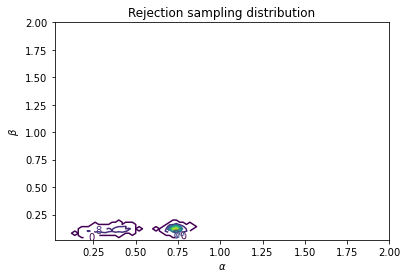

In [176]:
bins = 100
cts, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=bins, range=[[xmin, xmax], [ymin, ymax]])
xcenters = (xedges[:1] + xedges[1:]) / 2
ycenters = (yedges[:1] + yedges[1:]) / 2
CS = plt.contour(xcenters,ycenters, cts.T)
plt.clabel(CS, fontsize=10)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.title('Rejection sampling distribution')
# plt.ylim(0, 4)
# plt.xlim(0, 4)
plt.show()

In [177]:
np.mean(samples, axis=0)

array([1.14529344, 0.2108665 ])

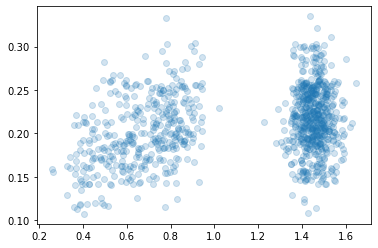

In [178]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.2)